# I. Import and Read

In [139]:
# !pip install causalearn
# !pip install  graphviz

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphNode import GraphNode
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint

from dowhy import CausalModel
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [141]:
df_cai_org = pd.read_csv(r"/home/ailab1/student_share/Thanh/Data/df_causal_ai")
df_cai = df_cai_org.copy()
df_cai.head (10)

CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0     0.144135       1 -0.719973 -0.883163              2          1   
1    -0.367706       1 -1.432694 -0.883163              2          1   
2     0.268974       1  1.774548 -0.883163              2          1   
3    -0.941966       1 -1.076334  1.486918              1          1   
4     0.743362       1 -0.007253 -0.883163              2          1   
5    -0.854578       1 -0.363613  1.214638              1          1   
6    -0.792159       0  1.061827  1.421493              1          1   
7     0.268974       1 -1.432694  1.321262              1          1   
8     0.244006       1 -0.363613 -0.883163              2          1   
9    -0.916998       1 -0.363613  0.410654              1          1   

   IsActiveMember  EstimatedSalary  Exited  Age_Group  Geography_Germany  \
0               0         1.369486       0        0.0                0.0   
1               1        -1.254085       0        0.0                0.0   
2               0         1.437422       0        1.0                0.0   
3               1        -0.557018       0        0.0                0.0   
4               1        -1.938770       0        0.0                0.0   
5               0         0.466260       1        0.0                1.0   
6               0        -1.646018       0        0.0                0.0   
7               0        -0.113798       0        0.0                0.0   
8               0         0.603314       0        2.0                0.0   
9               1         1.158582       0        1.0                1.0   

      p_pre  cluser_label                   Treatment  p_churn_post  
0  0.024463             2         Starter Growth Plan      0.011536  
1  0.012693             2         Starter Growth Plan      0.012087  
2  0.036313             0                  No Program      0.154547  
3  0.042193             1            Engage & Elevate      0.034744  
4  0.012692             2                  No Program      0.007140  
5  0.301286             1                  No Program      0.203210  
6  0.182560             1                  No Program      0.111999  
7  0.094593             1            Engage & Elevate      0.035347  
8  0.164282             0  Wealth Accumulator Program      0.130541  
9  0.196845             1            Engage & Elevate      0.059873

# II. Causal Graph

In [142]:
treatment_mapping = {
    "No Program": 0,
    "Engage & Elevate": 2,
    "Premium Balance Rewards": 5,
    "Reconnect & Reward": 4,
    "Starter Growth Plan": 3,
    "Wealth Accumulator Program": 1
}
df_cai['Treatment_num'] = df_cai['Treatment'].map(treatment_mapping)
# Chọn các biến cho causal graph
cols = [
    'CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label',
    'Age_Group', 'Geography_Germany', 'Treatment_num', 'p_churn_post'
]


## 2.1 FCI Based Graph

In [143]:
# ### Key Points
# - Nghiên cứu cho thấy FCI (Fast Causal Inference) phù hợp hơn khi dữ liệu có thể chứa biến ẩn, vì nó có thể phát hiện và xử lý các yếu tố ẩn không quan sát được.
# - Có vẻ như FCI cung cấp biểu đồ nhân quả chính xác hơn bằng cách sử dụng biểu đồ tổ tiên một phần (PAG), bao gồm các cạnh hai chiều để chỉ ra ảnh hưởng tiềm tàng từ biến ẩn.
# - Bằng chứng nghiêng về việc FCI hỗ trợ kiến thức nền, giúp duy trì các cạnh bắt buộc và cấm, phù hợp với yêu cầu của bạn.

# ### Lý do sử dụng FCI
# **Tóm tắt ngắn gọn:**  
# FCI là lựa chọn tốt hơn so với PC (Peter-Clark) vì nó có thể xử lý biến ẩn, những yếu tố ẩn có thể ảnh hưởng đến dữ liệu của bạn. Trong khi PC giả định không có biến ẩn, FCI phát hiện chúng thông qua biểu đồ tổ tiên một phần (PAG), bao gồm các cạnh hai chiều (<->) để chỉ ra ảnh hưởng tiềm tàng. Điều này đảm bảo biểu đồ nhân quả của bạn chính xác hơn, đặc biệt khi có yếu tố ẩn. FCI cũng hỗ trợ kiến thức nền, phù hợp với các cạnh bắt buộc và cấm bạn đã định nghĩa.

# **Chi tiết bất ngờ:**  
# Kết quả của FCI có thể bao gồm các cạnh hai chiều, giúp bạn nhận ra các mối quan hệ phức tạp hơn do biến ẩn, điều này có thể không rõ ràng khi sử dụng PC.

# ### Hướng dẫn thực hành
# Trong mã của bạn, chỉ cần thay đổi từ `pc` sang `fci` và đảm bảo import đúng:  
# ```python
# from causallearn.search.ConstraintBased.FCI import fci
# ```
# Sau đó, chạy như trước với các tham số như `alpha`, `indep_test`, và `background_knowledge`.

# ---

# ---

# ### Báo cáo chi tiết: Phân tích lý do sử dụng FCI

# Người dùng đã yêu cầu tóm tắt lý do sử dụng FCI (Fast Causal Inference) trong mã của họ, với các dẫn chứng từ cuộc trò chuyện trước đó. Dưới đây là phân tích chi tiết, bao gồm tất cả thông tin liên quan từ cuộc thảo luận trước, được trình bày theo phong cách bài báo chuyên nghiệp.

# #### Bối cảnh và Yêu cầu
# Trong cuộc trò chuyện trước, người dùng ban đầu sử dụng thuật toán PC (Peter-Clark) từ thư viện `causallearn` để khám phá nhân quả, với dữ liệu được chọn từ `df_cai` và định nghĩa kiến thức nền (background knowledge) với các cạnh bắt buộc và cấm. Tuy nhiên, họ muốn tối ưu hóa mã để xử lý tốt nhất các biến ẩn (latent variables), tức là các yếu tố không quan sát được có thể ảnh hưởng đến mối quan hệ giữa các biến quan sát. Dựa trên yêu cầu này, tôi đã đề xuất chuyển sang FCI, một phần mở rộng của PC, để xử lý biến ẩn hiệu quả hơn.

# #### Lý do sử dụng FCI
# Nghiên cứu cho thấy FCI là lựa chọn tối ưu khi dữ liệu có thể chứa biến ẩn, vì nó được thiết kế để phát hiện và xử lý các yếu tố ẩn không quan sát được. Dưới đây là các lý do cụ thể, dựa trên phân tích từ cuộc trò chuyện:

# 1. **Xử lý Biến Ẩn:**  
#    PC giả định không có biến ẩn (causal sufficiency), nghĩa là tất cả các biến gây nhiễu (confounders) đều được quan sát. Tuy nhiên, trong nhiều trường hợp thực tế, dữ liệu có thể bị ảnh hưởng bởi các yếu tố ẩn, dẫn đến kết quả sai lệch nếu sử dụng PC. FCI, ngược lại, được thiết kế để xử lý trường hợp này bằng cách cho phép phát hiện các ảnh hưởng từ biến ẩn thông qua các cạnh hai chiều (<->) trong biểu đồ tổ tiên một phần (PAG). Điều này được hỗ trợ bởi nghiên cứu như [Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiers.org/journals/genetics/articles/10.3389/fgene.2019.00524/full), so sánh các phương pháp và nhấn mạnh khả năng của FCI trong việc xử lý biến ẩn.

# 2. **Đầu Ra Biểu Đồ:**  
#    FCI cung cấp đầu ra là PAG, thay vì CPDAG (Completed Partially Directed Acyclic Graph) như PC. PAG có thể bao gồm các cạnh hai chiều (<->), biểu thị khả năng có một nguyên nhân chung ẩn (latent common cause). Điều này giúp người dùng hiểu rõ hơn về cấu trúc nhân quả, đặc biệt khi có biến ẩn. Trong cuộc trò chuyện, tôi đã lưu ý rằng điều này là một chi tiết quan trọng, vì nó cung cấp thông tin sâu hơn về ảnh hưởng tiềm tàng, không rõ ràng khi sử dụng PC.

# 3. **Hỗ Trợ Kiến Thức Nền:**  
#    Người dùng đã định nghĩa các cạnh bắt buộc (như `Treatment_num --> p_churn_post`) và cấm (như `p_churn_post --> Balance`) trong mã. FCI, giống như PC, hỗ trợ tham số `background_knowledge`, đảm bảo rằng các ràng buộc này được tôn trọng trong quá trình học biểu đồ. Điều này được xác nhận trong tài liệu [causallearn documentation for FCI](https://causallearn.readthedocs.io/en/stable/search/constraint_based.html), cho thấy FCI duy trì khả năng tích hợp kiến thức trước, phù hợp với yêu cầu của người dùng.

# 4. **Phù Hợp Với Yêu Cầu Tối Ưu:**  
#    Trong cuộc thảo luận, khi người dùng hỏi về việc tối ưu hóa mã cho biến ẩn, tôi đã đề xuất FCI vì nó mạnh mẽ hơn trong các kịch bản phức tạp, đặc biệt khi dữ liệu có thể bị ảnh hưởng bởi các yếu tố ẩn. Nghiên cứu như [A Hybrid Causal Search Algorithm for Latent Variable Models - PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC5325717/) chỉ ra rằng các phương pháp dựa trên ràng buộc như FCI hoạt động tốt hơn so với các phương pháp dựa trên điểm số như GES trong trường hợp có biến ẩn, củng cố lý do sử dụng FCI.

# #### So Sánh PC và FCI
# Dưới đây là bảng so sánh giữa PC và FCI, dựa trên các tiêu chí liên quan đến xử lý biến ẩn và hỗ trợ kiến thức nền:

# | **Tiêu chí**              | **PC**                              | **FCI**                              |
# |---------------------------|--------------------------------------|--------------------------------------|
# | Xử lý biến ẩn             | Không, giả định không có confounders | Có, phát hiện ảnh hưởng tiềm tàng qua PAG |
# | Đầu ra                   | CPDAG (cạnh định hướng và không định hướng) | PAG (bao gồm cạnh hai chiều cho biến ẩn) |
# | Hỗ trợ kiến thức nền      | Có                                  | Có                                  |
# | Phù hợp với biến ẩn nhiều  | Không lý tưởng, dễ sai lệch         | Tốt hơn, mạnh mẽ hơn                 |
# | Độ phức tạp tính toán     | Thấp hơn                           | Cao hơn, tùy thuộc vào kích thước dữ liệu |

# Bảng trên cho thấy FCI vượt trội hơn PC trong việc xử lý biến ẩn, phù hợp với yêu cầu tối ưu hóa mã của người dùng.

# #### Thực Hành và Ứng Dụng
# Trong cuộc trò chuyện, tôi đã hướng dẫn người dùng cách chuyển từ PC sang FCI, chỉ cần thay đổi import từ `from causallearn.search.ConstraintBased import pc` thành `from causallearn.search.ConstraintBased.FCI import fci`, và gọi `fci` với các tham số tương tự. Điều này đơn giản hóa việc áp dụng, đồng thời đảm bảo rằng mã của họ có thể xử lý tốt hơn các biến ẩn tiềm tàng.

# Ngoài ra, tôi đã lưu ý rằng đầu ra của FCI (PAG) có thể bao gồm các cạnh hai chiều, giúp người dùng nhận ra các mối quan hệ phức tạp hơn do biến ẩn, điều này có thể không rõ ràng khi sử dụng PC. Đây là một chi tiết quan trọng, vì nó cung cấp thông tin bổ sung để phân tích sâu hơn.

# #### Kết Luận
# Tóm lại, FCI là lựa chọn tối ưu cho mã của người dùng vì khả năng xử lý biến ẩn, hỗ trợ kiến thức nền, và cung cấp biểu đồ nhân quả chính xác hơn thông qua PAG. Các nghiên cứu và tài liệu được thảo luận trong cuộc trò chuyện, như [Fast Causal Inference](https://www.jmlr.org/papers/volume13/colombo12a/colombo12a.pdf), [Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiers.org/journals/genetics/articles/10.3389/fgene.2019.00524/full), và [A Hybrid Causal Search Algorithm for Latent Variable Models - PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC5325717/), đều hỗ trợ cho việc sử dụng FCI trong trường hợp này.

# #### Key Citations
# - [Fast Causal Inference](https://www.jmlr.org/papers/volume13/colombo12a/colombo12a.pdf)
# - [causallearn documentation for FCI](https://causallearn.readthedocs.io/en/stable/search/constraint_based.html)
# - [Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiers.org/journals/genetics/articles/10.3389/fgene.2019.00524/full)
# - [A Hybrid Causal Search Algorithm for Latent Variable Models - PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC5325717/)
# - [Discovery of Causal Models that Contain Latent Variables through Bayesian Scoring of Independence Constraints - PMC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5836552/)

In [144]:
# Giả sử df_cai và danh sách cols đã được định nghĩa
data_df = df_cai[cols]
data_np = data_df.values
node_names = data_df.columns.to_list()
data_np = df_cai[cols].values  
# Tạo đối tượng BackgroundKnowledge
background_knowledge = BackgroundKnowledge()

# Tạo GraphNode cho từng biến
nodes = {name: GraphNode(name) for name in node_names}

# Định nghĩa các cạnh bắt buộc (required_edges) và các cạnh cấm (forbidden_edges)
required_edges = [
    # các cạnh đến cluster bắt buộc
    ("Tenure", "cluser_label"),
    ("NumOfProducts", "cluser_label"),
    ("Balance", "cluser_label"),
    ("IsActiveMember", "cluser_label"),
    ("CreditScore", "cluser_label"),
    ("EstimatedSalary", "cluser_label"),
    ("Age_Group", "cluser_label"),

    ("Treatment_num", "p_churn_post"),
    ("cluser_label", "Treatment_num")
]

forbidden_edges = [
    ("p_churn_post", "Balance"),
    ("p_churn_post", "Age_Group"),
]

# Thêm các cạnh bắt buộc vào BackgroundKnowledge
for edge in required_edges:
    background_knowledge.add_required_by_node(nodes[edge[0]], nodes[edge[1]])

# Thêm các cạnh bị cấm vào BackgroundKnowledge
for edge in forbidden_edges:
    background_knowledge.add_forbidden_by_node(nodes[edge[0]], nodes[edge[1]])

graph, edges = fci(
    dataset=data_np,
    alpha=0.01,
    independence_test_method="fisherz",
    node_names=node_names,
    background_knowledge=background_knowledge
)



Depth=0, working on node 12: 100%|██████████| 13/13 [00:00<00:00, 308.28it/s]


Starting BK Orientation.
Orienting edge (Knowledge): CreditScore --> cluser_label
Orienting edge (Knowledge): Tenure --> cluser_label
Orienting edge (Knowledge): Balance --> cluser_label
Orienting edge (Knowledge): Balance --> p_churn_post
Orienting edge (Knowledge): NumOfProducts --> cluser_label
Orienting edge (Knowledge): EstimatedSalary --> cluser_label
Orienting edge (Knowledge): Age_Group --> cluser_label
Orienting edge (Knowledge): cluser_label --> Treatment_num
Orienting edge (Knowledge): Age_Group --> p_churn_post
Orienting edge (Knowledge): Treatment_num --> p_churn_post
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): CreditScore --> cluser_label
Orienting edge (Knowledge): Tenure --> cluser_label
Orienting edge (Knowledge): Balance --> cluser_label
Orienting edge (Knowledge): Balance --> p_churn_post
Orienting edge (Knowledge): NumOfProducts --> cluser_label
Orienting edge (Knowledge): EstimatedSalary --> cluser_label
Orienting edge (Knowledge)

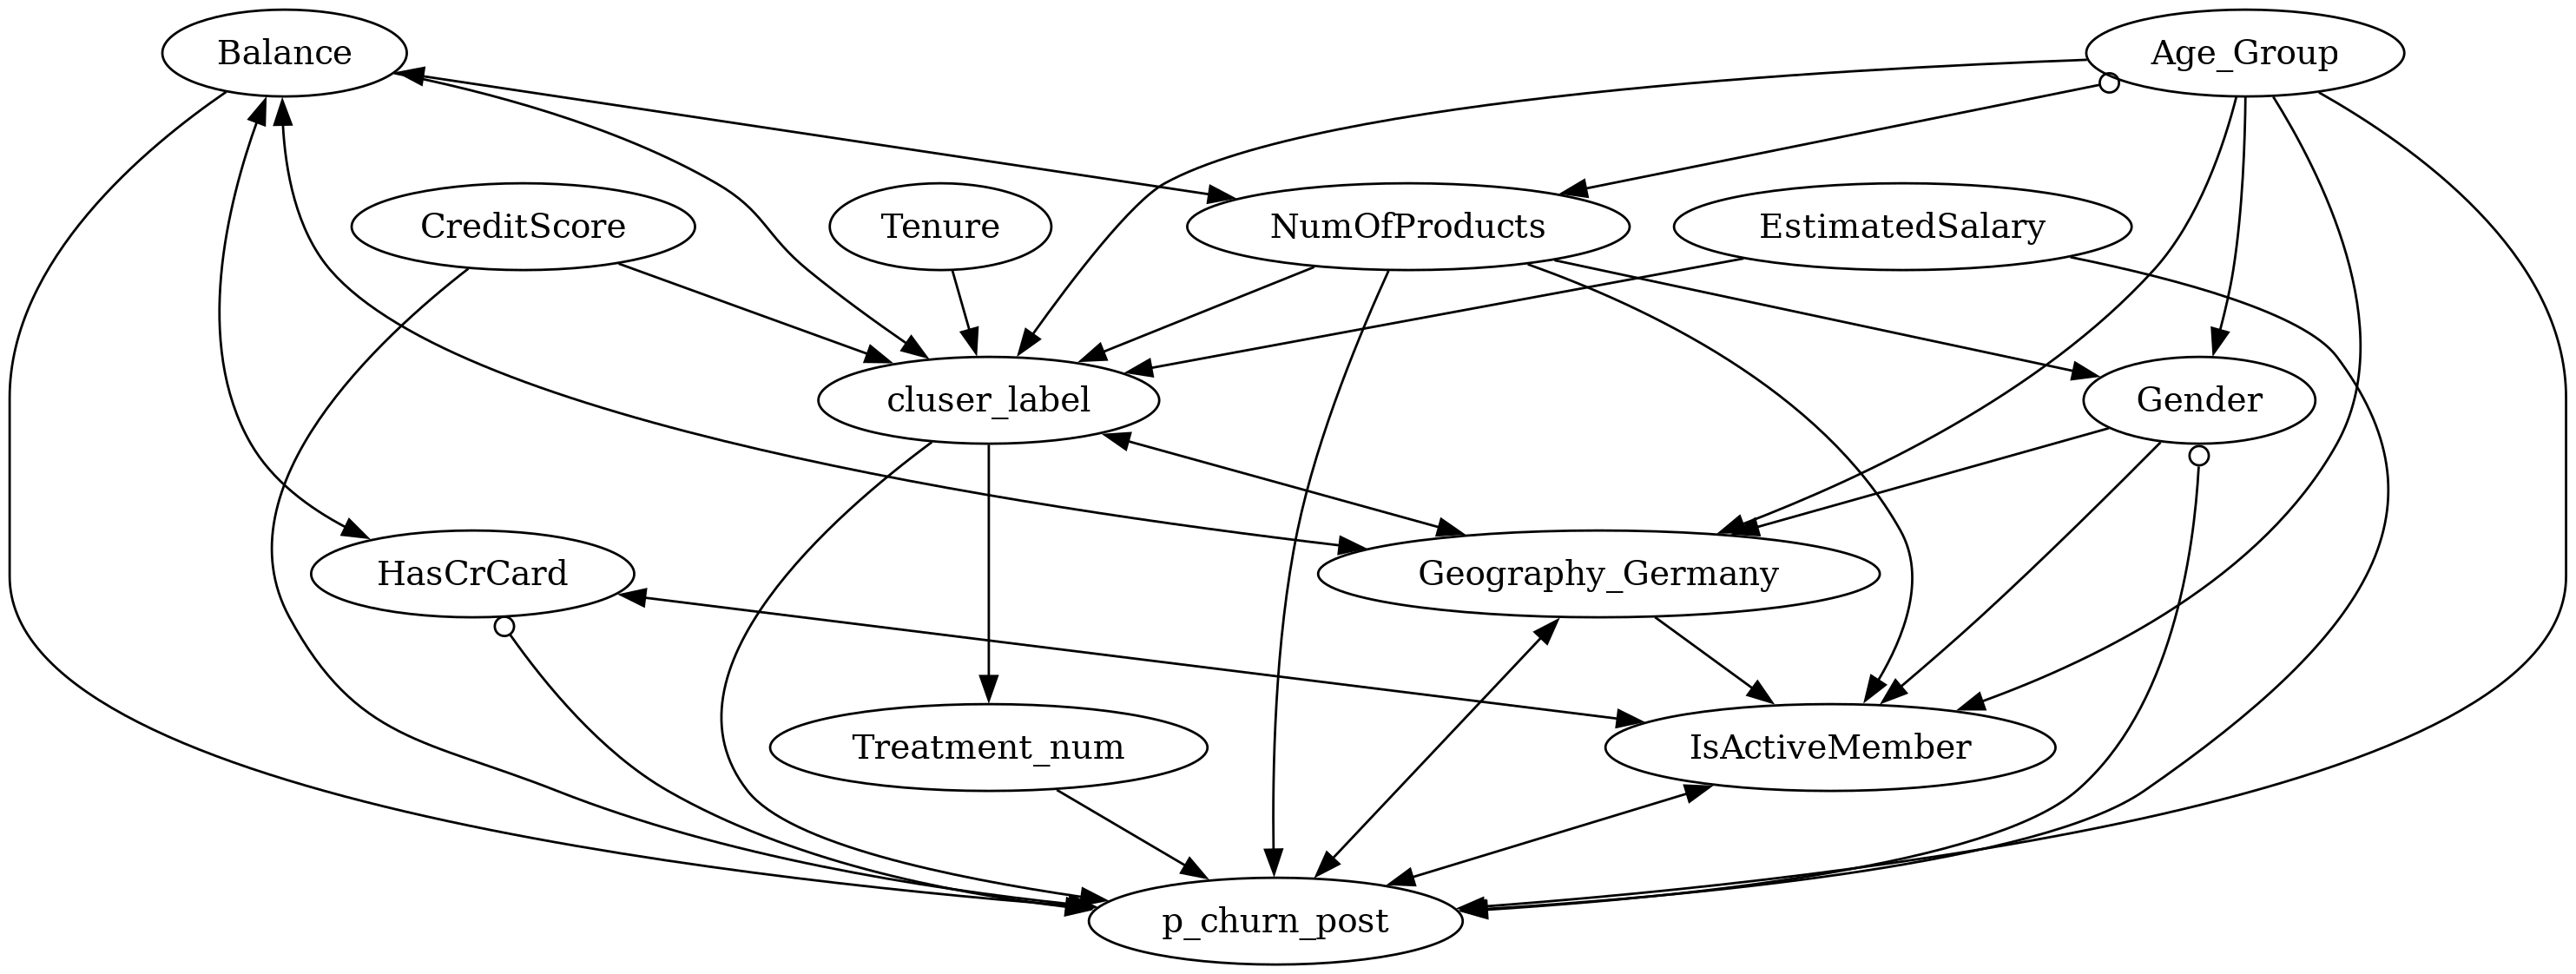

In [145]:
# visualization
pdy = GraphUtils.to_pydot(graph)
# Tạo dữ liệu PNG dưới dạng nhị phân
png_data = pdy.create_png()

# Hiển thị ảnh trong notebook
from IPython.display import Image, display
display(Image(data=png_data))

In [146]:
# Retrieve all edges from the causal graph
edges = graph.get_graph_edges()

# List all edges as "from → to"
for edge in edges:
    node1 = edge.get_node1().get_name()
    node2 = edge.get_node2().get_name()
    print(f"From: {node1}, To: {node2}")


From: CreditScore, To: cluser_label
From: CreditScore, To: p_churn_post
From: NumOfProducts, To: Gender
From: Gender, To: IsActiveMember
From: Age_Group, To: Gender
From: Gender, To: Geography_Germany
From: Gender, To: p_churn_post
From: Tenure, To: cluser_label
From: Balance, To: NumOfProducts
From: Balance, To: HasCrCard
From: Balance, To: cluser_label
From: Balance, To: Geography_Germany
From: Balance, To: p_churn_post
From: NumOfProducts, To: IsActiveMember
From: NumOfProducts, To: cluser_label
From: Age_Group, To: NumOfProducts
From: NumOfProducts, To: p_churn_post
From: HasCrCard, To: IsActiveMember
From: HasCrCard, To: p_churn_post
From: Age_Group, To: IsActiveMember
From: Geography_Germany, To: IsActiveMember
From: IsActiveMember, To: p_churn_post
From: EstimatedSalary, To: cluser_label
From: EstimatedSalary, To: p_churn_post
From: Age_Group, To: cluser_label
From: cluser_label, To: Geography_Germany
From: cluser_label, To: Treatment_num
From: cluser_label, To: p_churn_post
Fro

## 2.2 Modify Graph

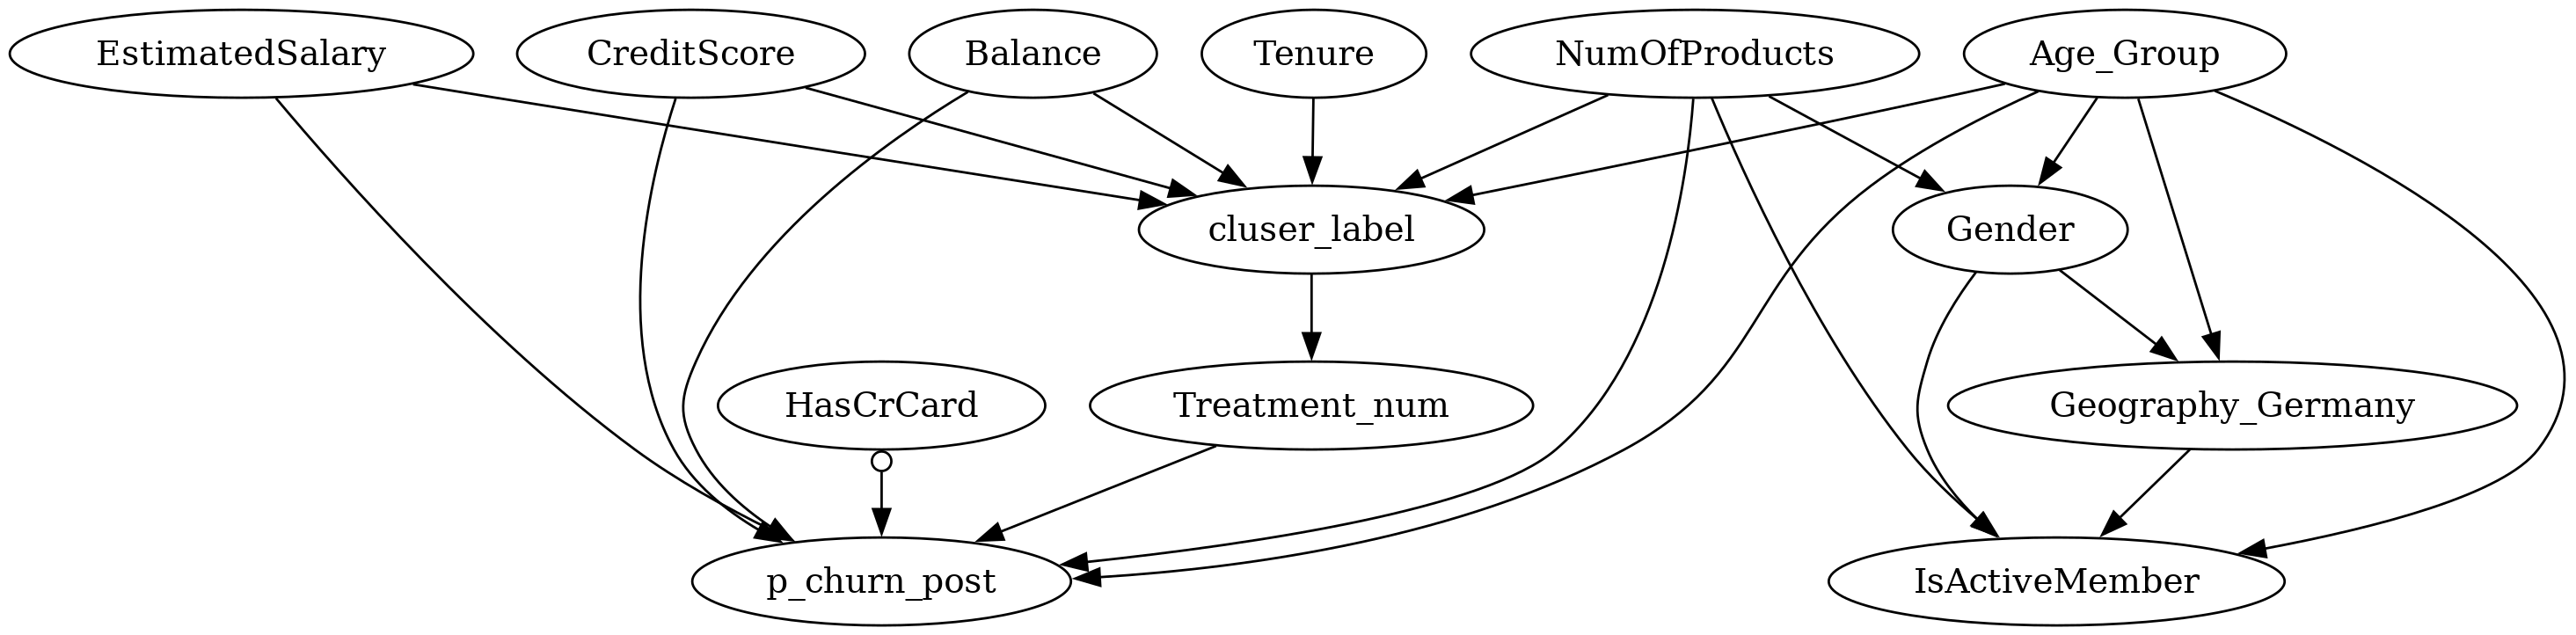

In [147]:
drop_edges = [
    ("Geography_Germany", "cluser_label"),
    ("Balance", "HasCrCard"),
    ("Balance", "Geography_Germany"),
    ("Balance", "NumOfProducts"),
    ("Age_Group", "NumOfProducts"),
    ("Gender", "p_churn_post"),
    ("Geography_Germany", "p_churn_post"),
    ("Geography_Germany", "cluser_label"),
    ("HasCrCard", "IsActiveMember"),
    ("IsActiveMember", "p_churn_post"),
    ("cluser_label", "p_churn_post")
]


# Xóa các cạnh không cần thiết từ đồ thị causal
for src, tgt in drop_edges:
    edge_to_remove = graph.get_edge(nodes[src], nodes[tgt])
    if edge_to_remove:  # Chỉ xóa nếu cạnh tồn tại
        graph.remove_edge(edge_to_remove)

# Vẽ lại đồ thị đã cập nhật
pdy = GraphUtils.to_pydot(graph)
png_data = pdy.create_png()

# Hiển thị ảnh trong notebook
from IPython.display import Image, display
display(Image(data=png_data))

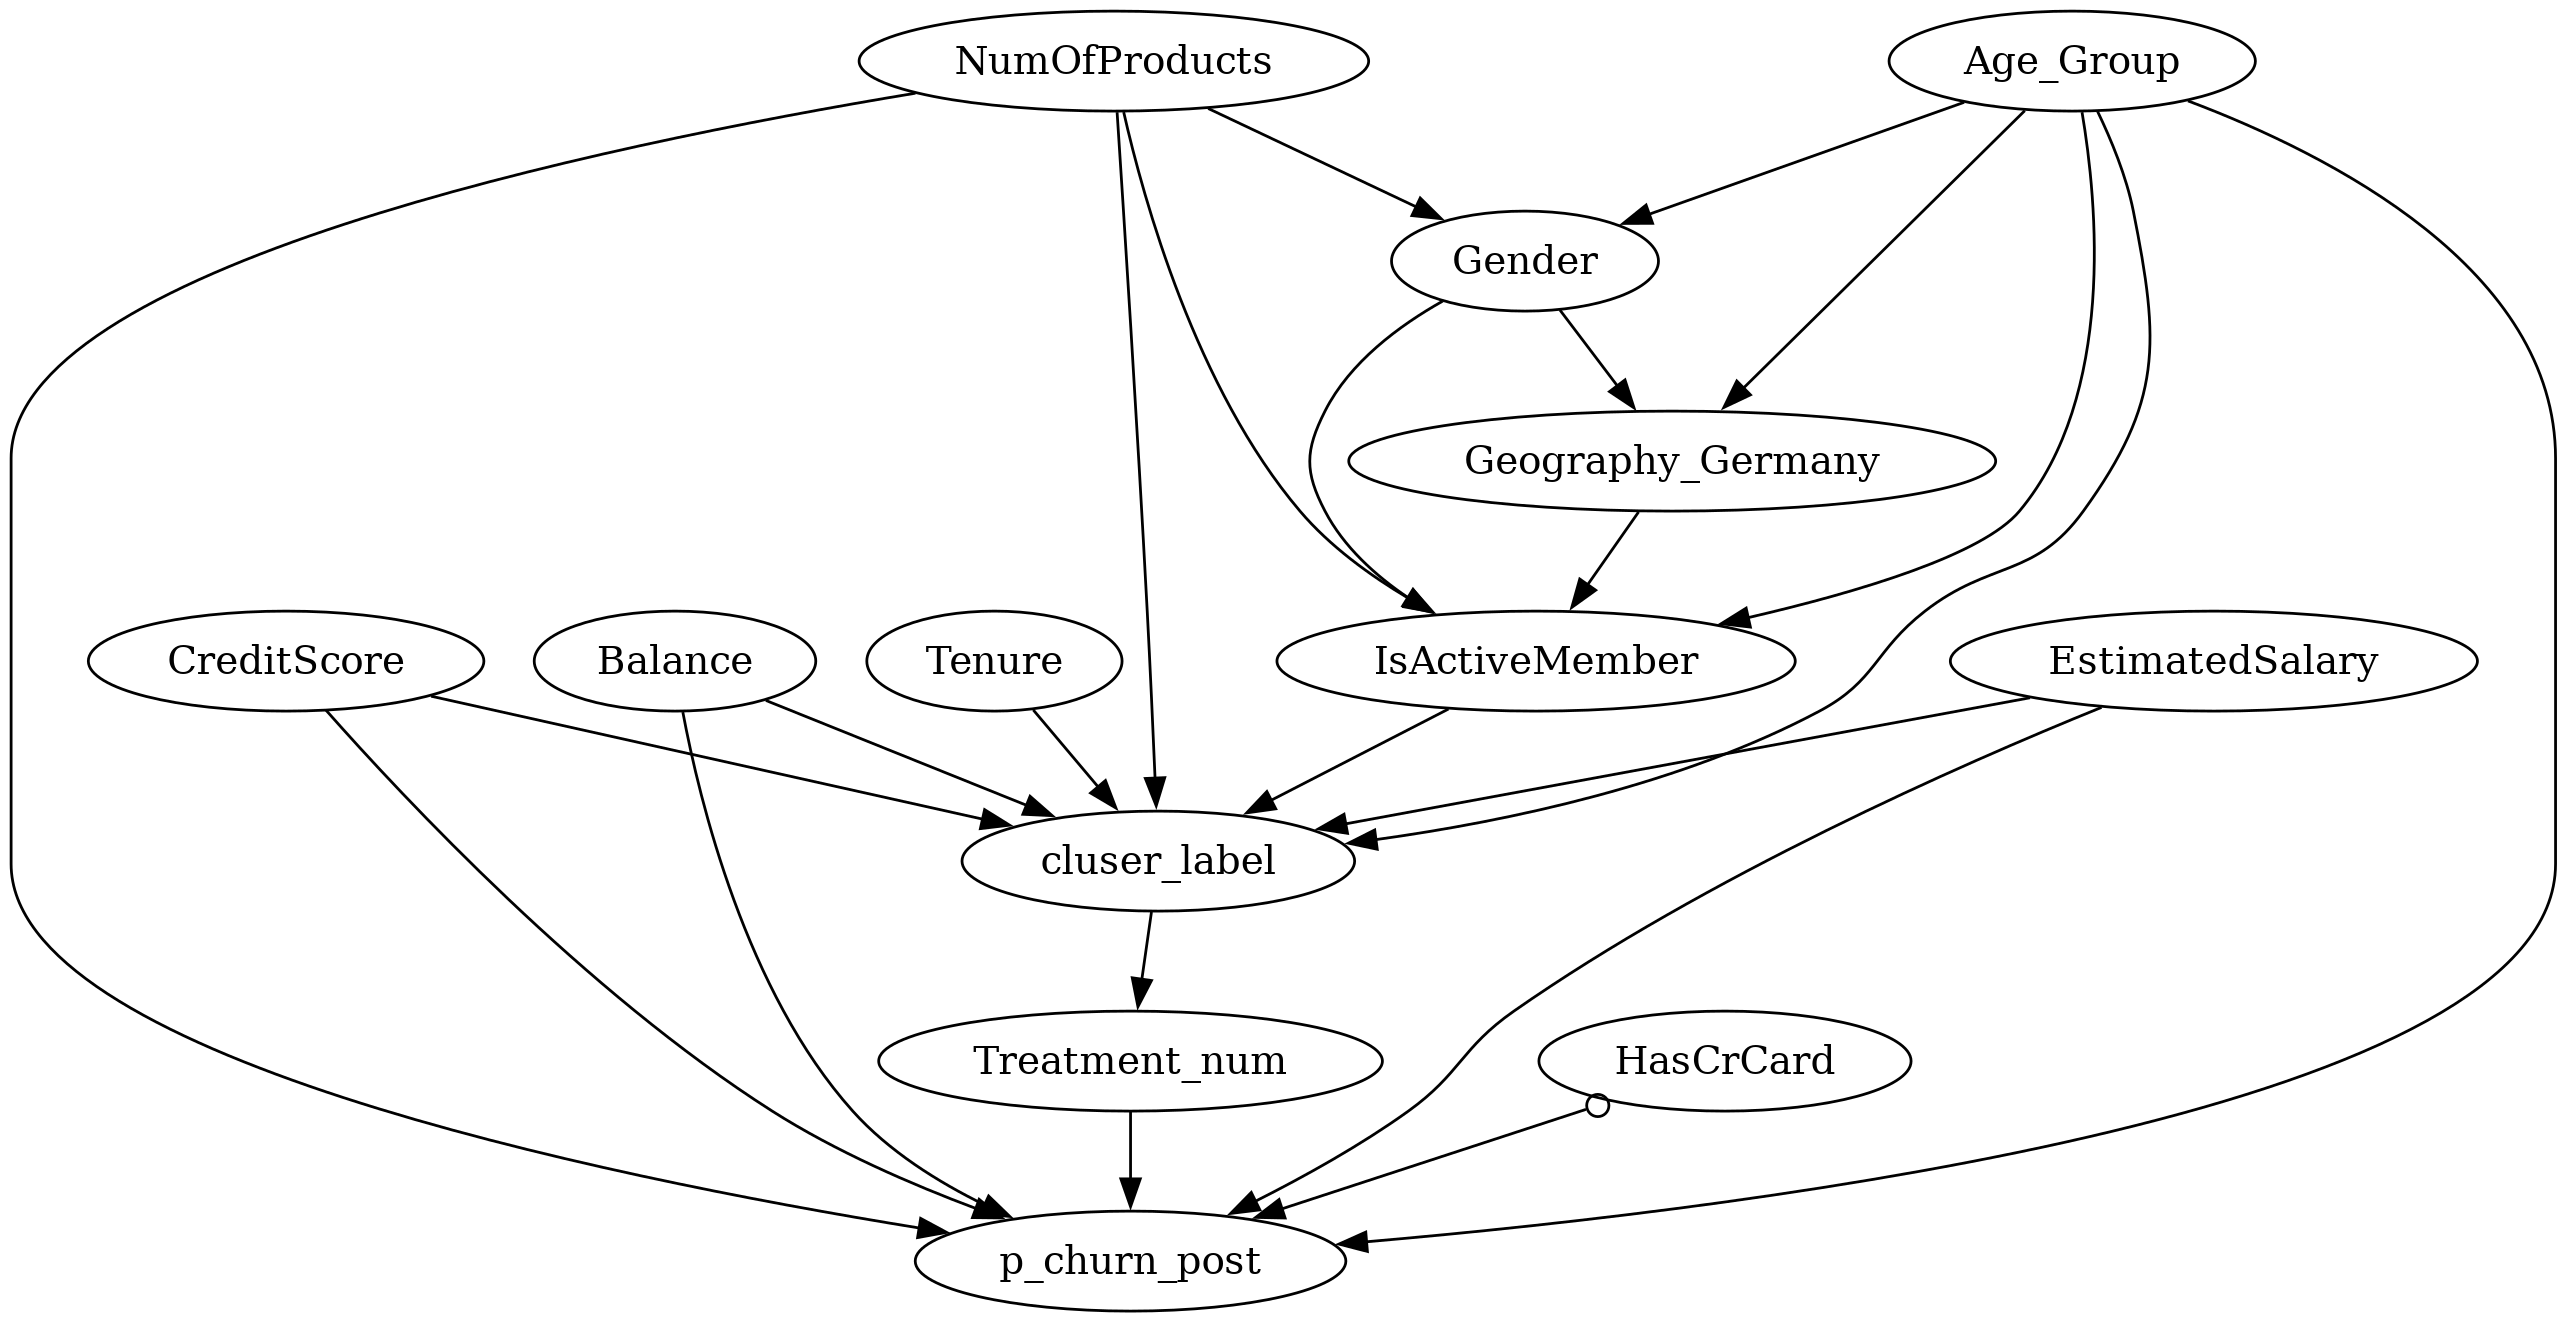

In [148]:
new_edges = [
    ("IsActiveMember", "cluser_label"),
]

# Thêm các cạnh mới, chỉ thêm nếu cạnh chưa tồn tại
for src, tgt in new_edges:
    if not graph.get_edge(nodes[src], nodes[tgt]):
        new_edge = Edge(nodes[src], nodes[tgt], Endpoint.TAIL, Endpoint.ARROW)
        graph.add_edge(new_edge)  # Thêm cạnh mới vào đồ thị

# Vẽ lại đồ thị đã cập nhật
pdy = GraphUtils.to_pydot(graph)
png_data = pdy.create_png()

# Hiển thị ảnh trong notebook
from IPython.display import Image, display
display(Image(data=png_data))


# III. SCM

In [149]:
df_cai = df_cai.drop(columns=['Treatment'], errors='ignore')
df_cai

CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0          0.144135       1 -0.719973 -0.883163              2          1   
1         -0.367706       1 -1.432694 -0.883163              2          1   
2          0.268974       1  1.774548 -0.883163              2          1   
3         -0.941966       1 -1.076334  1.486918              1          1   
4          0.743362       1 -0.007253 -0.883163              2          1   
...             ...     ...       ...       ...            ...        ...   
165029     0.131651       0 -1.076334 -0.883163              1          1   
165030     1.692140       1 -0.719973 -0.883163              1          0   
165031    -1.141708       1 -0.007253 -0.883163              1          1   
165032    -1.279031       0  0.705467  1.688303              1          0   
165033     2.416207       1 -1.432694 -0.883163              1          1   

        IsActiveMember  EstimatedSalary  Exited  Age_Group  Geography_Germany  \
0                    0         1.369486       0        0.0                0.0   
1                    1        -1.254085       0        0.0                0.0   
2                    0         1.437422       0        1.0                0.0   
3                    1        -0.557018       0        0.0                0.0   
4                    1        -1.938770       0        0.0                0.0   
...                ...              ...     ...        ...                ...   
165029               1         0.382957       0        0.0                0.0   
165030               0         0.382951       0        0.0                0.0   
165031               1         0.295366       0        0.0                0.0   
165032               1        -0.823217       0        0.0                0.0   
165033               0        -1.013925       1        0.0                0.0   

           p_pre  cluser_label  p_churn_post  Treatment_num  
0       0.024463             2      0.011536              3  
1       0.012693             2      0.012087              3  
2       0.036313             0      0.154547              0  
3       0.042193             1      0.034744              2  
4       0.012692             2      0.007140              0  
...          ...           ...           ...            ...  
165029  0.157476             3      0.063101              4  
165030  0.228613             3      0.317043              4  
165031  0.097923             3      0.076299              4  
165032  0.101181             1      0.079845              2  
165033  0.215444             3      0.054902              4  

[165034 rows x 15 columns]

In [150]:
X= df_cai.drop(columns = ['p_churn_post'], errors='ignore')
y = (df_cai['p_churn_post'] > 0.5).astype(int)

In [151]:
def scm_logistics(X, y, method='logistic', test_size=0.2, random_state=42, random_trials=1000):
    """
    Hàm SCM Logistics dùng để tìm hệ số của mô hình logistic cho dữ liệu
    và đánh giá độ chính xác của mô hình.
    
    Tham số:
      - X: ma trận đặc trưng (numpy array hoặc DataFrame)
      - y: biến mục tiêu (binary: 0/1)
      - method: 'logistic' để dùng Logistic Regression, 
                'random' để dùng tìm kiếm ngẫu nhiên (random search)
      - test_size: tỷ lệ dữ liệu dùng làm tập kiểm tra
      - random_state: hạt giống cho việc chia dữ liệu
      - random_trials: số lần thử khi dùng random search
      
    Trả về:
      - Với method 'logistic': mô hình đã huấn luyện và độ chính xác trên tập kiểm tra
      - Với method 'random': bộ hệ số (coef, intercept) tốt nhất và độ chính xác trên tập kiểm tra
    """

    # Tách dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    if method == 'logistic':
        # Sử dụng Logistic Regression
        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Logistic Regression coefficients:", model.coef_)
        print("Intercept:", model.intercept_)
        print("Test Accuracy:", acc)
        return model, acc
    
    elif method == 'random':
        # Sử dụng tìm kiếm ngẫu nhiên để tìm hệ số tối ưu trên tập huấn luyện
        n_features = X_train.shape[1]
        best_acc = 0
        best_coef = None
        best_intercept = None
        
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))
        
        for _ in range(random_trials):
            coef = np.random.uniform(-1, 1, size=n_features)
            intercept = np.random.uniform(-1, 1)
            logits = np.dot(X_train, coef) + intercept
            probs = sigmoid(logits)
            y_pred_train = (probs >= 0.5).astype(int)
            train_acc = accuracy_score(y_train, y_pred_train)
            if train_acc > best_acc:
                best_acc = train_acc
                best_coef = coef
                best_intercept = intercept
        
        # Đánh giá trên tập kiểm tra
        logits_test = np.dot(X_test, best_coef) + best_intercept
        probs_test = sigmoid(logits_test)
        y_pred_test = (probs_test >= 0.5).astype(int)
        test_acc = accuracy_score(y_test, y_pred_test)
        print("Random search best coefficients:", best_coef)
        print("Intercept:", best_intercept)
        print("Train Accuracy:", best_acc)
        print("Test Accuracy:", test_acc)
        return (best_coef, best_intercept), test_acc
    
    else:
        raise ValueError("Method not recognized. Choose 'logistic' or 'random'.")



In [152]:
model, test_acc = scm_logistics(X, y, method='logistic')


Logistic Regression coefficients: [[ 1.11374690e-02 -4.63178805e-02  4.80375265e-03  7.92436251e-03
  -5.96120704e-02 -2.99143619e-02 -1.69864286e-01  2.69024165e-02
  -1.92182194e-02  3.73593851e-02  5.43879563e-02  1.09432443e+01
   2.72688717e-01 -4.07666425e-01]]
Intercept: [-5.85049995]
Test Accuracy: 0.9472536128699973


In [153]:
# best_params, test_acc = scm_logistics(X, y, method='random', random_trials=1000)


# IV. PSM

In [154]:
df_train =df_cai_org.copy()
df_train

CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0          0.144135       1 -0.719973 -0.883163              2          1   
1         -0.367706       1 -1.432694 -0.883163              2          1   
2          0.268974       1  1.774548 -0.883163              2          1   
3         -0.941966       1 -1.076334  1.486918              1          1   
4          0.743362       1 -0.007253 -0.883163              2          1   
...             ...     ...       ...       ...            ...        ...   
165029     0.131651       0 -1.076334 -0.883163              1          1   
165030     1.692140       1 -0.719973 -0.883163              1          0   
165031    -1.141708       1 -0.007253 -0.883163              1          1   
165032    -1.279031       0  0.705467  1.688303              1          0   
165033     2.416207       1 -1.432694 -0.883163              1          1   

        IsActiveMember  EstimatedSalary  Exited  Age_Group  Geography_Germany  \
0                    0         1.369486       0        0.0                0.0   
1                    1        -1.254085       0        0.0                0.0   
2                    0         1.437422       0        1.0                0.0   
3                    1        -0.557018       0        0.0                0.0   
4                    1        -1.938770       0        0.0                0.0   
...                ...              ...     ...        ...                ...   
165029               1         0.382957       0        0.0                0.0   
165030               0         0.382951       0        0.0                0.0   
165031               1         0.295366       0        0.0                0.0   
165032               1        -0.823217       0        0.0                0.0   
165033               0        -1.013925       1        0.0                0.0   

           p_pre  cluser_label            Treatment  p_churn_post  
0       0.024463             2  Starter Growth Plan      0.011536  
1       0.012693             2  Starter Growth Plan      0.012087  
2       0.036313             0           No Program      0.154547  
3       0.042193             1     Engage & Elevate      0.034744  
4       0.012692             2           No Program      0.007140  
...          ...           ...                  ...           ...  
165029  0.157476             3   Reconnect & Reward      0.063101  
165030  0.228613             3   Reconnect & Reward      0.317043  
165031  0.097923             3   Reconnect & Reward      0.076299  
165032  0.101181             1     Engage & Elevate      0.079845  
165033  0.215444             3   Reconnect & Reward      0.054902  

[165034 rows x 15 columns]

In [155]:
# ---------------------------
# PHẦN 1: Chuẩn bị
# ---------------------------
# Các biến confounders (như bạn đang dùng)
confounders = [
    'CreditScore', 'Geography_Germany', 'Gender', 'Age_Group', 'Tenure',
    'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label'
]

# Ngưỡng caliper
caliper = 0.01

# Tạo dictionary lưu kết quả Hybrid Method cho mỗi treatment
# (key: treatment name, value: DataFrame chứa data matched & weighted)
hybrid_results = {}

# Danh sách các cluster
clusters = df_train['cluser_label'].unique()

# Danh sách treatment (bỏ "No Program")
all_treatments = df_train['Treatment'].unique().tolist()
if "No Program" in all_treatments:
    all_treatments.remove("No Program")

# ---------------------------
# PHẦN 2: Hybrid Method - Matching & Weighting (Without Replacement)
# ---------------------------
for cluster in clusters:
    # Lọc dữ liệu theo cluster
    cluster_data = df_train[df_train['cluser_label'] == cluster].copy()

    # Với mỗi treatment khác "No Program"
    for treatment in cluster_data['Treatment'].unique():
        if treatment == "No Program":
            continue  # bỏ qua control

        # Lấy subset: chỉ gồm treatment đang xét & "No Program"
        subset = cluster_data[cluster_data['Treatment'].isin([treatment, "No Program"])].copy()

        # Tạo biến treated_indicator (1 = treated, 0 = control)
        subset['treated_indicator'] = np.where(subset['Treatment'] == treatment, 1, 0)

        # Tách X, y cho Logistic Regression
        X = subset[confounders].values
        y = subset['treated_indicator'].values

        # Ước lượng propensity score
        lr = LogisticRegression()
        lr.fit(X, y)
        subset['propensity_score'] = lr.predict_proba(X)[:, 1]

        # Tách riêng nhóm treated & control
        treated_data = subset[subset['treated_indicator'] == 1].copy()
        control_data = subset[subset['treated_indicator'] == 0].copy()

        # Kiểm tra nếu thiếu treated hoặc control
        if control_data.shape[0] == 0 or treated_data.shape[0] == 0:
            print(f"[Cluster {cluster}, Treatment {treatment}] Không đủ control hoặc treated. Bỏ qua.")
            continue

        # -------------------------------
        # BƯỚC 1: Matching (Without Replacement)
        # -------------------------------
        matched_indices = []

        # Tạo bản copy để loại dần các control đã được match
        available_control = control_data.copy()

        for treated_idx, treated_row in treated_data.iterrows():
            ps_treated = treated_row['propensity_score']

            # Lọc những control có |PS_control - PS_treated| <= caliper
            control_candidates = available_control[
                np.abs(available_control['propensity_score'] - ps_treated) <= caliper
            ]

            # Nếu không tìm thấy control phù hợp, bỏ qua treated này
            if control_candidates.empty:
                continue

            # Chọn control có khoảng cách PS nhỏ nhất
            best_control_idx = (
                np.abs(control_candidates['propensity_score'] - ps_treated)
            ).idxmin()

            # Lưu cặp matched
            matched_indices.append((treated_idx, best_control_idx))

            # Loại control đã match khỏi available_control
            available_control.drop(index=best_control_idx, inplace=True)

        if len(matched_indices) == 0:
            print(f"[Cluster {cluster}, Treatment {treatment}] Không tìm được cặp match nào.")
            continue

        # Tạo DataFrame cho matched_treated & matched_control
        matched_treated = treated_data.loc[[ti for ti, _ in matched_indices]].copy()
        matched_control = control_data.loc[[ci for _, ci in matched_indices]].copy()

        # Để tiện ghép 2 DataFrame theo index
        matched_control.index = matched_treated.index

        # Gộp lại thành matched_data
        matched_data = pd.concat([matched_treated, matched_control], axis=0)

        # -------------------------------
        # BƯỚC 2: Tính trọng số IPW
        # -------------------------------
        matched_data['IPW Weight'] = np.where(
            matched_data['treated_indicator'] == 1,
            1 / matched_data['propensity_score'],
            1 / (1 - matched_data['propensity_score'])
        )

        # -------------------------------
        # Lưu vào hybrid_results
        # -------------------------------
        if treatment not in hybrid_results:
            hybrid_results[treatment] = matched_data.copy()
        else:
            hybrid_results[treatment] = pd.concat([hybrid_results[treatment], matched_data], axis=0)

# ---------------------------
# PHẦN 3: In số lượng mẫu cuối
# ---------------------------
for treatment, data in hybrid_results.items():
    print(f"Treatment '{treatment}': Số mẫu sau Matching (without replacement) + Weighting = {data.shape[0]}")


Treatment 'Starter Growth Plan': Số mẫu sau Matching (without replacement) + Weighting = 37770
Treatment 'Wealth Accumulator Program': Số mẫu sau Matching (without replacement) + Weighting = 14430
Treatment 'Engage & Elevate': Số mẫu sau Matching (without replacement) + Weighting = 42308
Treatment 'Premium Balance Rewards': Số mẫu sau Matching (without replacement) + Weighting = 17316
Treatment 'Reconnect & Reward': Số mẫu sau Matching (without replacement) + Weighting = 20196


- Treatment 'Starter Growth Plan': Số mẫu sau Matching (without replacement) + Weighting = 37770
- Treatment 'Wealth Accumulator Program': Số mẫu sau Matching (without replacement) + Weighting = 14430
- Treatment 'Engage & Elevate': Số mẫu sau Matching (without replacement) + Weighting = 42308
- Treatment 'Premium Balance Rewards': Số mẫu sau Matching (without replacement) + Weighting = 17316
- Treatment 'Reconnect & Reward': Số mẫu sau Matching (without replacement) + Weighting = 20196

/tmp/ipykernel_1745577/2292786350.py:23: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_1745577/2292786350.py:25: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_1745577/2292786350.py:23: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_1745577/2292786350.py:25: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_1745577/2292786350.py:23: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/

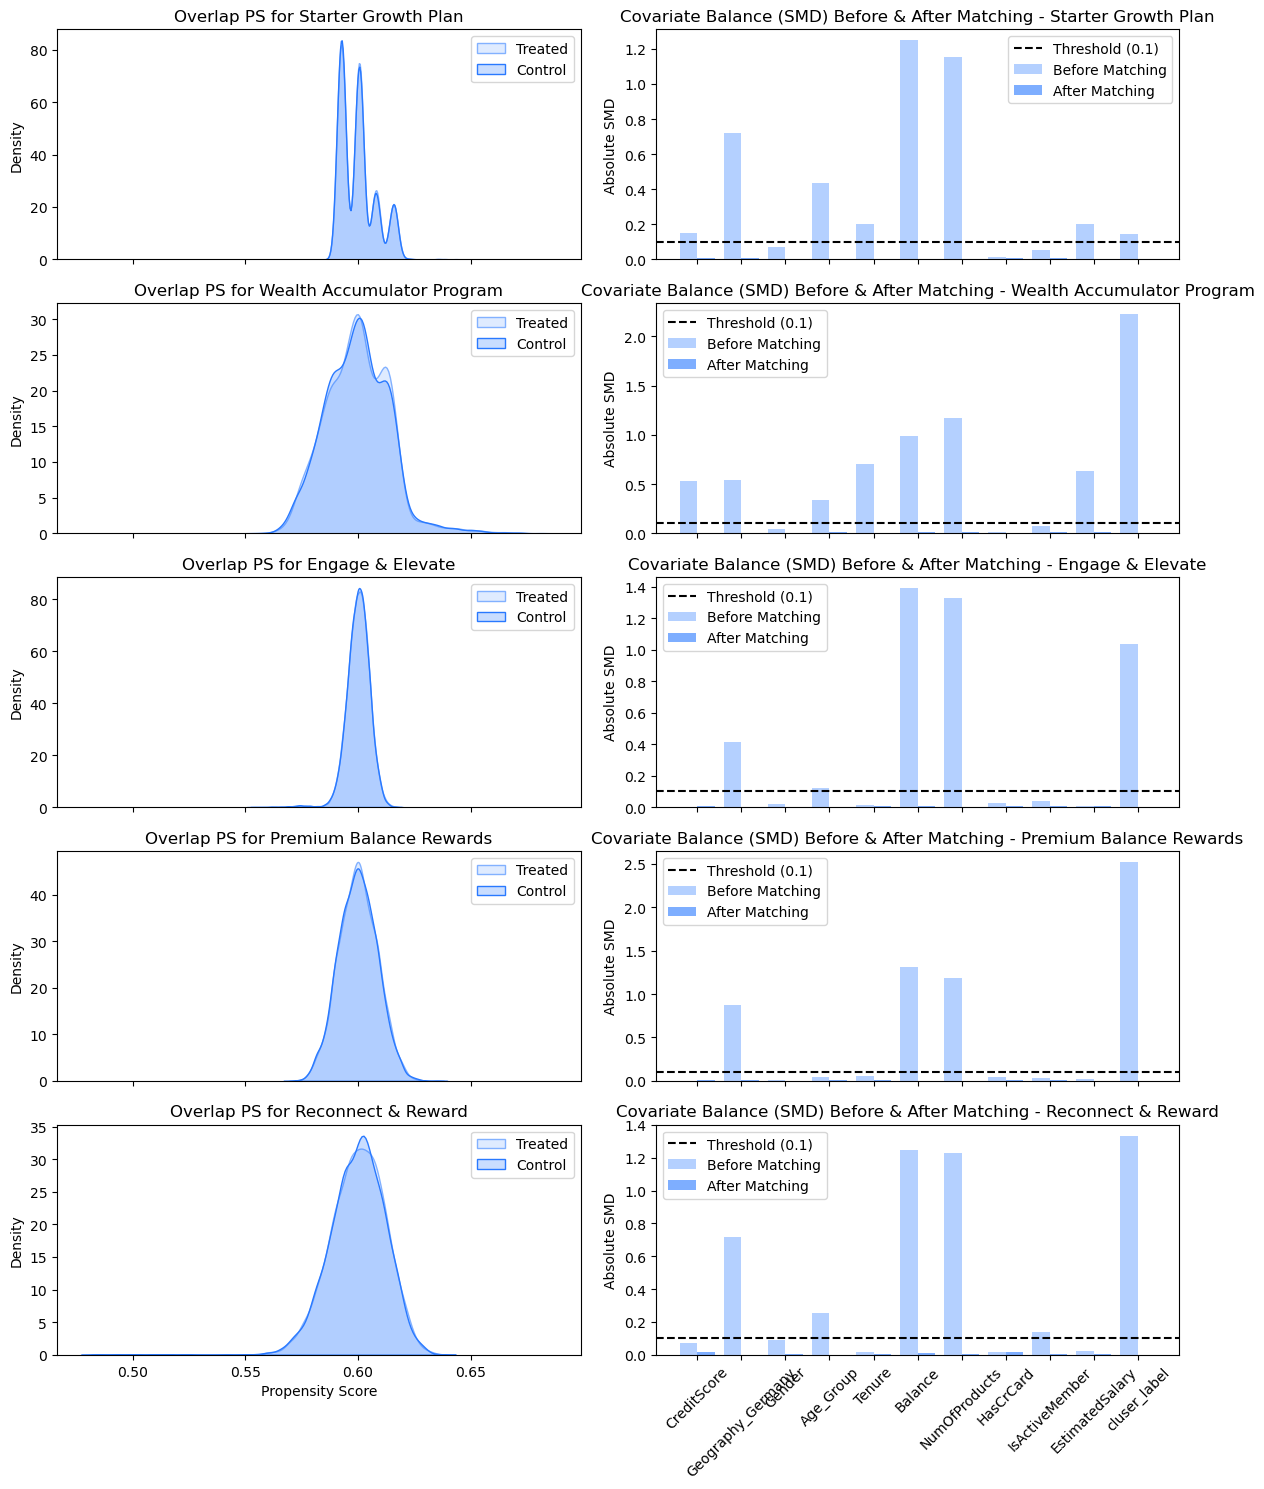

In [204]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Màu sắc mong muốn
color_treated = "#82b1ff"  # Màu xanh dương nhạt
color_control = "#2979ff"  # Màu xanh dương đậm
color_before = "#82b1ff"   # Màu xanh dương nhạt cho Before Matching
color_after = "#2979ff"    # Màu xanh dương đậm cho After Matching

# ---------------------------
# PHẦN 3: Đánh giá cân bằng và trực quan hóa (Biểu đồ Overlap và Balance)
# ---------------------------
# Vẽ biểu đồ phân phối Propensity Score (Overlap) và Covariate Balance (SMD trước & sau Matching)
num_treatments = len(hybrid_results.keys())
fig, axes = plt.subplots(num_treatments, 2, figsize=(12, num_treatments * 3), sharex='col')
if num_treatments == 1:
    axes = np.array([axes])  # Đảm bảo axes là mảng 2 chiều

for i, (treatment, data) in enumerate(hybrid_results.items()):
    # Biểu đồ 1: Overlap Propensity Score của treated và control (trong dataset gốc theo cluster)
    ax_overlap = axes[i, 0]
    sns.kdeplot(data=data[data['treated_indicator'] == 1],
                x='propensity_score', label='Treated', shade=True, ax=ax_overlap, color=color_treated)
    sns.kdeplot(data=data[data['treated_indicator'] == 0],
                x='propensity_score', label='Control', shade=True, ax=ax_overlap, color=color_control)
    ax_overlap.set_title(f'Overlap PS for {treatment}')
    ax_overlap.set_xlabel('Propensity Score')
    ax_overlap.set_ylabel('Density')
    ax_overlap.legend()

    # Biểu đồ 2: So sánh SMD trước và sau Matching
    smd_before = {}
    smd_after = {}

    for var in confounders:
        # Trước Matching
        treated_mean_before = df_train[df_train['Treatment'] == treatment][var].mean()
        control_mean_before = df_train[df_train['Treatment'] == "No Program"][var].mean()
        treated_std_before = df_train[df_train['Treatment'] == treatment][var].std()
        control_std_before = df_train[df_train['Treatment'] == "No Program"][var].std()
        pooled_std_before = np.sqrt((treated_std_before ** 2 + control_std_before ** 2) / 2)
        smd_before[var] = (treated_mean_before - control_mean_before) / pooled_std_before if pooled_std_before != 0 else 0

        # Sau Matching
        treated_mean_after = data[data['treated_indicator'] == 1][var].mean()
        control_mean_after = data[data['treated_indicator'] == 0][var].mean()
        treated_std_after = data[data['treated_indicator'] == 1][var].std()
        control_std_after = data[data['treated_indicator'] == 0][var].std()
        pooled_std_after = np.sqrt((treated_std_after ** 2 + control_std_after ** 2) / 2)
        smd_after[var] = (treated_mean_after - control_mean_after) / pooled_std_after if pooled_std_after != 0 else 0

    # Vẽ biểu đồ cột so sánh SMD trước & sau
    ax_balance = axes[i, 1]
    x_labels = list(smd_before.keys())
    x_positions = np.arange(len(x_labels))

    ax_balance.bar(x_positions - 0.2, np.abs(list(smd_before.values())), width=0.4, label="Before Matching", color=color_before, alpha=0.6)
    ax_balance.bar(x_positions + 0.2, np.abs(list(smd_after.values())), width=0.4, label="After Matching", color=color_after, alpha=0.6)

    ax_balance.axhline(0.1, color='black', linestyle='--', label='Threshold (0.1)')
    ax_balance.set_title(f'Covariate Balance (SMD) Before & After Matching - {treatment}')
    ax_balance.set_ylabel('Absolute SMD')
    ax_balance.set_xticks(x_positions)
    ax_balance.set_xticklabels(x_labels, rotation=45)
    ax_balance.legend()

plt.tight_layout()
plt.show()


In [191]:
# ---------------------------
# PHẦN 4: Tính ATE
# ---------------------------
ate_results = {}

# Lặp qua từng treatment trong hybrid_results
for treatment, data in hybrid_results.items():
    # Lọc nhóm treated và control
    treated_data = data[data['treated_indicator'] == 1]
    control_data = data[data['treated_indicator'] == 0]

    # Tính weighted average của outcome cho nhóm treated và control
    treated_outcome = np.average(treated_data['p_churn_post'], weights=treated_data['IPW Weight'])
    control_outcome = np.average(control_data['p_churn_post'], weights=control_data['IPW Weight'])
    
    # Tính ATE: Sự khác biệt giữa trung bình outcome của treated và control
    ate = treated_outcome - control_outcome
    ate_results[treatment] = ate

# In kết quả ATE cho từng treatment
for treatment, ate in ate_results.items():
    print(f"ATE for treatment '{treatment}': {ate:.4f}")



ATE for treatment 'Starter Growth Plan': -0.0172
ATE for treatment 'Wealth Accumulator Program': -0.0406
ATE for treatment 'Engage & Elevate': -0.0718
ATE for treatment 'Premium Balance Rewards': -0.0479
ATE for treatment 'Reconnect & Reward': -0.0824


In [188]:
hybrid_results

{'Starter Growth Plan':         CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
 0          0.144135       1 -0.719973 -0.883163              2          1   
 1         -0.367706       1 -1.432694 -0.883163              2          1   
 15        -1.341451       0 -0.007253 -0.883163              2          1   
 16        -0.679804       1  0.705467 -0.883163              2          0   
 30        -0.305286       1 -0.007253 -0.883163              2          1   
 ...             ...     ...       ...       ...            ...        ...   
 111887    -1.815840       0 -0.363613 -0.883163              2          1   
 111932    -1.666033       0 -1.432694 -0.883163              2          1   
 111957    -2.614810       0  0.705467 -0.883163              2          1   
 111966    -2.040550       0 -1.076334 -0.883163              2          1   
 111979    -3.001811       0 -1.789054 -0.883163              2          1   
 
         IsActiveMember  EstimatedSalar

In [157]:
# Giả sử hybrid_results là dictionary lưu các DataFrame đã matching cho từng treatment
# Gộp tất cả các DataFrame lại thành một DataFrame df_matched
df_matched = pd.concat(list(hybrid_results.values()), axis=0)

# In thông tin kích thước của df_matched
print("Kích thước của df_matched:", df_matched.shape)
df_matched.head()

Kích thước của df_matched: (132020, 18)


CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0      0.144135       1 -0.719973 -0.883163              2          1   
1     -0.367706       1 -1.432694 -0.883163              2          1   
15    -1.341451       0 -0.007253 -0.883163              2          1   
16    -0.679804       1  0.705467 -0.883163              2          0   
30    -0.305286       1 -0.007253 -0.883163              2          1   

    IsActiveMember  EstimatedSalary  Exited  Age_Group  Geography_Germany  \
0                0         1.369486       0        0.0                0.0   
1                1        -1.254085       0        0.0                0.0   
15               0         0.987938       0        0.0                0.0   
16               1         0.447533       0        0.0                0.0   
30               1        -0.134353       0        0.0                0.0   

       p_pre  cluser_label            Treatment  p_churn_post  \
0   0.024463             2  Starter Growth Plan      0.011536   
1   0.012693             2  Starter Growth Plan      0.012087   
15  0.046823             2  Starter Growth Plan      0.045891   
16  0.017033             2  Starter Growth Plan      0.012242   
30  0.011858             2  Starter Growth Plan      0.005503   

    treated_indicator  propensity_score  IPW Weight  
0                   1          0.600387    1.665592  
1                   1          0.593870    1.683870  
15                  1          0.597780    1.672856  
16                  1          0.607558    1.645934  
30                  1          0.593076    1.686125

In [158]:
treatment_mapping = {
    "No Program": 0,
    "Engage & Elevate": 2,
    "Premium Balance Rewards": 5,
    "Reconnect & Reward": 4,
    "Starter Growth Plan": 3,
    "Wealth Accumulator Program": 1
}
df_matched['Treatment'] = df_matched['Treatment'].map(treatment_mapping)
# Chọn các biến cho causal graph
cols = [
    'CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label',
    'Age_Group', 'Geography_Germany', 'Treatment', 'p_churn_post'
]
df_matched = df_matched[cols]
df_matched


CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0          0.144135       1 -0.719973 -0.883163              2          1   
1         -0.367706       1 -1.432694 -0.883163              2          1   
15        -1.341451       0 -0.007253 -0.883163              2          1   
16        -0.679804       1  0.705467 -0.883163              2          0   
30        -0.305286       1 -0.007253 -0.883163              2          1   
...             ...     ...       ...       ...            ...        ...   
124141     2.416207       1  1.061827 -0.883163              1          0   
127749     1.679656       0  1.418187 -0.883163              1          1   
133830    -0.192931       1  1.774548 -0.883163              3          0   
144724    -0.018156       0  0.349107 -0.883163              1          0   
152528     2.129077       1 -0.363613 -0.883163              3          0   

        IsActiveMember  EstimatedSalary  cluser_label  Age_Group  \
0                    0         1.369486             2        0.0   
1                    1        -1.254085             2        0.0   
15                   0         0.987938             2        0.0   
16                   1         0.447533             2        0.0   
30                   1        -0.134353             2        0.0   
...                ...              ...           ...        ...   
124141               1         1.372680             3        2.0   
127749               0         0.992761             3        0.0   
133830               1        -0.617600             3        2.0   
144724               1        -1.607979             3        0.0   
152528               1        -0.372602             3        0.0   

        Geography_Germany  Treatment  p_churn_post  
0                     0.0          3      0.011536  
1                     0.0          3      0.012087  
15                    0.0          3      0.045891  
16                    0.0          3      0.012242  
30                    0.0          3      0.005503  
...                   ...        ...           ...  
124141                0.0          0      0.445261  
127749                1.0          0      0.916444  
133830                0.0          0      0.928651  
144724                1.0          0      0.384181  
152528                0.0          0      0.622183  

[132020 rows x 13 columns]

In [159]:
df_matched = df_matched.reset_index(drop=True)


# V. Model

In [160]:
# Chọn cột X (bỏ p_churn_post, bỏ cột Treatment, t_code)
feature_cols = [
    'CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label',
    'Age_Group', 'Geography_Germany'
]

X_final = df_matched[feature_cols].copy()
T_raw = df_matched['Treatment'].values  # multi-treatment
y_raw = df_matched['p_churn_post'].values  # outcome liên tục

from sklearn.model_selection import train_test_split

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X_final, T_raw, y_raw, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size: 105616
Test size : 26404


In [161]:
import os
from datetime import datetime
import time
# Đường dẫn file trên Google Drive
csv_path = "/home/ailab1/student_share/Thanh/Data/train_result.csv"

# Nếu file chưa tồn tại, tạo file CSV rỗng
if not os.path.exists(csv_path):
    df_init = pd.DataFrame(columns=["ID", "Mô hình", "Ngày train", "Giờ train", "MAE", "RMSE", "R²", "Thời gian train"])
    df_init.to_csv(csv_path, index=False)


In [162]:
def save_training_results(model_name, mae, rmse, r2, training_time):
    """
    Lưu kết quả training vào file CSV trên Google Drive.
    """
    # Đọc file CSV hiện tại (nếu có)
    if os.path.exists(csv_path):
        df_results = pd.read_csv(csv_path)
    else:
        df_results = pd.DataFrame(columns=["ID", "Mô hình", "Ngày train", "Giờ train", "MAE", "RMSE", "R²", "Thời gian train"])

    # Tạo ID mới
    new_id = len(df_results) + 1

    # Lấy thời gian hiện tại
    now = datetime.now()
    train_date = now.strftime("%Y-%m-%d")
    train_time = now.strftime("%H:%M:%S")

    # Thêm kết quả mới
    new_row = pd.DataFrame([{
        "ID": new_id,
        "Mô hình": model_name,
        "Ngày train": train_date,
        "Giờ train": train_time,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "Thời gian train": training_time
    }])

    # Append vào DataFrame cũ
    df_results = pd.concat([df_results, new_row], ignore_index=True)

    # Lưu lại vào Google Drive
    df_results.to_csv(csv_path, index=False)
    print(f"✅ Kết quả training đã được lưu vào {csv_path}")


In [163]:
!pip install econml
# !pip install scikit-learn==1.4.2


In [164]:
import sklearn.utils.fixes
if not hasattr(sklearn.utils.fixes, '_IS_PYPY'):
    sklearn.utils.fixes._IS_PYPY = False

## 5.1 Mô hình 1: DR Learner (multi-treatment)


In [165]:
import time

from econml.dr import DRLearner
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from dowhy import CausalModel

In [166]:
import time
import xgboost as xgb
from econml.dr import DRLearner  # hoặc import DRLearner theo cách bạn sử dụng

# ---------------------------------------------------
# 1) Khởi tạo mô hình DR Learner sử dụng XGBoost (GPU)
# ---------------------------------------------------
model_regression = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    tree_method='gpu_hist',  # Sử dụng GPU
    random_state=42
)

model_propensity = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    tree_method='gpu_hist',  # Sử dụng GPU
    random_state=42
)

drl = DRLearner(
    model_regression=model_regression,
    model_propensity=model_propensity,
    cv=5,
    discrete_outcome=False,
    random_state=42
)

# ---------------------------------------------------
# 2) Huấn luyện DR Learner
# ---------------------------------------------------
start_time = time.time()
drl.fit(y_train, T_train, X=X_train)
end_time = time.time()
training_time_drl = round(end_time - start_time, 2)
print(f"=> Đã train xong DRLearner. Thời gian: {training_time_drl} s")


=> Đã train xong DRLearner. Thời gian: 6.38 s


In [167]:
# ---------------------------------------------------
# 3) Ước lượng counterfactual outcomes cho các treatment
# ---------------------------------------------------
# treatment_mapping = {
#     "No Program": 0,
#     "Engage & Elevate": 2,
#     "Premium Balance Rewards": 5,
#     "Reconnect & Reward": 4,
#     "Starter Growth Plan": 3,
#     "Wealth Accumulator Program": 1
# }
mask_baseline = (T_train == 0)
X_train_baseline = X_train[mask_baseline]
y_train_baseline = y_train[mask_baseline]

baseline_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
)
baseline_model.fit(X_train_baseline, y_train_baseline)
yhat_0_test = baseline_model.predict(X_test)

unique_treats = np.unique(T_train)
unique_treats
cf_outcomes = {}

for t_val in unique_treats:
    tau_0_tval = drl.effect(X_test, T0=0, T1=t_val)
    yhat_tval = yhat_0_test + tau_0_tval
    cf_outcomes[t_val] = yhat_tval


In [168]:
# ---------------------------------------------------
# 4) Ước tính outcome nếu không tham gia chương trình (No Program)
# ---------------------------------------------------
no_treatment_model = xgb.XGBRegressor(
    tree_method='gpu_hist',        # Sử dụng thuật toán GPU
    predictor='gpu_predictor',     # Sử dụng GPU cho dự đoán
    gpu_id=0                       # Chọn GPU, nếu có nhiều GPU bạn có thể thay đổi
)

no_treatment_model.fit(X_train, y_train)
yhat_no_treatment_test = no_treatment_model.predict(X_test)


In [169]:
# ---------------------------------------------------
# 5) Chọn treatment tối ưu cho mỗi khách hàng
# ---------------------------------------------------
# treatment_mapping = {
#     "No Program": 0,
#     "Engage & Elevate": 2,
#     "Premium Balance Rewards": 5,
#     "Reconnect & Reward": 4,
#     "Starter Growth Plan": 3,
#     "Wealth Accumulator Program": 1
# }
df_preds = pd.DataFrame({
    'pred_NoProgram': yhat_no_treatment_test,                   # Baseline: No Program
    'pred_WealthAccumulator': cf_outcomes[1],
    'pred_EngageElevate': cf_outcomes[2],
    'pred_StarterGrowth': cf_outcomes[3],
    'pred_ReconnectReward': cf_outcomes[4],
    'pred_PremiumBalance': cf_outcomes[5]
})

def choose_optimal(row):
    outcomes = [
        row['pred_NoProgram'],
        row['pred_WealthAccumulator'],
        row['pred_EngageElevate'],
        row['pred_StarterGrowth'],
        row['pred_ReconnectReward'],
        row['pred_PremiumBalance']
    ]
    idx = np.argmin(outcomes)  # hoặc argmax nếu outcome cao hơn là tốt hơn
    return ["No Program", "Wealth Accumulator Program", "Engage & Elevate", 
            "Starter Growth Plan", "Reconnect & Reward", "Premium Balance Rewards"][idx]

df_preds['treatment_new'] = df_preds.apply(choose_optimal, axis=1)
df_preds['y_test'] = y_test
df_preds['T_test'] = T_test
print("\n=== Một vài sample counterfactual outcomes & new treatment recommendation ===")
df_preds


=== Một vài sample counterfactual outcomes & new treatment recommendation ===


pred_NoProgram  pred_WealthAccumulator  pred_EngageElevate  \
0            0.106109                0.147728            0.088637   
1            0.080505                0.110709            0.036572   
2            0.059580                0.080325            0.073796   
3            0.074238                0.102216            0.043057   
4            0.071171                0.123393            0.054662   
...               ...                     ...                 ...   
26399        0.214719                0.208172            0.220598   
26400        0.050890                0.036973            0.039965   
26401        0.385163                0.415052            0.376635   
26402        0.071902                0.043685            0.039021   
26403        0.795523                0.705181            0.749878   

       pred_StarterGrowth  pred_ReconnectReward  pred_PremiumBalance  \
0                0.137760              0.071787             0.123947   
1                0.107284              0.089583             0.103354   
2                0.081034              0.076344             0.033449   
3                0.108130              0.088793             0.104183   
4                0.124590              0.111044             0.119510   
...                   ...                   ...                  ...   
26399            0.238151              0.286892             0.218274   
26400            0.041282              0.042790             0.049208   
26401            0.441843              0.418935             0.396087   
26402            0.040396              0.049166             0.054408   
26403            0.715371              0.787563             0.709036   

                    treatment_new    y_test  T_test  
0              Reconnect & Reward  0.187335       0  
1                Engage & Elevate  0.070686       0  
2         Premium Balance Rewards  0.013100       5  
3                Engage & Elevate  0.044416       2  
4                Engage & Elevate  0.037290       2  
...                           ...       ...     ...  
26399  Wealth Accumulator Program  0.068594       0  
26400  Wealth Accumulator Program  0.089257       0  
26401            Engage & Elevate  0.445730       0  
26402            Engage & Elevate  0.014207       0  
26403  Wealth Accumulator Program  0.858569       2  

[26404 rows x 9 columns]

In [170]:
# ---------------------------------------------------
# 6) Đánh giá độ chính xác của DRLearner
# ---------------------------------------------------
y_pred_drl_factual = np.zeros_like(y_test, dtype=float)
for i, t_i in enumerate(T_test):
    y_pred_drl_factual[i] = cf_outcomes[t_i][i]

mae_drl  = mean_absolute_error(y_test, y_pred_drl_factual)
rmse_drl = np.sqrt(mean_squared_error(y_test, y_pred_drl_factual))
r2_drl   = r2_score(y_test, y_pred_drl_factual)

print("\n=== Đánh giá DRLearner ===")
print(f"MAE:  {mae_drl:.4f}")
print(f"RMSE: {rmse_drl:.4f}")
print(f"R²:   {r2_drl:.4f}")


=== Đánh giá DRLearner ===
MAE:  0.0654
RMSE: 0.1018
R²:   0.8362


In [ ]:
# Bảng ánh xạ từ chỉ số treatment (0,1,2,3,4,5) sang tên chương trình
reverse_treatment_mapping = {
    0: "No Program",
    1: "Wealth Accumulator",
    2: "Engage Elevate",
    3: "Starter Growth",
    4: "Reconnect Reward",
    5: "Premium Balance"
}

# Mapping từ tên treatment sang tên cột trong DataFrame
treatment_mapping = {
    "No Program": "pred_NoProgram",
    "Wealth Accumulator": "pred_WealthAccumulator",
    "Engage Elevate": "pred_EngageElevate",
    "Starter Growth": "pred_StarterGrowth",
    "Reconnect Reward": "pred_ReconnectReward",
    "Premium Balance": "pred_PremiumBalance"
}

# Sắp xếp DataFrame theo cluster_label để đảm bảo xử lý theo thứ tự
df_preds["cluster_label"] = X_test["cluser_label"].values
df_preds_sorted = df_preds.sort_values(by=['cluster_label'])

print("\n=== ATE theo treatment thực tế ban đầu (Initial ATE) in Test Dataset ===")
for t_val in df_preds_sorted['T_test'].unique():
    group = df_preds_sorted[df_preds_sorted['T_test'] == t_val]  # Lọc nhóm khách hàng nhận treatment ban đầu là `t_val`
    
    baseline = group["pred_NoProgram"]  # Churn dự báo khi không có chương trình
    treatment_name = reverse_treatment_mapping.get(t_val, "Unknown")  # Lấy tên chương trình từ `T_test`

    if treatment_name != "No Program":  # Bỏ qua "No Program" vì đó là baseline
        # Lấy tên cột đúng từ treatment_mapping
        treatment_col = treatment_mapping.get(treatment_name, None)
        
        if treatment_col and treatment_col in group.columns:  # Kiểm tra cột có tồn tại không
            treated_outcome = group[treatment_col]  # Churn dự báo khi nhận treatment thực tế
            percent_reduction = ((baseline - treated_outcome) / baseline * 100).mean()

            # In kết quả kèm thông tin cluster
            for cluster_id in sorted(group['cluster_label'].unique()):
                cluster_group = group[group['cluster_label'] == cluster_id]
                cluster_reduction = ((cluster_group["pred_NoProgram"] - cluster_group[treatment_col]) /
                                     cluster_group["pred_NoProgram"] * 100).mean()
                print(f"  📌 Treatment: {treatment_name}  🔹 Cluster {cluster_id}: Giảm trung bình {cluster_reduction:.2f}% so với No Program")
        else:
            print(f"⚠️ Cột {treatment_col} không tồn tại trong DataFrame.")
    else:
        print("\n📌 Treatment No Program: Đây là baseline, không có so sánh ATE.")



=== ATE theo treatment thực tế ban đầu (Initial ATE) ===

📌 Treatment No Program: Đây là baseline, không có so sánh ATE.
  📌 Treatment: Wealth Accumulator  🔹 Cluster 0: Giảm trung bình 16.03% so với No Program
  📌 Treatment: Engage Elevate  🔹 Cluster 1: Giảm trung bình 18.83% so với No Program
  📌 Treatment: Starter Growth  🔹 Cluster 2: Giảm trung bình 0.58% so với No Program
  📌 Treatment: Reconnect Reward  🔹 Cluster 3: Giảm trung bình 10.73% so với No Program
  📌 Treatment: Premium Balance  🔹 Cluster 4: Giảm trung bình 17.10% so với No Program


In [173]:
# ---------------------------------------------------
# 7) Tính ATE theo nhóm treatment_new (so sánh với No Program)
# ---------------------------------------------------
# Sắp xếp DataFrame theo cluster_label để đảm bảo xử lý theo thứ tự
treatment_mapping = {
    "No Program": "pred_NoProgram",
    "Wealth Accumulator Program": "pred_WealthAccumulator",
    "Engage & Elevate": "pred_EngageElevate",
    "Starter Growth Plan": "pred_StarterGrowth",
    "Reconnect & Reward": "pred_ReconnectReward",
    "Premium Balance Rewards": "pred_PremiumBalance"
}
df_preds_sorted = df_preds.sort_values(by=['cluster_label'])

print("\n=== ATE theo new treatment recommendations (Final ATE) ===")
for tr in df_preds_sorted['treatment_new'].unique():
    group = df_preds_sorted[df_preds_sorted['treatment_new'] == tr]  # Lọc nhóm khách hàng có treatment được khuyến nghị
    
    baseline = group[treatment_mapping["No Program"]]  # Churn dự báo khi không có chương trình

    if tr != "No Program":  # Bỏ qua "No Program" vì đó là baseline
        treatment_col = treatment_mapping[tr]  # Cột churn dự báo khi có treatment
        percent_reduction = ((baseline - group[treatment_col]) / baseline * 100).mean()

        # In kết quả tổng hợp theo treatment
        print(f"\n📌 Treatment: {tr}")
        
        # Duyệt theo từng cluster
        for cluster_id in sorted(group['cluster_label'].unique()):
            cluster_group = group[group['cluster_label'] == cluster_id]
            cluster_reduction = ((cluster_group["pred_NoProgram"] - cluster_group[treatment_col]) /
                                 cluster_group["pred_NoProgram"] * 100).mean()
            print(f"    🔹 Cluster {cluster_id}: Giảm trung bình {cluster_reduction:.2f}% so với No Program")
        
        print(f"⚡ Tổng: {tr} giúp giảm trung bình {percent_reduction:.2f}% so với No Program\n")

    else:
        print("\n📌 Treatment No Program: Đây là baseline, không có so sánh ATE.")




=== ATE theo new treatment recommendations (Final ATE) ===

📌 Treatment: Wealth Accumulator Program
    🔹 Cluster 0: Giảm trung bình 29.97% so với No Program
    🔹 Cluster 1: Giảm trung bình 8.78% so với No Program
    🔹 Cluster 2: Giảm trung bình 27.98% so với No Program
    🔹 Cluster 3: Giảm trung bình 4.58% so với No Program
    🔹 Cluster 4: Giảm trung bình 6.14% so với No Program
⚡ Tổng: Wealth Accumulator Program giúp giảm trung bình 27.81% so với No Program


📌 Treatment: Engage & Elevate
    🔹 Cluster 0: Giảm trung bình 42.87% so với No Program
    🔹 Cluster 1: Giảm trung bình 21.17% so với No Program
    🔹 Cluster 2: Giảm trung bình 34.44% so với No Program
    🔹 Cluster 3: Giảm trung bình 8.64% so với No Program
    🔹 Cluster 4: Giảm trung bình 13.90% so với No Program
⚡ Tổng: Engage & Elevate giúp giảm trung bình 23.05% so với No Program


📌 Treatment No Program: Đây là baseline, không có so sánh ATE.

📌 Treatment: Reconnect & Reward
    🔹 Cluster 2: Giảm trung bình 62.40% s


Running Random Common Cause...

Running Unobserved Common Cause...


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


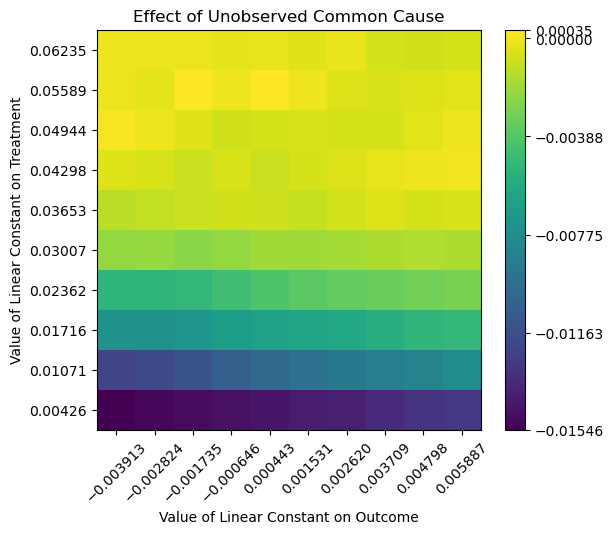


Running Placebo Treatment...

Running Data Subset Refuter...

=== Kết quả Refutation Tests ===
                      Test  Estimated Effect  \
0      Random Common Cause           -0.0155   
1  Unobserved Common Cause           -0.0155   
2        Placebo Treatment           -0.0155   
3      Data Subset Refuter           -0.0155   

                                       New Effect  
0                                       -0.015501  
1  (-0.015458899059444114, 0.0003486442936276035)  
2                                       -0.000008  
3                                       -0.015456  


In [35]:
# ---------------------------------------------------
# 8) **Bổ sung Refutation Tests**
# ---------------------------------------------------
X_test_reset = X_test.reset_index(drop=True)
T_test_reset = pd.Series(T_test).reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

causal_model = CausalModel(
    data=pd.concat([X_test_reset, pd.DataFrame({"T": T_test_reset, "y": y_test_reset})], axis=1),
    treatment="T",
    outcome="y",
    common_causes=X_test_reset.columns.tolist()
)

identified_estimand = causal_model.identify_effect()
estimate = causal_model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)

def run_refutation_tests(model, identified_estimand, estimate):
    results = []
    tests = {
        "Random Common Cause": "random_common_cause",
        "Unobserved Common Cause": "add_unobserved_common_cause",
        "Placebo Treatment": "placebo_treatment_refuter",
        "Data Subset Refuter": "data_subset_refuter"
    }

    for name, method in tests.items():
        print(f"\nRunning {name}...")
        
        # Xử lý các tham số riêng của từng phương pháp
        kwargs = {}
        if method == "add_unobserved_common_cause":
            kwargs = {
                "confounders_effect_on_treatment": "binary_flip",
                "confounders_effect_on_outcome": "linear",
                "effect_fraction_on_treatment": 0.05,  # Giảm xuống để tránh lỗi alpha
                "effect_fraction_on_outcome": 0.05
            }
        elif method == "placebo_treatment_refuter":
            kwargs = {
                "placebo_type": "permute",
                "num_simulations": 100,
                "n_jobs": 16,
                "model": "logistic",
                "max_iter": 500  # Tăng số vòng lặp để tránh lỗi hội tụ
            }
        
        # Chạy Refutation Test
        res = model.refute_estimate(identified_estimand, estimate, method_name=method, **kwargs)
        results.append({
            "Test": name,
            "Estimated Effect": res.estimated_effect,
            "New Effect": res.new_effect
        })

    return pd.DataFrame(results)

# Chạy kiểm định ý nghĩa
refutation_results = run_refutation_tests(causal_model, identified_estimand, estimate)
print("\n=== Kết quả Refutation Tests ===")
print(refutation_results)


/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarnin

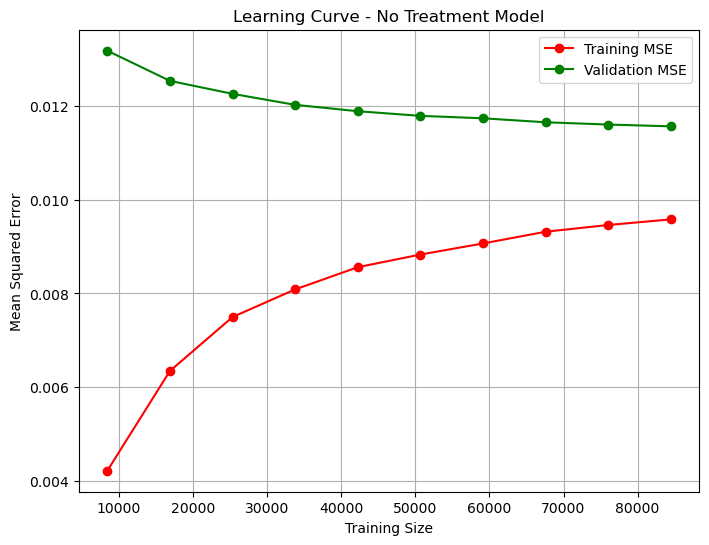

In [36]:
# ---------------------------------------------------
# 9) Vẽ biểu đồ Learning Curve cho No-Treatment Model
# ---------------------------------------------------
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=no_treatment_model,
    X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1  # Sử dụng tất cả các cores có sẵn
)

train_errors_mean = -np.mean(train_scores, axis=1)
validation_errors_mean = -np.mean(validation_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors_mean, 'o-', color="r", label="Training MSE")
plt.plot(train_sizes, validation_errors_mean, 'o-', color="g", label="Validation MSE")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve - No Treatment Model")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import os
# ---------------------------------------------------
# 10) Lưu kết quả training
# ---------------------------------------------------
save_training_results("DR Learner", mae_drl, rmse_drl, r2_drl, training_time_drl)

✅ Kết quả training đã được lưu vào /home/ailab1/student_share/Thanh/Data/train_result.csv


## 5.2 Mô hình 2: Causal Forest - ForestDRLearner (multi-treatment bằng cách lặp qua từng cặp (t vs. baseline))


In [ ]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X_final, T_raw, y_raw, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

In [ ]:
from econml.dr import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from dowhy import CausalModel

In [ ]:
# ----------------------------
# 1) Khởi tạo ForestDRLearner
# ----------------------------
model_regression = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
)
model_propensity = GradientBoostingClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
)
f_drl = ForestDRLearner(
    model_regression=model_regression,
    model_propensity=model_propensity,
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=10,
    cv=5,
    random_state=42
)

# ----------------------------
# 2) Huấn luyện ForestDRLearner
# ----------------------------
start_time = time.time()
f_drl.fit(y_train, T_train, X=X_train)
end_time = time.time()
training_time_cforest = round(end_time - start_time, 2)
print(f"=> Train xong ForestDRLearner (multi-treatment). Thời gian: {training_time_cforest}s")

In [ ]:
# ----------------------------
# 3) Ước lượng counterfactual outcomes cho các treatment (0..4)
# ----------------------------
mask_baseline = (T_train == 0)
X_train_baseline = X_train[mask_baseline]
y_train_baseline = y_train[mask_baseline]

baseline_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
)
baseline_model.fit(X_train_baseline, y_train_baseline)
yhat_0_test = baseline_model.predict(X_test)

unique_treats = np.unique(T_train)
cf_outcomes = {}
for t_val in unique_treats:
    tau_0_tval = f_drl.effect(X_test, T0=0, T1=t_val)
    yhat_tval = yhat_0_test + tau_0_tval
    cf_outcomes[t_val] = yhat_tval

In [ ]:
# ----------------------------
# 4) Dự đoán factual theo treatment thực tế (T_test)
# ----------------------------
y_pred_cf_factual = np.zeros_like(y_test, dtype=float)
for i, t_i in enumerate(T_test):
    y_pred_cf_factual[i] = cf_outcomes[t_i][i]

In [ ]:
# ----------------------------
# 5) Đánh giá ForestDRLearner (dựa trên factual prediction)
# ----------------------------
mae_cf = mean_absolute_error(y_test, y_pred_cf_factual)
rmse_cf = np.sqrt(mean_squared_error(y_test, y_pred_cf_factual))
r2_cf = r2_score(y_test, y_pred_cf_factual)

print("\n=== Đánh giá ForestDRLearner (multi-treatment) ===")
print(f"MAE:  {mae_cf:.4f}")
print(f"RMSE: {rmse_cf:.4f}")
print(f"R²:   {r2_cf:.4f}")

In [ ]:
# ---------------------------------------------------
# 7) Tính ATE theo nhóm treatment_new (so sánh với No Program)
# ---------------------------------------------------
print("\n=== ATE theo new treatment recommendations ===")
for tr in df_preds['treatment_new'].unique():
    group = df_preds[df_preds['treatment_new'] == tr]
    pred_baseline = group['pred_NoTreatment']
    if tr != "No Program":
        pred_treatment = group[f'pred_T{tr}']
        percent_reduction = ((pred_baseline - pred_treatment) / pred_baseline * 100).mean()
        print(f"Treatment {tr}: Giảm trung bình {percent_reduction:.2f}% so với No Program")

In [ ]:
# ----------------------------
# 6) Ước tính outcome cho “No Program” (không áp dụng chương trình)
# ----------------------------
no_treatment_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
)
no_treatment_model.fit(X_train, y_train)
yhat_no_treatment_test = no_treatment_model.predict(X_test)

In [ ]:
# ----------------------------
# 7) Chọn treatment tối ưu cho mỗi khách hàng (bao gồm “No Program”)
# ----------------------------
df_preds = pd.DataFrame({
    'pred_T0': cf_outcomes[0],
    'pred_T1': cf_outcomes[1],
    'pred_T2': cf_outcomes[2],
    'pred_T3': cf_outcomes[3],
    'pred_T4': cf_outcomes[4],
    'pred_NoTreatment': yhat_no_treatment_test,
})

def choose_optimal(row):
    outcomes = [row['pred_T0'], row['pred_T1'], row['pred_T2'], row['pred_T3'], row['pred_T4'], row['pred_NoTreatment']]
    idx = np.argmin(outcomes)
    return "No Program" if idx == 5 else idx  

df_preds['treatment_new'] = df_preds.apply(choose_optimal, axis=1)
df_preds['y_test'] = y_test
df_preds['T_test'] = T_test
print("\n=== Một vài sample counterfactual outcomes & new treatment recommendation ===")
df_preds

In [ ]:
# ----------------------------
# 8) Thực hiện Refutation Tests
# ----------------------------
X_test_reset = X_test.reset_index(drop=True)
T_test_reset = pd.Series(T_test).reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

causal_model = CausalModel(
    data=pd.concat([X_test_reset, pd.DataFrame({"T": T_test_reset, "y": y_test_reset})], axis=1),
    treatment="T",
    outcome="y",
    common_causes=X_test_reset.columns.tolist()
)

identified_estimand = causal_model.identify_effect()
estimate = causal_model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)

def run_refutation_tests(model, identified_estimand, estimate):
    results = []
    tests = {
        "Random Common Cause": "random_common_cause",
        "Unobserved Common Cause": "add_unobserved_common_cause",
        "Placebo Treatment": "placebo_treatment_refuter",
        "Data Subset Refuter": "data_subset_refuter"
    }

    for name, method in tests.items():
        print(f"\nRunning {name}...")
        
        # Xử lý các tham số riêng của từng phương pháp
        kwargs = {}
        if method == "add_unobserved_common_cause":
            kwargs = {
                "confounders_effect_on_treatment": "binary_flip",
                "confounders_effect_on_outcome": "linear",
                "effect_fraction_on_treatment": 0.05,  # Giảm xuống để tránh lỗi alpha
                "effect_fraction_on_outcome": 0.05
            }
        elif method == "placebo_treatment_refuter":
            kwargs = {
                "placebo_type": "permute",
                "num_simulations": 100,
                "n_jobs": 16,
                "model": "logistic",
                "max_iter": 500  # Tăng số vòng lặp để tránh lỗi hội tụ
            }
        
        # Chạy Refutation Test
        res = model.refute_estimate(identified_estimand, estimate, method_name=method, **kwargs)
        results.append({
            "Test": name,
            "Estimated Effect": res.estimated_effect,
            "New Effect": res.new_effect
        })

    return pd.DataFrame(results)

# Chạy kiểm định ý nghĩa
refutation_results = run_refutation_tests(causal_model, identified_estimand, estimate)
print("\n=== Kết quả Refutation Tests ===")
print(refutation_results)


In [ ]:
# ----------------------------
# 9) Vẽ Learning Curve cho no_treatment_model
# ----------------------------
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=no_treatment_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error'
)

train_errors_mean = -np.mean(train_scores, axis=1)
validation_errors_mean = -np.mean(validation_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors_mean, 'o-', color="r", label="Training MSE")
plt.plot(train_sizes, validation_errors_mean, 'o-', color="g", label="Validation MSE")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve - No Treatment Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ----------------------------
# 10) Lưu kết quả training
# ----------------------------
save_training_results("ForestDRLearner", mae_cf, rmse_cf, r2_cf, training_time_cforest)

## 5.3 Mô hình 3: SNet (multi-head NN) cho multi-treatment


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dowhy import CausalModel

In [ ]:
# ============== 1) CHUẨN BỊ DỮ LIỆU ==============
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X_final, T_raw, y_raw, test_size=0.2, random_state=42
)
X_tr, X_val, T_tr, T_val, y_tr, y_val = train_test_split(
    X_train, T_train, y_train, test_size=0.2, random_state=999
)

# Convert sang torch.Tensor
def to_tensor(data, dtype=torch.float32):
    return torch.tensor(data.values if hasattr(data, 'values') else data, dtype=dtype)

X_tr_torch, X_val_torch, X_test_torch = map(to_tensor, [X_tr, X_val, X_test])
T_tr_torch, T_val_torch, T_test_torch = map(lambda x: to_tensor(x, dtype=torch.long), [T_tr, T_val, T_test])
y_tr_torch, y_val_torch, y_test_torch = map(lambda x: to_tensor(x).view(-1, 1), [y_tr, y_val, y_test])

In [ ]:
# ============== 2) ĐỊNH NGHĨA MÔ HÌNH SNET (MULTI-HEAD) ==============
class SNetMulti(nn.Module):
    def __init__(self, input_dim, num_treats, hidden_dim=64, dropout=0.2):
        super(SNetMulti, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            ) for _ in range(num_treats)
        ])

    def forward(self, x, t=None):
        rep = self.shared(x)
        outs = torch.cat([head(rep) for head in self.heads], dim=1)
        return outs if t is None else (outs.gather(1, t.view(-1, 1)), outs)

# ============== 3) HÀM TRAIN VỚI EARLY STOPPING ==============
def train_snet(model, X_tr, T_tr, y_tr, X_val, T_val, y_val,
               n_epochs=100, batch_size=64, lr=1e-3, patience=5, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Chuyển dữ liệu sang GPU/CPU tuỳ 'device'
    X_tr, T_tr, y_tr = X_tr.to(device), T_tr.to(device), y_tr.to(device)
    X_val, T_val, y_val = X_val.to(device), T_val.to(device), y_val.to(device)

    best_val_loss = np.inf
    no_improve_count = 0
    train_losses = []
    val_losses = []
    n_train = X_tr.size(0)
    
    for epoch in range(n_epochs):
        model.train()
        perm_idx = torch.randperm(n_train, device=device)
        running_loss = 0.0
        
        for i in range(0, n_train, batch_size):
            idx = perm_idx[i:i+batch_size]
            Xb = X_tr[idx]
            Tb = T_tr[idx]
            yb = y_tr[idx]
            
            optimizer.zero_grad()
            # Forward
            pred_factual, _ = model(Xb, Tb)
            loss = criterion(pred_factual, yb)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * Xb.size(0)
        
        train_epoch_loss = running_loss / n_train
        train_losses.append(train_epoch_loss)
        
        model.eval()
        with torch.no_grad():
            pred_val, _ = model(X_val, T_val)
            val_loss = criterion(pred_val, y_val).item()
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0
            best_model_state = model.state_dict()
        else:
            no_improve_count += 1
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, TrainLoss={train_epoch_loss:.4f}, ValLoss={val_loss:.4f}")
        
        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch+1} (ValLoss={val_loss:.4f} không cải thiện)")
            break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses


In [ ]:
# ============== 4) TRAIN MÔ HÌNH SNETMULTI ==============
num_treats, input_dim = len(np.unique(T_train)), X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_snet = SNetMulti(input_dim, num_treats).to(device)

start_time = time.time()
model_snet, train_losses, val_losses = train_snet(
    model_snet, X_tr_torch, T_tr_torch, y_tr_torch, 
    X_val_torch, T_val_torch, y_val_torch,
    device=device
)
training_time_snet = round(time.time() - start_time, 2)


In [ ]:
# ============== 5) KIỂM TRA TRÊN TẬP TEST ==============
model_snet.eval()
with torch.no_grad():
    pred_factual_test, pred_all_test = model_snet(X_test_torch, T_test_torch)
    y_pred_snet_factual = pred_factual_test.squeeze().cpu().numpy()


In [ ]:
# ============== 6) TÍNH METRICS ==============
mae_snet = mean_absolute_error(y_test, y_pred_snet_factual)
rmse_snet = np.sqrt(mean_squared_error(y_test, y_pred_snet_factual))
r2_snet = r2_score(y_test, y_pred_snet_factual)
print(f"MAE : {mae_snet:.4f}, RMSE: {rmse_snet:.4f}, R²: {r2_snet:.4f}")

In [ ]:
# ---------------------------------------------------
# 7) Tính ATE theo nhóm treatment_new (so sánh với No Program)
# ---------------------------------------------------
print("\n=== ATE theo new treatment recommendations ===")
for tr in df_preds['treatment_new'].unique():
    group = df_preds[df_preds['treatment_new'] == tr]
    pred_baseline = group['pred_NoTreatment']
    if tr != "No Program":
        pred_treatment = group[f'pred_T{tr}']
        percent_reduction = ((pred_baseline - pred_treatment) / pred_baseline * 100).mean()
        print(f"Treatment {tr}: Giảm trung bình {percent_reduction:.2f}% so với No Program")

In [ ]:
# ============== 7) BỔ SUNG REFUTATION TESTS ==============
X_test_reset = X_test.reset_index(drop=True)
T_test_reset = pd.Series(T_test).reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

causal_model = CausalModel(
    data=pd.concat([X_test_reset, pd.DataFrame({"T": T_test_reset, "y": y_test_reset})], axis=1),
    treatment="T",
    outcome="y",
    common_causes=X_test_reset.columns.tolist()
)
identified_estimand = causal_model.identify_effect()
estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

def run_refutation_tests(model, identified_estimand, estimate):
    results = []
    tests = {
        "Random Common Cause": "random_common_cause",
        "Unobserved Common Cause": "add_unobserved_common_cause",
        "Placebo Treatment": "placebo_treatment_refuter",
        "Data Subset Refuter": "data_subset_refuter"
    }

    for name, method in tests.items():
        print(f"\nRunning {name}...")
        
        # Xử lý các tham số riêng của từng phương pháp
        kwargs = {}
        if method == "add_unobserved_common_cause":
            kwargs = {
                "confounders_effect_on_treatment": "binary_flip",
                "confounders_effect_on_outcome": "linear",
                "effect_fraction_on_treatment": 0.05,  # Giảm xuống để tránh lỗi alpha
                "effect_fraction_on_outcome": 0.05
            }
        elif method == "placebo_treatment_refuter":
            kwargs = {
                "placebo_type": "permute",
                "num_simulations": 100,
                "n_jobs": 16,
                "model": "logistic",
                "max_iter": 500  # Tăng số vòng lặp để tránh lỗi hội tụ
            }
        
        # Chạy Refutation Test
        res = model.refute_estimate(identified_estimand, estimate, method_name=method, **kwargs)
        results.append({
            "Test": name,
            "Estimated Effect": res.estimated_effect,
            "New Effect": res.new_effect
        })

    return pd.DataFrame(results)

# Chạy kiểm định ý nghĩa
refutation_results = run_refutation_tests(causal_model, identified_estimand, estimate)
print("\n=== Kết quả Refutation Tests ===")
print(refutation_results)


In [ ]:
# ============== 8) CHỌN TREATMENT TỐI ƯU ==============
with torch.no_grad():
    pred_all_np = model_snet(X_test_torch).cpu().numpy()

df_preds = pd.DataFrame({f"pred_T{t}": pred_all_np[:, t] for t in range(num_treats)})
df_preds["pred_NoTreatment"] = GradientBoostingRegressor().fit(X_train, y_train).predict(X_test)
df_preds["treatment_new"] = df_preds.apply(lambda row: "No Program" if np.argmin(row.values) == num_treats else np.argmin(row.values), axis=1)


In [ ]:
df_preds

In [ ]:
# ============== 9) VẼ ĐỒ THỊ TRAIN/VAL LOSS ==============
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('SNetMulti: Train vs. Val Loss'); plt.legend(); plt.show()

In [ ]:
# ============== 10) LƯU KẾT QUẢ ==============
save_training_results("SNet-EarlyStop", mae_snet, rmse_snet, r2_snet, training_time_snet)

## 5.4 TMLE

In [ ]:
# !pip install zepid

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split, learning_curve
# from zepid.causal.doublyrobust.TMLE import TMLE
# from dowhy import CausalModel

In [ ]:
# # ----------------------------
# # 0) CHUẨN BỊ DỮ LIỆU
# # ----------------------------
# # Chọn cột X (bỏ p_churn_post, bỏ cột Treatment, t_code)
# feature_cols = [
#     'CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 
#     'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label',
#     'Age_Group', 'Geography_Germany'
# ]

# X_final = df_matched[feature_cols].copy()
# T_raw = df_matched['Treatment'].values  # multi-treatment
# y_raw = df_matched['p_churn_post'].values  # outcome liên tục

# from sklearn.model_selection import train_test_split

# X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
#     X_final, T_raw, y_raw, test_size=0.2, random_state=42
# )

In [ ]:
# # ----------------------------
# # 1) Phân chia dữ liệu huấn luyện theo cluster
# # ----------------------------
# # Giả sử cột "cluser_label" xác định cluster
# clusters = X_train['cluser_label'].unique()
# print("Các cluster:", clusters)

# # Tạo dictionary lưu các mô hình TMLE theo cluster cho từng treatment
# # Cấu trúc: cluster_models[cluster][t] = TMLE model (đã fit) cho pairwise (baseline T=0 vs treatment=t)
# cluster_tmle_models = {}  
# # Đồng thời lưu baseline outcome trong từng cluster (ước lượng outcome cho T=0)
# cluster_baseline_models = {}

# # Ước lượng cho từng cluster (dùng dữ liệu huấn luyện)
# for cl in clusters:
#     # Lấy dữ liệu huấn luyện của cluster cl
#     mask_cl = X_train['cluser_label'] == cl
#     X_train_cl = X_train[mask_cl].reset_index(drop=True)
#     T_train_cl = pd.Series(T_train[mask_cl]).reset_index(drop=True)
#     y_train_cl = pd.Series(y_train[mask_cl]).reset_index(drop=True)
    
#     # Fit mô hình outcome cho baseline (T=0) trong cluster cl
#     mask_baseline_cl = (T_train_cl == 0)
#     if mask_baseline_cl.sum() < 20:
#         print(f"Cluster {cl} có mẫu baseline quá ít. Cần cân nhắc.")
#     baseline_model_cl = GradientBoostingRegressor(
#         n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42
#     )
#     # Nếu có ít mẫu, có thể dùng OLS thay thế
#     baseline_model_cl.fit(X_train_cl[mask_baseline_cl], y_train_cl[mask_baseline_cl])
#     cluster_baseline_models[cl] = baseline_model_cl

#     # Xây dựng TMLE model cho từng treatment t ≠ 0 trong cluster cl
#     cluster_tmle_models[cl] = {}
#     # Lấy danh sách các treatment có trong cluster (ngoại trừ baseline 0)
#     treatments_cl = np.setdiff1d(np.unique(T_train_cl), [0])
#     for t_val in treatments_cl:
#         # Lấy dữ liệu cho pairwise: chỉ giữ các mẫu với T in {0, t_val}
#         mask_pair = (T_train_cl == 0) | (T_train_cl == t_val)
#         # Sau khi tạo data_pair chứa T chỉ có giá trị 0 và t_val
#         data_pair = pd.concat([
#             X_train_cl.loc[mask_pair].reset_index(drop=True),
#             pd.DataFrame({
#                 "T": T_train_cl[mask_pair].reset_index(drop=True),
#                 "y": y_train_cl[mask_pair].reset_index(drop=True)
#             })
#         ], axis=1)

#         # Recode T: giữ nguyên 0 và đổi t_val thành 1
#         data_pair['T'] = data_pair['T'].apply(lambda x: 0 if x == 0 else 1)

#         # Ta định nghĩa các biến confounder là tất cả các cột ngoại trừ T và y
#         confounders = [col for col in X_train_cl.columns if col != 'cluser_label']
#         # Khởi tạo đối tượng TMLE
#         tmle = TMLE(df=data_pair, exposure='T', outcome='y')
#         # Xây dựng công thức mô hình
#         formula_exposure = " + ".join(confounders)
#         formula_outcome = "T + " + " + ".join(confounders)
#         tmle.exposure_model(formula_exposure, bound=0.01)
#         tmle.outcome_model(formula_outcome)
#         try:
#             tmle.fit()
#         except Exception as e:
#             print(f"TMLE không hội tụ cho cluster {cl} treatment {t_val}: {e}")
#             continue
#         cluster_tmle_models[cl][t_val] = tmle

In [ ]:
# # ----------------------------
# # 2) ƯỚC TÍNH OUTCOME CHO "NO PROGRAM" (không can thiệp)
# # ----------------------------
# no_treatment_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)
# no_treatment_model.fit(X_train.drop(columns=['cluser_label']), y_train)
# yhat_no_treatment = no_treatment_model.predict(X_test.drop(columns=['cluser_label']))

In [ ]:
# # Initialize the predictions DataFrame
# preds = pd.DataFrame(index=X_test.index)

# # Define confounders (excluding cluster label, as it’s a stratifier, not a confounder)
# confounders = [col for col in X_test.columns if col != 'cluser_label']

# # Iterate over each cluster
# for cluster in clusters:
#     # Get indices and features for test samples in this cluster
#     idx = X_test[X_test['cluser_label'] == cluster].index
#     X_test_cl = X_test.loc[idx].drop(columns=['cluser_label'])  # Drop cluster label for prediction

#     # Predict counterfactual outcome for T=0 using the baseline model
#     if cluster in cluster_baseline_models:
#         y_pred_0 = cluster_baseline_models[cluster].predict(X_test_cl)
#         preds.loc[idx, 'pred_T0'] = y_pred_0
#     else:
#         print(f"Warning: No baseline model for cluster {cluster}. Skipping T=0 prediction.")
#         continue

#     # Predict counterfactual outcomes for each treatment t != 0
#     if cluster in cluster_tmle_models:
#         for t in cluster_tmle_models[cluster]:
#             # Prepare data for prediction with T=1 (treatment t)
#             exog_t1 = pd.DataFrame({'T': 1}, index=idx)  # Set T=1 for treatment t
#             exog_t1[confounders] = X_test_cl[confounders]  # Add confounders
#             # Use the TMLE outcome model to predict Y under T=1
#             tmle_model = cluster_tmle_models[cluster][t]
#             y_pred_t = tmle_model.outcome_model_.predict(exog_t1)
#             preds.loc[idx, f'pred_T{t}'] = y_pred_t
#     else:
#         print(f"Warning: Cluster {cluster} not found in cluster_tmle_models. Skipping treatment predictions.")

# # Optionally, add predictions for "No Program" if you have a separate no_treatment_model
# # Assuming no_treatment_model is fitted on all data without treatment consideration
# if 'no_treatment_model' in globals():
#     yhat_no_treatment = no_treatment_model.predict(X_test.drop(columns=['cluser_label']))
#     preds['pred_NoTreatment'] = yhat_no_treatment
# else:
#     # If "No Program" is T=0, use pred_T0
#     preds['pred_NoTreatment'] = preds['pred_T0']

# # Define a function to choose the optimal treatment
# def choose_optimal(row):
#     treatment_cols = [col for col in row.index if col.startswith('pred_T')]
#     outcomes = [row[col] for col in treatment_cols] + [row['pred_NoTreatment']]
#     min_outcome = min(outcomes)  # Assuming lower outcome is better; adjust if needed
#     idx = outcomes.index(min_outcome)
#     if idx < len(treatment_cols):
#         t_label = treatment_cols[idx].split('_')[1]  # e.g., 'T1' -> '1'
#         return int(t_label[1:]) if t_label[1:].isdigit() else t_label[1:]
#     return "No Program"

# # Assign the optimal treatment
# preds['treatment_new'] = preds.apply(choose_optimal, axis=1)

# # Add factual data for reference
# preds['y_test'] = y_test
# preds['T_test'] = T_test

# # Display a sample of the results
# print("\n=== Sample Counterfactual Outcomes & New Treatment Recommendations (TMLE by Cluster) ===")
# preds

In [ ]:
# # ----------------------------
# # 4) ĐÁNH GIÁ TMLE (dựa trên factual prediction)
# # ----------------------------
# y_pred_tmle_factual = np.zeros_like(y_test, dtype=float)
# for i, t_i in enumerate(T_test):
#     # Lấy cluster của mẫu i
#     cluster_i = X_test.loc[X_test.index[i], 'cluser_label']
#     # Dự đoán factual: nếu T_test[i] = t, dùng cf_outcomes[cluster_i][t]
#     y_pred_tmle_factual[i] = cf_outcomes[cluster_i][t_i][i]  if t_i in cf_outcomes[cluster_i] else np.nan

# mae_tmle  = mean_absolute_error(y_test, y_pred_tmle_factual)
# rmse_tmle = np.sqrt(mean_squared_error(y_test, y_pred_tmle_factual))
# r2_tmle   = r2_score(y_test, y_pred_tmle_factual)

# print("\n=== Đánh giá TMLE ===")
# print(f"MAE:  {mae_tmle:.4f}")
# print(f"RMSE: {rmse_tmle:.4f}")
# print(f"R²:   {r2_tmle:.4f}")

In [ ]:
# # ----------------------------
# # 5) TÍNH ATE THEO NEW TREATMENT RECOMMENDATIONS (so với No Program)
# # ----------------------------
# print("\n=== ATE theo new treatment recommendations (TMLE theo cluster) ===")
# for tr in preds['treatment_new'].unique():
#     group = preds[preds['treatment_new'] == tr]
#     if tr == "No Program":
#         avg_no_program = group['pred_NoTreatment'].mean()
#         print(f"Nhóm 'No Program': Trung bình outcome dự đoán là {avg_no_program:.2f} (baseline, % giảm = 0%)")
#     else:
#         col_name = f"pred_T{tr}"
#         pred_treatment = group[col_name]
#         pred_baseline = group['pred_NoTreatment']
#         percent_reduction = ((pred_baseline - pred_treatment) / pred_baseline * 100).mean()
#         print(f"Treatment {tr}: Giảm trung bình {percent_reduction:.2f}% so với No Program")

In [ ]:
# # ----------------------------
# # 6) BỔ SUNG REFUTATION TESTS (sử dụng Dowhy)
# # ----------------------------
# X_test_reset = X_test.reset_index(drop=True)
# T_test_reset = pd.Series(T_test).reset_index(drop=True)
# y_test_reset = pd.Series(y_test).reset_index(drop=True)

# causal_model = CausalModel(
#     data=pd.concat([X_test_reset, pd.DataFrame({"T": T_test_reset, "y": y_test_reset})], axis=1),
#     treatment="T",
#     outcome="y",
#     common_causes=X_test_reset.columns.tolist()
# )

# identified_estimand = causal_model.identify_effect()
# estimate = causal_model.estimate_effect(
#     identified_estimand, method_name="backdoor.linear_regression"
# )

# def run_refutation_tests(model, identified_estimand, estimate):
#     results = []
#     tests = {
#         "Random Common Cause": "random_common_cause",
#         "Unobserved Common Cause": "add_unobserved_common_cause",
#         "Placebo Treatment": "placebo_treatment_refuter",
#         "Data Subset Refuter": "data_subset_refuter"
#     }
#     for name, method in tests.items():
#         print(f"\nRunning {name}...")
#         kwargs = {}
#         if method == "add_unobserved_common_cause":
#             kwargs = {
#                 "confounders_effect_on_treatment": "binary_flip",
#                 "confounders_effect_on_outcome": "linear",
#                 "effect_fraction_on_treatment": 0.05,
#                 "effect_fraction_on_outcome": 0.05
#             }
#         elif method == "placebo_treatment_refuter":
#             kwargs = {
#                 "placebo_type": "permute",
#                 "num_simulations": 100,
#                 "n_jobs": 16,
#                 "model": "logistic",
#                 "max_iter": 500
#             }
#         res = causal_model.refute_estimate(identified_estimand, estimate, method_name=method, **kwargs)
#         results.append({
#             "Test": name,
#             "Estimated Effect": res.estimated_effect,
#             "New Effect": res.new_effect
#         })
#     return pd.DataFrame(results)

# refutation_results = run_refutation_tests(causal_model, identified_estimand, estimate)
# print("\n=== Kết quả Refutation Tests (TMLE theo cluster) ===")
# print(refutation_results)

In [ ]:
# # ----------------------------
# # 7) VẼ LEARNING CURVE CHO NO-TREATMENT MODEL
# # ----------------------------
# train_sizes, train_scores, validation_scores = learning_curve(
#     estimator=no_treatment_model, X=X_train.drop(columns=['cluser_label']), y=y_train,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     cv=5, scoring='neg_mean_squared_error'
# )
# train_errors_mean = -np.mean(train_scores, axis=1)
# validation_errors_mean = -np.mean(validation_scores, axis=1)

# plt.figure(figsize=(8, 6))
# plt.plot(train_sizes, train_errors_mean, 'o-', color="r", label="Training MSE")
# plt.plot(train_sizes, validation_errors_mean, 'o-', color="g", label="Validation MSE")
# plt.xlabel("Training Size")
# plt.ylabel("Mean Squared Error")
# plt.title("Learning Curve - No Treatment Model")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# # ----------------------------
# # 8) LƯU KẾT QUẢ TRAINING (Giả lập)
# # ----------------------------
# save_training_results("TMLE", mae_tmle, rmse_tmle, r2_tmle, None)

# VI. Explainable

In [38]:
!pip install shap

## 6.1 Basic

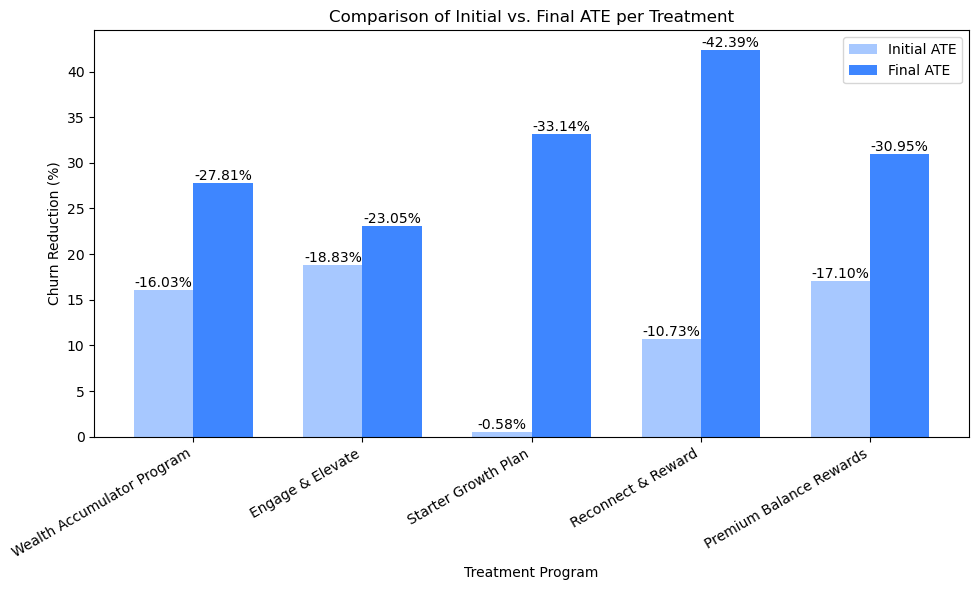

In [194]:
# Bảng ánh xạ từ chỉ số treatment (0,1,2,3,4,5) sang tên chương trình
reverse_treatment_mapping = {
    0: "No Program",
    1: "Wealth Accumulator Program",  # Đảm bảo tên đúng
    2: "Engage & Elevate",
    3: "Starter Growth Plan",
    4: "Reconnect & Reward",
    5: "Premium Balance Rewards"
}

# Bảng ánh xạ từ tên chương trình sang tên cột trong DataFrame
treatment_mapping = {
    "No Program": "pred_NoProgram",
    "Wealth Accumulator Program": "pred_WealthAccumulator",  # Đảm bảo tên đúng
    "Engage & Elevate": "pred_EngageElevate",
    "Starter Growth Plan": "pred_StarterGrowth",
    "Reconnect & Reward": "pred_ReconnectReward",
    "Premium Balance Rewards": "pred_PremiumBalance"
}

# Sắp xếp DataFrame theo cluster_label để đảm bảo xử lý theo thứ tự
df_preds_sorted = df_preds.sort_values(by=['cluster_label'])

# Lấy giá trị ATE trước khi tối ưu (Initial ATE)
initial_ate = {}
for t_val in df_preds_sorted['T_test'].unique():
    group = df_preds_sorted[df_preds_sorted['T_test'] == t_val]
    baseline = group["pred_NoProgram"]
    
    treatment_name = reverse_treatment_mapping.get(t_val, "Unknown")
    if treatment_name != "No Program":
        # Sử dụng tên đúng từ treatment_mapping
        treatment_col = treatment_mapping.get(treatment_name, None)
        if treatment_col:
            treated_outcome = group[treatment_col]
            percent_reduction = ((baseline - treated_outcome) / baseline * 100).mean()
            initial_ate[treatment_name] = percent_reduction

# Lấy giá trị ATE sau khi tối ưu (Final ATE)
final_ate = {}
for tr in df_preds_sorted['treatment_new'].unique():
    group = df_preds_sorted[df_preds_sorted['treatment_new'] == tr]
    baseline = group[treatment_mapping["No Program"]]
    
    if tr != "No Program":
        treatment_col = treatment_mapping.get(tr, None)
        if treatment_col:
            percent_reduction = ((baseline - group[treatment_col]) / baseline * 100).mean()
            final_ate[tr] = percent_reduction

# Chuyển dữ liệu sang DataFrame để dễ vẽ biểu đồ
ate_df = pd.DataFrame({
    "Initial ATE": initial_ate,
    "Final ATE": final_ate
}).fillna(0)  # Nếu có giá trị NaN do thiếu treatment, điền bằng 0

# Vẽ biểu đồ so sánh ATE trước và sau tối ưu
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(ate_df))

bars1 = ax.bar(index, ate_df["Initial ATE"], bar_width, label="Initial ATE", 
               alpha=0.7, color="#82b1ff")  # Xanh dương nhạt
bars2 = ax.bar(index + bar_width, ate_df["Final ATE"], bar_width, label="Final ATE", 
               alpha=0.9, color="#2979ff")  # Xanh dương đậm

ax.set_xlabel("Treatment Program")
ax.set_ylabel("Churn Reduction (%)")
ax.set_title("Comparison of Initial vs. Final ATE per Treatment")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(ate_df.index, rotation=30, ha="right")
ax.legend()

# Hiển thị giá trị trên từng cột
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"-{yval:.2f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


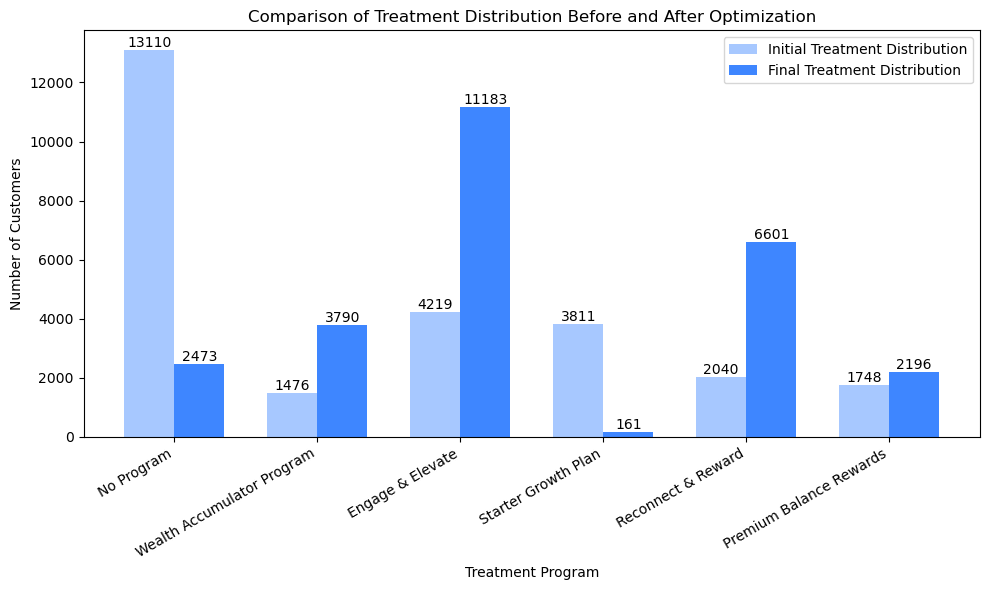

In [175]:
# Đếm số lượng khách hàng nhận từng treatment trước khi tối ưu (Initial)
initial_treatment_counts = df_preds['T_test'].value_counts().sort_index()

# Đếm số lượng khách hàng nhận từng treatment sau khi tối ưu (Final)
final_treatment_counts = df_preds['treatment_new'].value_counts()

# Chuyển index số thành tên chương trình
initial_treatment_labels = [reverse_treatment_mapping.get(t, f"Unknown-{t}") for t in initial_treatment_counts.index]

# Đảm bảo thứ tự giống nhau giữa Initial và Final
final_treatment_counts = final_treatment_counts.reindex(initial_treatment_labels, fill_value=0)

# Vẽ biểu đồ so sánh số lượng khách hàng trước và sau tối ưu
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(initial_treatment_labels))

bars1 = ax.bar(index, initial_treatment_counts, bar_width, label="Initial Treatment Distribution", 
               alpha=0.7, color="#82b1ff")  # Màu xanh dương nhạt
bars2 = ax.bar(index + bar_width, final_treatment_counts, bar_width, label="Final Treatment Distribution", 
               alpha=0.9, color="#2979ff")  # Màu xanh dương đậm

ax.set_xlabel("Treatment Program")
ax.set_ylabel("Number of Customers")
ax.set_title("Comparison of Treatment Distribution Before and After Optimization")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(initial_treatment_labels, rotation=30, ha="right")
ax.legend()

# Hiển thị số lượng trên từng cột
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [203]:
import plotly.graph_objects as go

# Đếm số lượng chuyển đổi từ T_test (initial treatment) đến treatment_new (final treatment)
transition_counts = df_preds.groupby(['T_test', 'treatment_new']).size().reset_index(name='count')

# Tạo danh sách các nodes (initial treatment và final treatment)
initial_treatment_labels = [reverse_treatment_mapping.get(t, f"Unknown-{t}") for t in transition_counts['T_test'].unique()]
final_treatment_labels = [reverse_treatment_mapping.get(t, f"Unknown-{t}") for t in transition_counts['treatment_new'].unique()]

# Tạo danh sách tổng hợp tất cả các treatment (initial và final)
unique_treatments = initial_treatment_labels + final_treatment_labels
node_indices = {t: i for i, t in enumerate(unique_treatments)}  # Map tên treatment sang index

# Tạo danh sách các nguồn và đích cho Sankey diagram
sources = [node_indices[reverse_treatment_mapping.get(t, f"Unknown-{t}") ] for t in transition_counts['T_test']]
targets = [node_indices[reverse_treatment_mapping.get(t, f"Unknown-{t}") ] for t in transition_counts['treatment_new']]
values = transition_counts['count'].tolist()

# Vẽ Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=10,  # Giảm khoảng cách giữa các node
        thickness=20,
        line=dict(color="black", width=0),
        label=unique_treatments,
        color=["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3"][:len(unique_treatments)]  # Màu tự động
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

# Cấu hình tiêu đề và thay đổi kích thước của biểu đồ
fig.update_layout(
    title_text="Treatment Transition Before and After Optimization", 
    font_size=14,  # Đặt kích thước chữ tiêu đề lớn hơn
    width=800,  # Đặt chiều rộng cho biểu đồ
    height=600,  # Đặt chiều cao cho biểu đồ
    title_x=0.5  # Căn giữa tiêu đề
)

fig.show()


In [177]:
df_summary = pd.DataFrame()
df_summary = df_preds.copy()
X_test = X_test.reset_index(drop=True)
df_summary['cluser_label']= X_test['cluser_label']
df_summary


pred_NoProgram  pred_WealthAccumulator  pred_EngageElevate  \
0            0.106109                0.147728            0.088637   
1            0.080505                0.110709            0.036572   
2            0.059580                0.080325            0.073796   
3            0.074238                0.102216            0.043057   
4            0.071171                0.123393            0.054662   
...               ...                     ...                 ...   
26399        0.214719                0.208172            0.220598   
26400        0.050890                0.036973            0.039965   
26401        0.385163                0.415052            0.376635   
26402        0.071902                0.043685            0.039021   
26403        0.795523                0.705181            0.749878   

       pred_StarterGrowth  pred_ReconnectReward  pred_PremiumBalance  \
0                0.137760              0.071787             0.123947   
1                0.107284              0.089583             0.103354   
2                0.081034              0.076344             0.033449   
3                0.108130              0.088793             0.104183   
4                0.124590              0.111044             0.119510   
...                   ...                   ...                  ...   
26399            0.238151              0.286892             0.218274   
26400            0.041282              0.042790             0.049208   
26401            0.441843              0.418935             0.396087   
26402            0.040396              0.049166             0.054408   
26403            0.715371              0.787563             0.709036   

                    treatment_new    y_test  T_test  cluster_label  \
0              Reconnect & Reward  0.187335       0              3   
1                Engage & Elevate  0.070686       0              1   
2         Premium Balance Rewards  0.013100       5              4   
3                Engage & Elevate  0.044416       2              1   
4                Engage & Elevate  0.037290       2              1   
...                           ...       ...     ...            ...   
26399  Wealth Accumulator Program  0.068594       0              0   
26400  Wealth Accumulator Program  0.089257       0              2   
26401            Engage & Elevate  0.445730       0              1   
26402            Engage & Elevate  0.014207       0              2   
26403  Wealth Accumulator Program  0.858569       2              1   

       cluser_label  
0                 3  
1                 1  
2                 4  
3                 1  
4                 1  
...             ...  
26399             0  
26400             2  
26401             1  
26402             2  
26403             1  

[26404 rows x 11 columns]

In [178]:
# Định nghĩa ánh xạ từ treatment_new sang tên cột pred_*
treatment_to_col = {
    "Engage & Elevate": "pred_EngageElevate",
    "Wealth Accumulator Program": "pred_WealthAccumulator",
    "Starter Growth Plan": "pred_StarterGrowth",
    "Reconnect & Reward": "pred_ReconnectReward",
    "Premium Balance Rewards": "pred_PremiumBalance",
    "No Program": "pred_NoProgram"
}

# Tính outcome tối ưu
df_summary['optimal_outcome'] = df_summary.apply(
    lambda row: row[treatment_to_col[row['treatment_new']]],
    axis=1
)
# Định nghĩa ánh xạ treatment_name -> giá trị T_test
treatment_mapping = {
    "No Program": 0,
    "Engage & Elevate": 2,
    "Premium Balance Rewards": 5,
    "Reconnect & Reward": 4,
    "Starter Growth Plan": 3,
    "Wealth Accumulator Program": 1
}

# Tạo ánh xạ ngược: từ giá trị T_test -> treatment_name
inverse_treatment_mapping = {v: k for k, v in treatment_mapping.items()}

# Áp dụng ánh xạ để tạo cột treatment_old từ cột T_test
df_summary['treatment_old'] = df_summary['T_test'].map(inverse_treatment_mapping)

# Kiểm tra kết quả
print(df_summary[['T_test', 'treatment_old']].head())



# In 5 dòng đầu của DataFrame
print("=== Head của df_summary ===")
df_summary

   T_test            treatment_old
0       0               No Program
1       0               No Program
2       5  Premium Balance Rewards
3       2         Engage & Elevate
4       2         Engage & Elevate
=== Head của df_summary ===


pred_NoProgram  pred_WealthAccumulator  pred_EngageElevate  \
0            0.106109                0.147728            0.088637   
1            0.080505                0.110709            0.036572   
2            0.059580                0.080325            0.073796   
3            0.074238                0.102216            0.043057   
4            0.071171                0.123393            0.054662   
...               ...                     ...                 ...   
26399        0.214719                0.208172            0.220598   
26400        0.050890                0.036973            0.039965   
26401        0.385163                0.415052            0.376635   
26402        0.071902                0.043685            0.039021   
26403        0.795523                0.705181            0.749878   

       pred_StarterGrowth  pred_ReconnectReward  pred_PremiumBalance  \
0                0.137760              0.071787             0.123947   
1                0.107284              0.089583             0.103354   
2                0.081034              0.076344             0.033449   
3                0.108130              0.088793             0.104183   
4                0.124590              0.111044             0.119510   
...                   ...                   ...                  ...   
26399            0.238151              0.286892             0.218274   
26400            0.041282              0.042790             0.049208   
26401            0.441843              0.418935             0.396087   
26402            0.040396              0.049166             0.054408   
26403            0.715371              0.787563             0.709036   

                    treatment_new    y_test  T_test  cluster_label  \
0              Reconnect & Reward  0.187335       0              3   
1                Engage & Elevate  0.070686       0              1   
2         Premium Balance Rewards  0.013100       5              4   
3                Engage & Elevate  0.044416       2              1   
4                Engage & Elevate  0.037290       2              1   
...                           ...       ...     ...            ...   
26399  Wealth Accumulator Program  0.068594       0              0   
26400  Wealth Accumulator Program  0.089257       0              2   
26401            Engage & Elevate  0.445730       0              1   
26402            Engage & Elevate  0.014207       0              2   
26403  Wealth Accumulator Program  0.858569       2              1   

       cluser_label  optimal_outcome            treatment_old  
0                 3         0.071787               No Program  
1                 1         0.036572               No Program  
2                 4         0.033449  Premium Balance Rewards  
3                 1         0.043057         Engage & Elevate  
4                 1         0.054662         Engage & Elevate  
...             ...              ...                      ...  
26399             0         0.208172               No Program  
26400             2         0.036973               No Program  
26401             1         0.376635               No Program  
26402             2         0.039021               No Program  
26403             1         0.705181         Engage & Elevate  

[26404 rows x 13 columns]

Overall Initial Churn: 20.1145
Overall Optimal Churn: 17.4712
Churn Reduction: 2.6433 (13.14%)


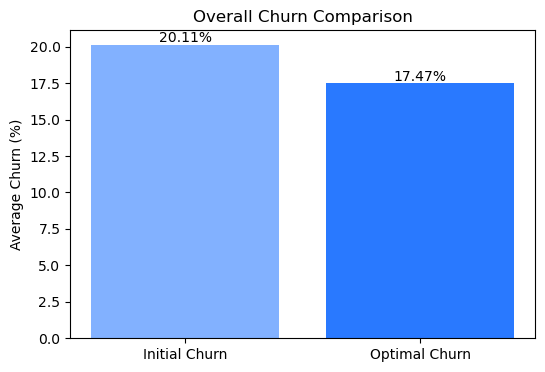

In [179]:
import matplotlib.pyplot as plt

# Tính churn trung bình
initial_churn = df_summary['y_test'].mean() * 100
optimal_churn = df_summary['optimal_outcome'].mean() * 100
churn_reduction = initial_churn - optimal_churn
churn_reduction_pct = churn_reduction / initial_churn * 100

print("Overall Initial Churn: {:.4f}".format(initial_churn))
print("Overall Optimal Churn: {:.4f}".format(optimal_churn))
print("Churn Reduction: {:.4f} ({:.2f}%)".format(churn_reduction, churn_reduction_pct))

# Vẽ biểu đồ cột so sánh Overall Churn
plt.figure(figsize=(6,4))
bars = plt.bar(['Initial Churn', 'Optimal Churn'], [initial_churn, optimal_churn], 
               color=['#82b1ff', '#2979ff'])  # Đỏ nhạt & đỏ đậm

plt.ylabel('Average Churn (%)')
plt.title('Overall Churn Comparison')

# Hiển thị giá trị trên từng cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.show()





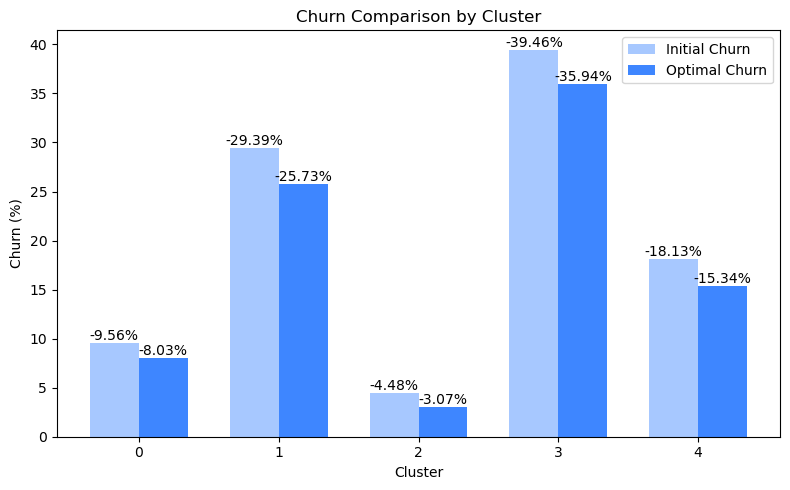

In [195]:
# --- Churn theo từng Cluster ---
import numpy as np

# Tính churn theo từng cluster, chuyển sang %
cluster_churn = df_summary.groupby('cluser_label').agg({'y_test': 'mean', 'optimal_outcome': 'mean'}).reset_index()
cluster_churn['y_test_pct'] = cluster_churn['y_test'] * 100
cluster_churn['optimal_outcome_pct'] = cluster_churn['optimal_outcome'] * 100

plt.figure(figsize=(8,5))
x = np.arange(len(cluster_churn))  # Vị trí của các cột
width = 0.35  # Độ rộng của cộtcolor=['#82b1ff', '#2979ff'])

# Vẽ biểu đồ
bars1 = plt.bar(x - width/2, cluster_churn['y_test_pct'], width, label='Initial Churn', color='#82b1ff', alpha=0.7)
bars2 = plt.bar(x + width/2, cluster_churn['optimal_outcome_pct'], width, label='Optimal Churn', color='#2979ff', alpha=0.9)

plt.xticks(x, cluster_churn['cluser_label'])
plt.xlabel('Cluster')
plt.ylabel('Churn (%)')
plt.title('Churn Comparison by Cluster')
plt.legend()

# Ghi chú giá trị dạng phần trăm lên biểu đồ
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'-{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

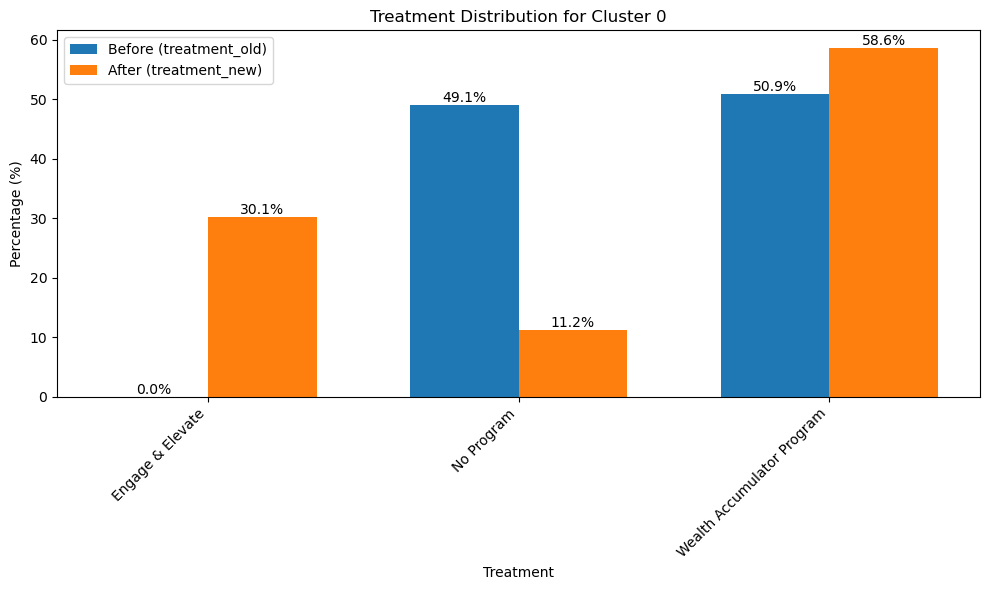

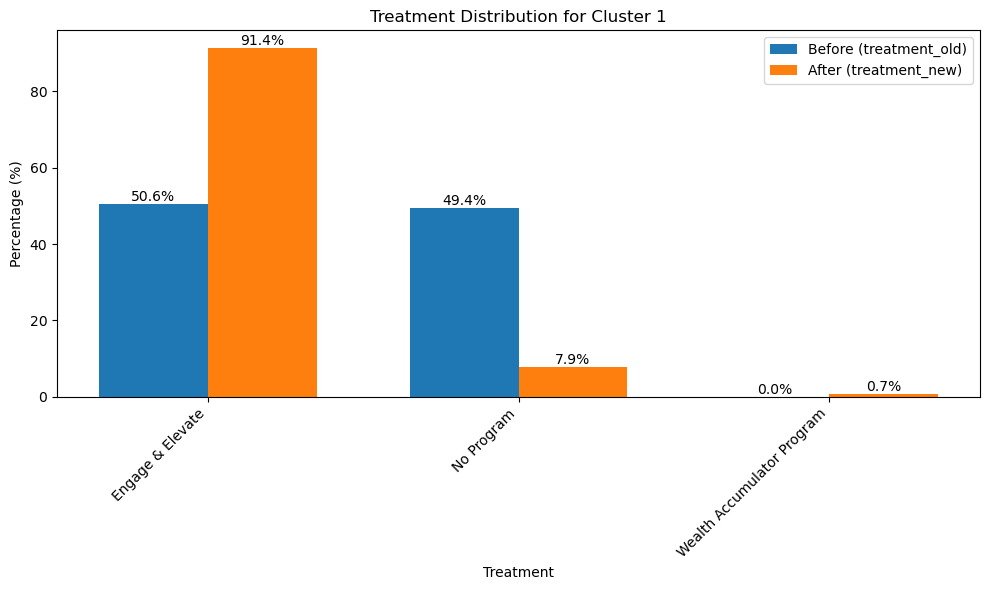

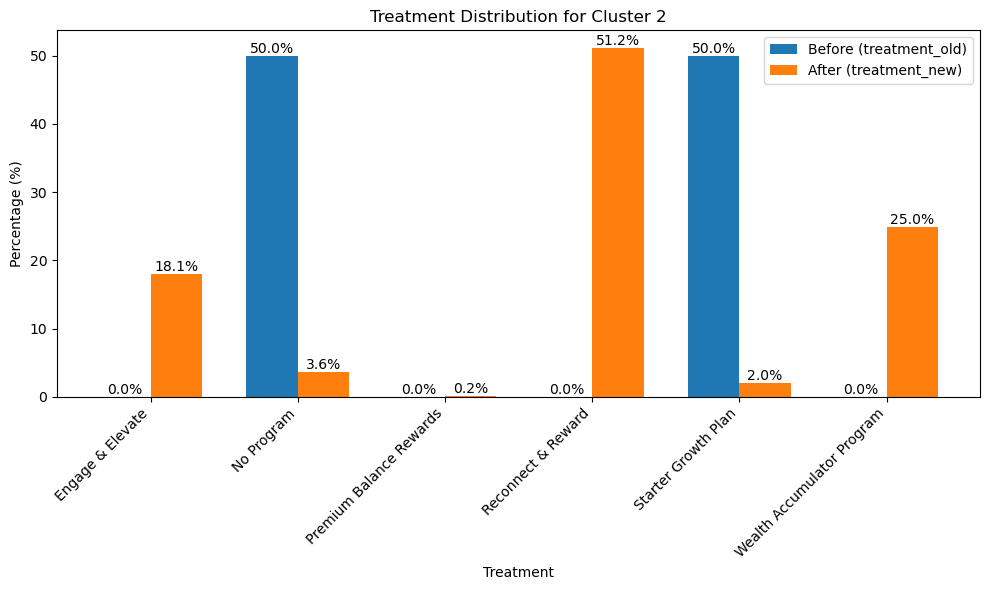

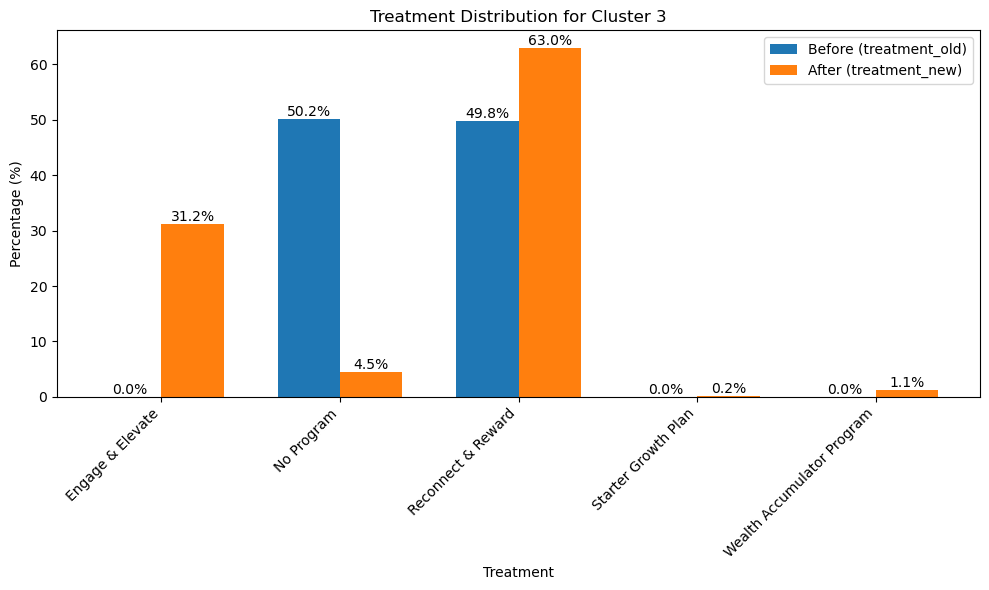

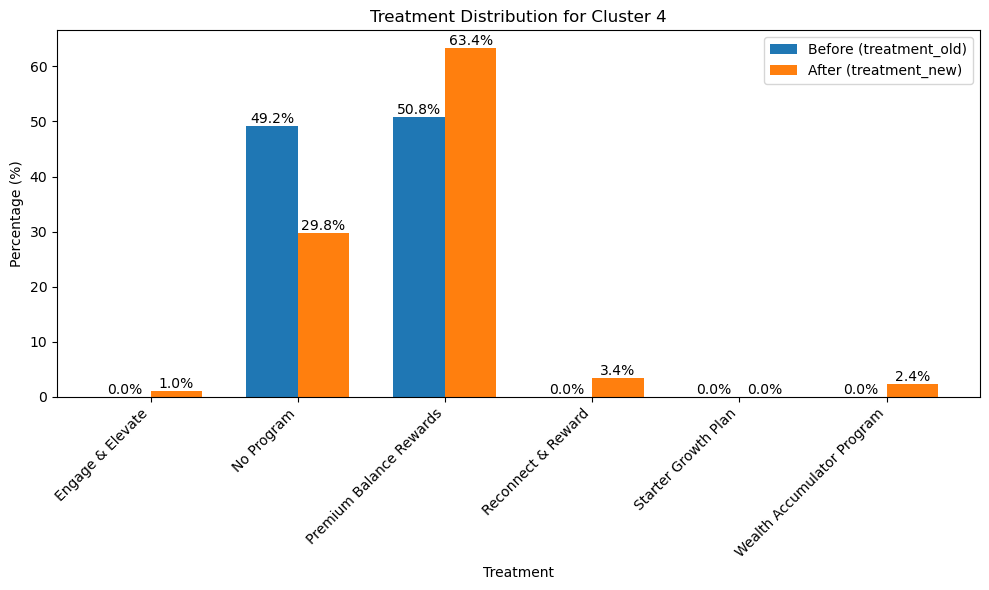

In [182]:
clusters = sorted(df_summary['cluser_label'].unique())

for cluster in clusters:
    cluster_df = df_summary[df_summary['cluser_label'] == cluster]
    # Tính phần trăm cho từng treatment trước và sau
    init_counts = cluster_df['treatment_old'].value_counts(normalize=True).sort_index() * 100
    opt_counts = cluster_df['treatment_new'].value_counts(normalize=True).sort_index() * 100
    
    # Tạo danh sách tất cả các treatment có trong cả 2 phân bố
    treatments = sorted(set(init_counts.index).union(set(opt_counts.index)))
    init_vals = [init_counts.get(t, 0) for t in treatments]
    opt_vals = [opt_counts.get(t, 0) for t in treatments]
    
    x = range(len(treatments))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar([i - width/2 for i in x], init_vals, width, label='Before (treatment_old)')
    plt.bar([i + width/2 for i in x], opt_vals, width, label='After (treatment_new)')
    plt.xlabel('Treatment')
    plt.ylabel('Percentage (%)')
    plt.title(f'Treatment Distribution for Cluster {cluster}')
    plt.xticks(x, treatments, rotation=45, ha='right')
    plt.legend()
    
    # Ghi chú phần trăm lên biểu đồ
    for i, v in enumerate(init_vals):
        plt.text(i - width/2, v, f'{v:.1f}%', ha='center', va='bottom')
    for i, v in enumerate(opt_vals):
        plt.text(i + width/2, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


## 6.2 SHAP

In [45]:
# Đảm bảo rằng index của X_test và df_summary đã được reset cho khớp nhau
X_test = X_test.reset_index(drop=True)
cols_to_merge = df_summary[['y_test', 'optimal_outcome', 'T_test', 'treatment_old', 'treatment_new']].reset_index(drop=True)

# Gộp X_test với các cột cần thiết
X_test = pd.concat([X_test, cols_to_merge], axis=1)

# Hiển thị X_test sau khi gộp
X_test

CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0         0.343877       1 -0.007253 -0.883163              1          1   
1         1.517365       1 -0.007253  1.410692              1          0   
2        -0.941966       0  0.349107  1.465416              2          1   
3         0.343877       1 -0.719973  1.048719              1          1   
4         0.943105       0  1.418187  1.207234              1          0   
...            ...     ...       ...       ...            ...        ...   
26399     0.918137       0  0.349107  1.385888              2          1   
26400     0.868201       0 -1.076334 -0.883163              2          1   
26401     0.730878       1  1.774548  1.042439              1          1   
26402    -0.979417       0 -0.363613 -0.883163              2          1   
26403    -0.130511       1 -1.076334  1.009613              3          0   

       IsActiveMember  EstimatedSalary  cluser_label  Age_Group  \
0                   1        -0.093426             3        0.0   
1                   1        -0.690112             1        0.0   
2                   1         0.082970             4        0.0   
3                   1         0.526407             1        1.0   
4                   1        -0.053545             1        0.0   
...               ...              ...           ...        ...   
26399               0         0.512714             0        1.0   
26400               0         0.964396             2        0.0   
26401               1        -0.898945             1        2.0   
26402               0        -1.716212             2        0.0   
26403               0        -1.415025             1        0.0   

       Geography_Germany    y_test  optimal_outcome  T_test  \
0                    0.0  0.187335         0.071787       0   
1                    0.0  0.070686         0.036572       0   
2                    1.0  0.013100         0.033449       5   
3                    0.0  0.044416         0.043057       2   
4                    0.0  0.037290         0.054662       2   
...                  ...       ...              ...     ...   
26399                1.0  0.068594         0.208172       0   
26400                0.0  0.089257         0.036973       0   
26401                1.0  0.445730         0.376635       0   
26402                0.0  0.014207         0.039021       0   
26403                1.0  0.858569         0.705181       2   

                 treatment_old               treatment_new  
0                   No Program          Reconnect & Reward  
1                   No Program            Engage & Elevate  
2      Premium Balance Rewards     Premium Balance Rewards  
3             Engage & Elevate            Engage & Elevate  
4             Engage & Elevate            Engage & Elevate  
...                        ...                         ...  
26399               No Program  Wealth Accumulator Program  
26400               No Program  Wealth Accumulator Program  
26401               No Program            Engage & Elevate  
26402               No Program            Engage & Elevate  
26403         Engage & Elevate  Wealth Accumulator Program  

[26404 rows x 16 columns]

In [46]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Giả sử df_summary đã chứa các cột cần thiết và treatment_new dưới dạng chuỗi.
# Định nghĩa mapping treatment_new -> số
treatment_mapping = {
    "No Program": 0,
    "Engage & Elevate": 2,
    "Premium Balance Rewards": 5,
    "Reconnect & Reward": 4,
    "Starter Growth Plan": 3,
    "Wealth Accumulator Program": 1
}
df_summary = X_test.copy()
# Mã hóa treatment_new thành giá trị số
df_summary['treatment_new_encoded'] = df_summary['treatment_new'].map(treatment_mapping)

# Chọn các đặc trưng
feature_cols = [
    'CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts',
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
    'Age_Group', 'Geography_Germany'
]
X_features = df_summary[feature_cols]
y_target = df_summary['treatment_new_encoded']

# Huấn luyện mô hình phân loại (sử dụng XGBoost)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_features, y_target)
rf_model.fit(X_features, y_target)

RandomForestClassifier(random_state=42)

In [47]:
import shap
shap.initjs()

# Tạo SHAP explainer cho Random Forest
explainer_rf = shap.Explainer(rf_model)
# Tính giá trị SHAP cho X_features
shap_values_rf = explainer_rf(X_features)


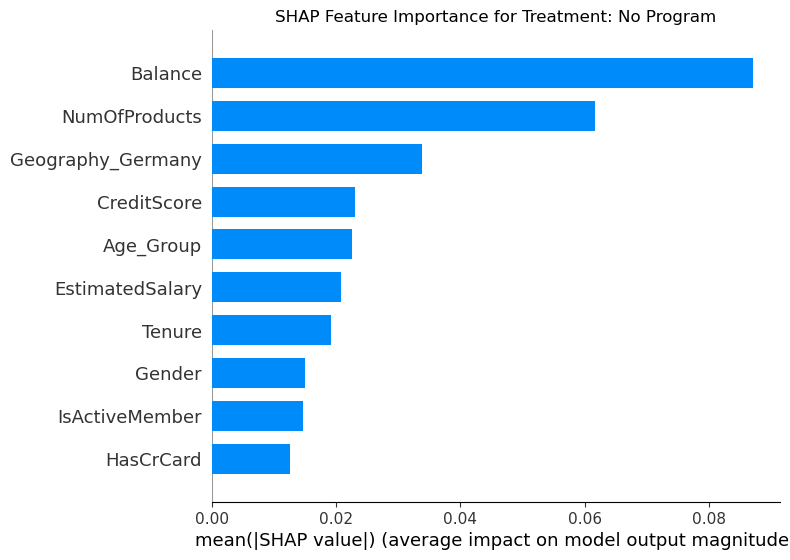

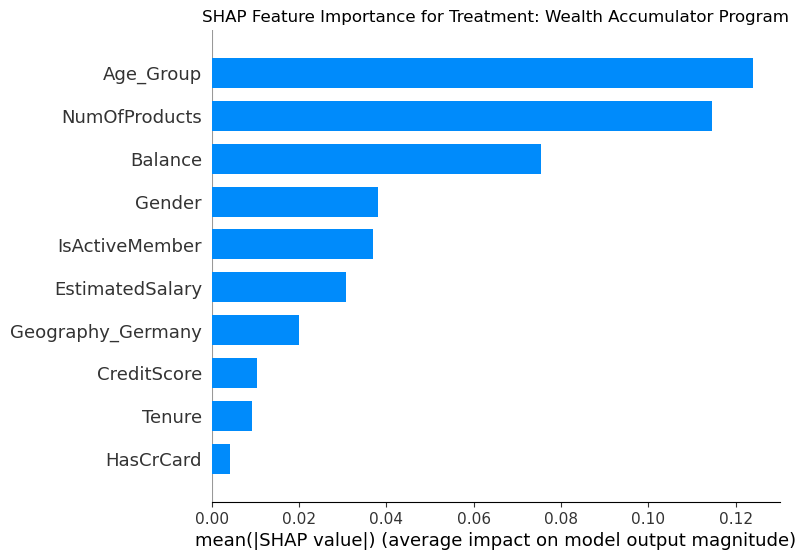

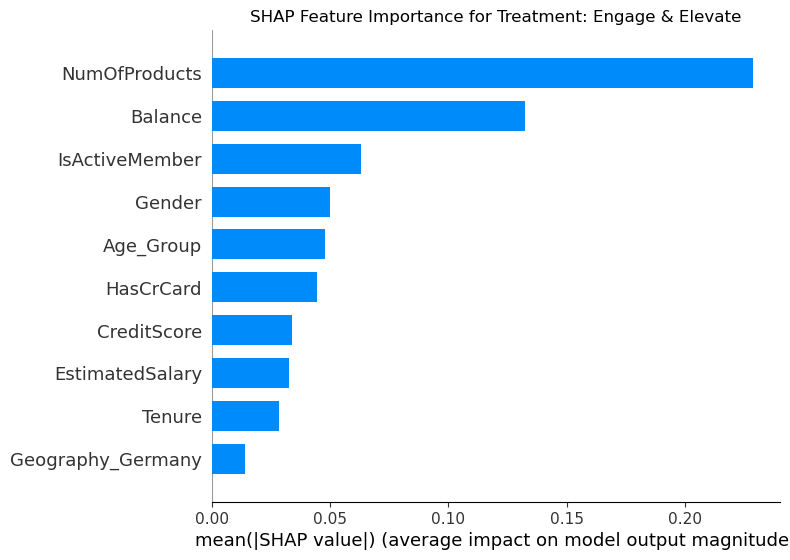

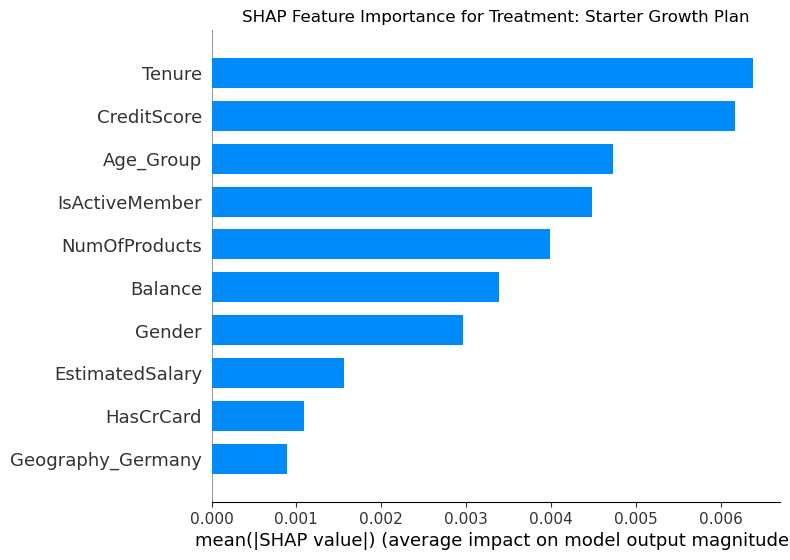

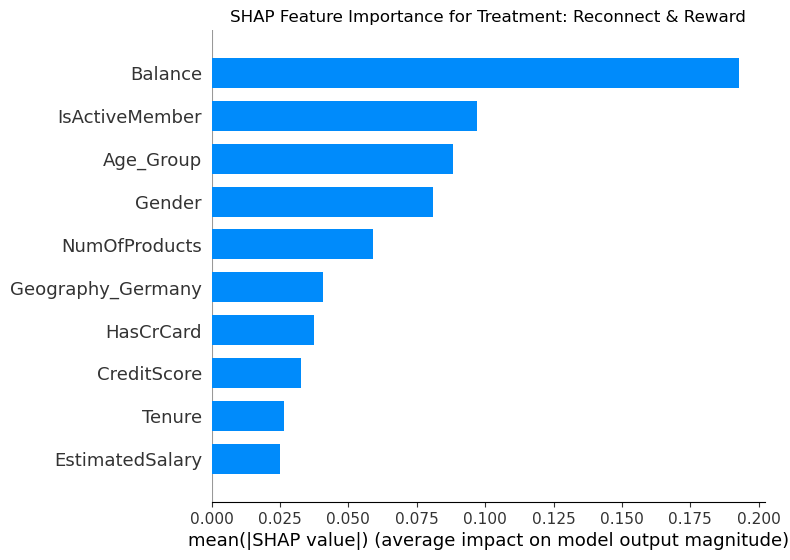

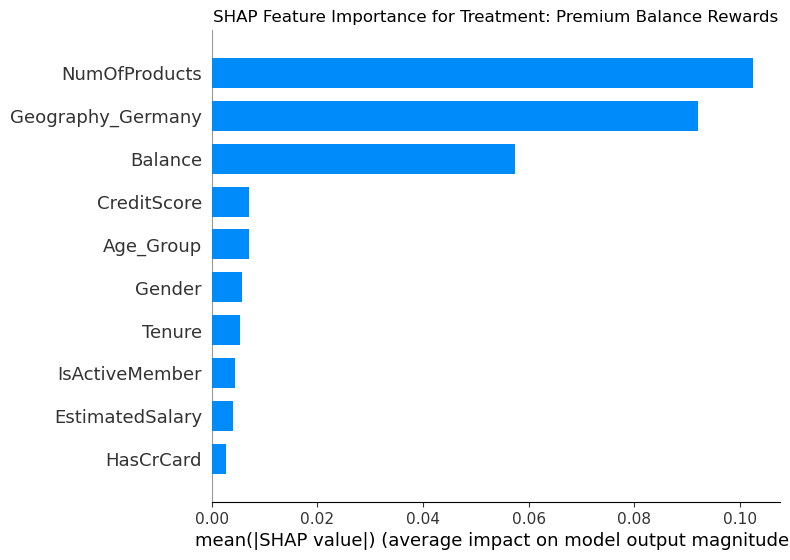

In [48]:
import matplotlib.pyplot as plt

# Giả sử shap_values_rf.values có shape (n_samples, n_features, n_classes)
n_classes = shap_values_rf.values.shape[2]

# Tạo inverse mapping từ số sang tên treatment
inv_mapping = {v: k for k, v in treatment_mapping.items()}

for j in range(n_classes):
    # Lấy giá trị SHAP cho lớp j: shape = (n_samples, n_features)
    shap_values_class = shap_values_rf.values[:, :, j]
    
    plt.figure()
    shap.summary_plot(
        shap_values_class, 
        X_features, 
        plot_type="bar",
        show=False
    )
    # Lấy tên treatment dựa trên giá trị số (rf_model.classes_[j])
    treatment_value = rf_model.classes_[j]
    treatment_name = inv_mapping.get(treatment_value, f"Class {treatment_value}")
    plt.title(f"SHAP Feature Importance for Treatment: {treatment_name}")
    plt.show()


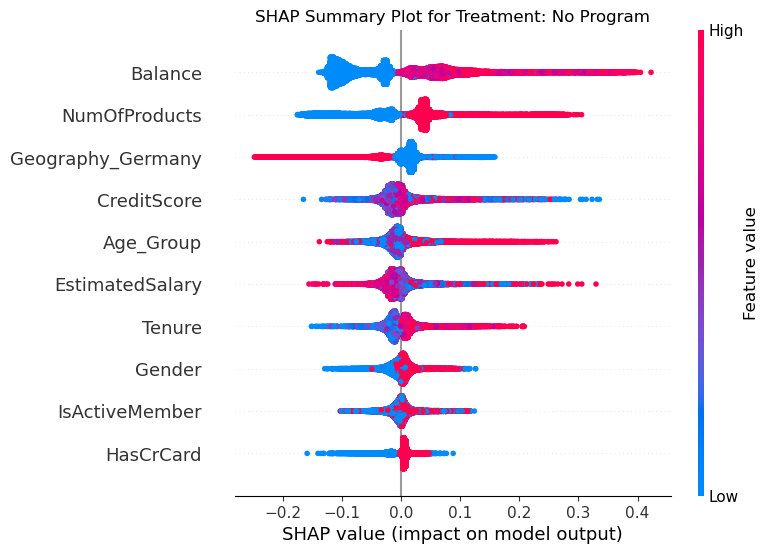

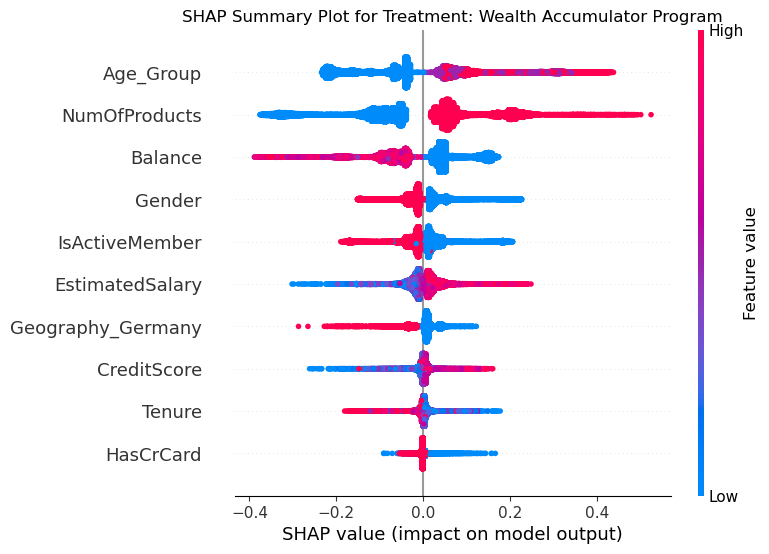

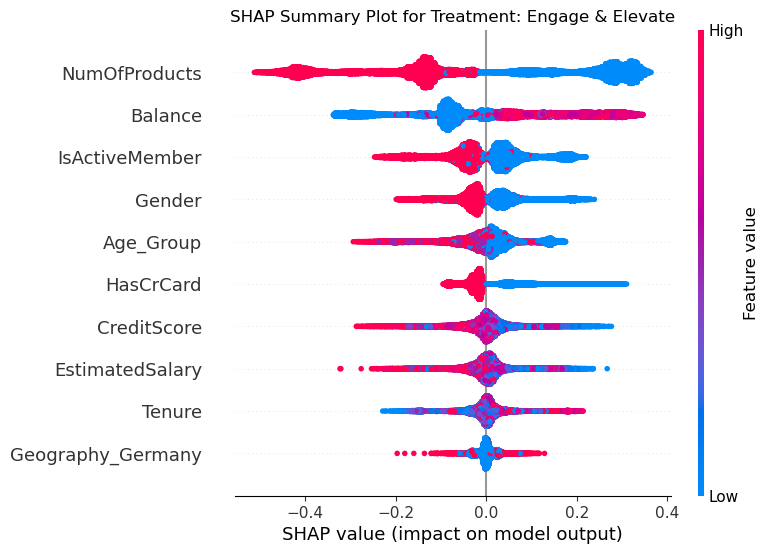

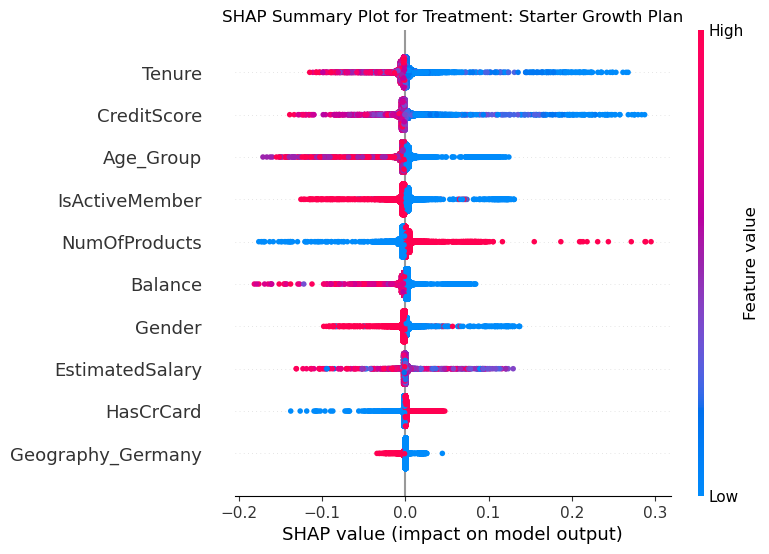

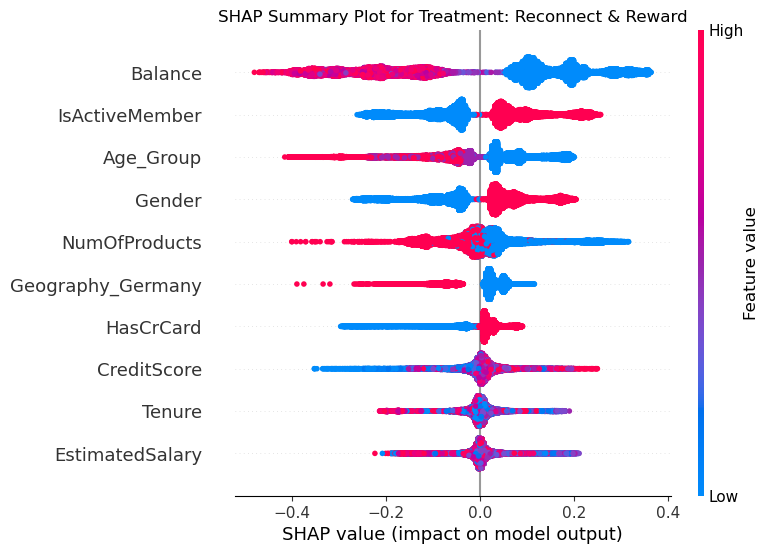

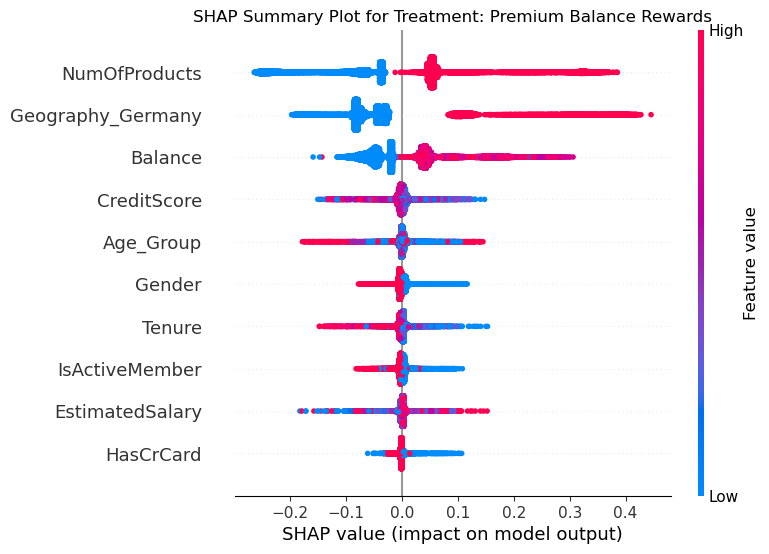

In [49]:
# B5: Vẽ biểu đồ beeswarm (mặc định) cho từng lớp
n_classes = shap_values_rf.values.shape[2]
for class_idx in range(n_classes):
    # Lấy SHAP values cho lớp class_idx
    shap_values_class = shap_values_rf.values[:, :, class_idx]  # shape (n_samples, n_features)
    
    # Lấy tên treatment từ mapping
    treatment_val = rf_model.classes_[class_idx]
    treatment_name = inv_mapping.get(treatment_val, f"Class {treatment_val}")
    
    plt.figure()
    # Vẽ biểu đồ dạng “beeswarm” (plot_type mặc định = "dot")
    shap.summary_plot(
        shap_values_class,
        X_features,
        show=False
    )
    plt.title(f"SHAP Summary Plot for Treatment: {treatment_name}")
    plt.show()

## 6.3 PDP

In [56]:
df_cai

CreditScore  Gender    Tenure   Balance  NumOfProducts  HasCrCard  \
0          0.144135       1 -0.719973 -0.883163              2          1   
1         -0.367706       1 -1.432694 -0.883163              2          1   
2          0.268974       1  1.774548 -0.883163              2          1   
3         -0.941966       1 -1.076334  1.486918              1          1   
4          0.743362       1 -0.007253 -0.883163              2          1   
...             ...     ...       ...       ...            ...        ...   
165029     0.131651       0 -1.076334 -0.883163              1          1   
165030     1.692140       1 -0.719973 -0.883163              1          0   
165031    -1.141708       1 -0.007253 -0.883163              1          1   
165032    -1.279031       0  0.705467  1.688303              1          0   
165033     2.416207       1 -1.432694 -0.883163              1          1   

        IsActiveMember  EstimatedSalary  Exited  Age_Group  Geography_Germany  \
0                    0         1.369486       0        0.0                0.0   
1                    1        -1.254085       0        0.0                0.0   
2                    0         1.437422       0        1.0                0.0   
3                    1        -0.557018       0        0.0                0.0   
4                    1        -1.938770       0        0.0                0.0   
...                ...              ...     ...        ...                ...   
165029               1         0.382957       0        0.0                0.0   
165030               0         0.382951       0        0.0                0.0   
165031               1         0.295366       0        0.0                0.0   
165032               1        -0.823217       0        0.0                0.0   
165033               0        -1.013925       1        0.0                0.0   

           p_pre  cluser_label  p_churn_post  Treatment_num  
0       0.024463             2      0.011536              3  
1       0.012693             2      0.012087              3  
2       0.036313             0      0.154547              0  
3       0.042193             1      0.034744              2  
4       0.012692             2      0.007140              0  
...          ...           ...           ...            ...  
165029  0.157476             3      0.063101              4  
165030  0.228613             3      0.317043              4  
165031  0.097923             3      0.076299              4  
165032  0.101181             1      0.079845              2  
165033  0.215444             3      0.054902              4  

[165034 rows x 15 columns]

In [61]:
print("Tên cột trong X:", X_test.columns.tolist())

Tên cột trong X: ['CreditScore', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'cluser_label', 'Age_Group', 'Geography_Germany', 'y_test', 'optimal_outcome', 'T_test', 'treatment_old', 'treatment_new']


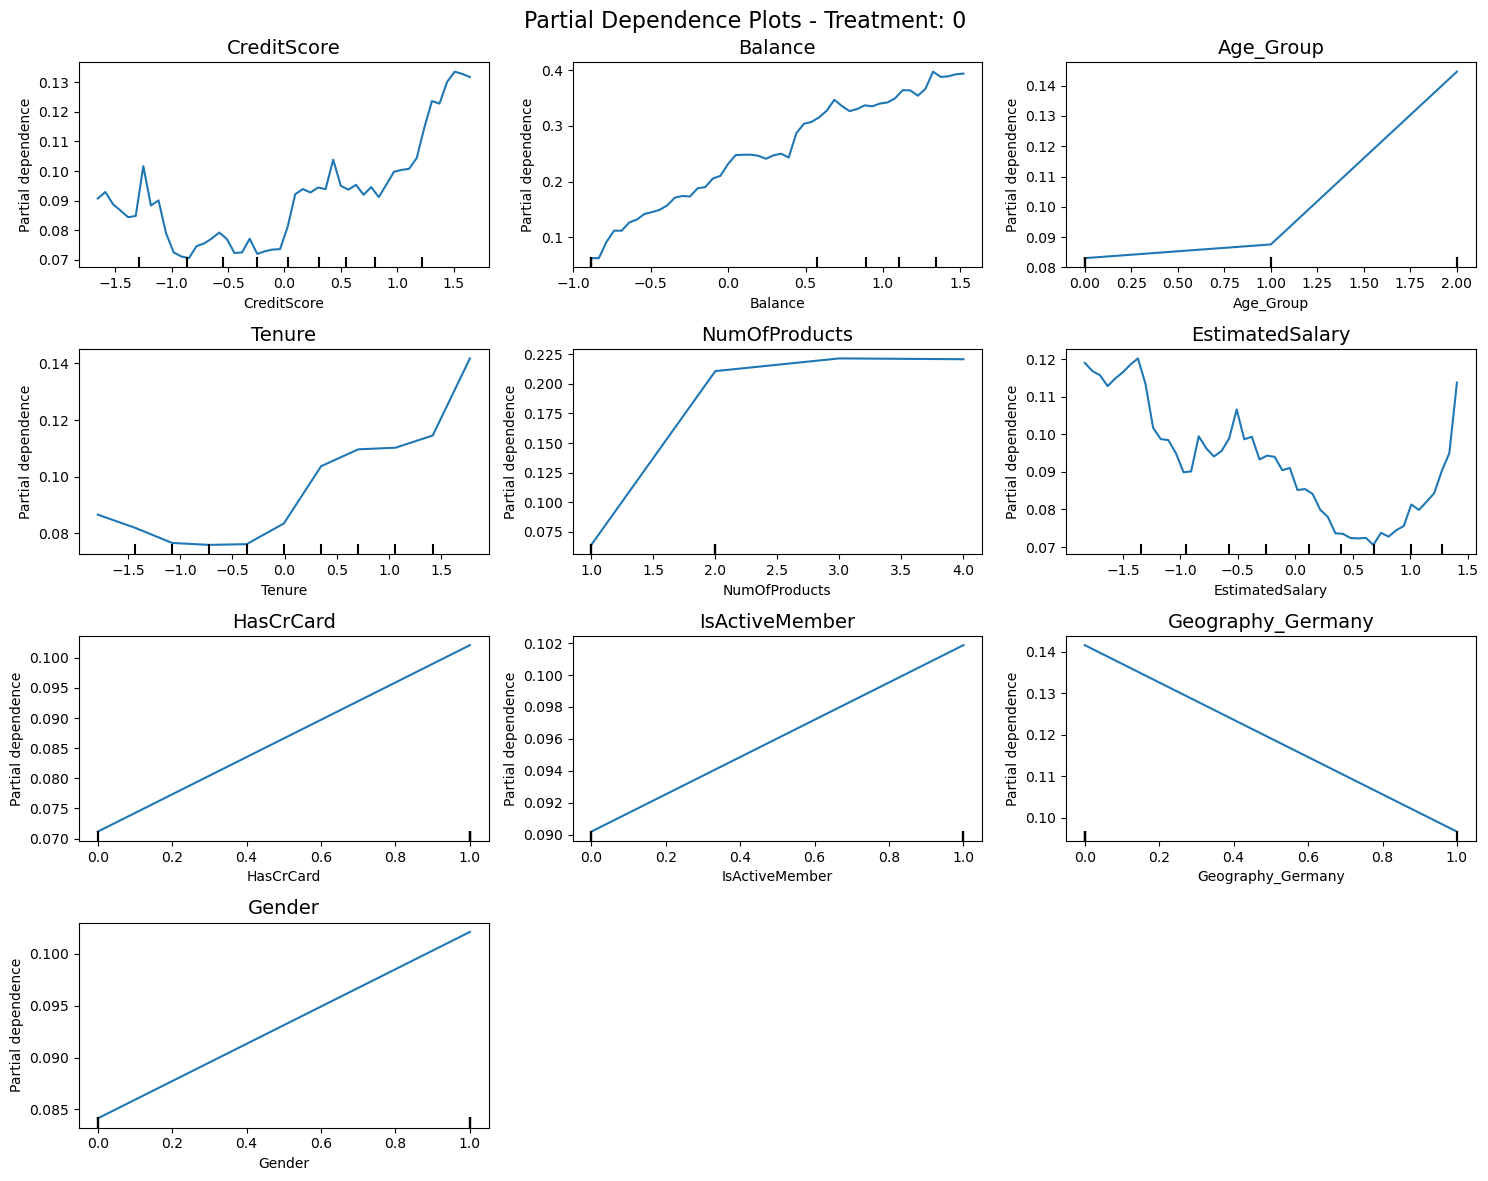

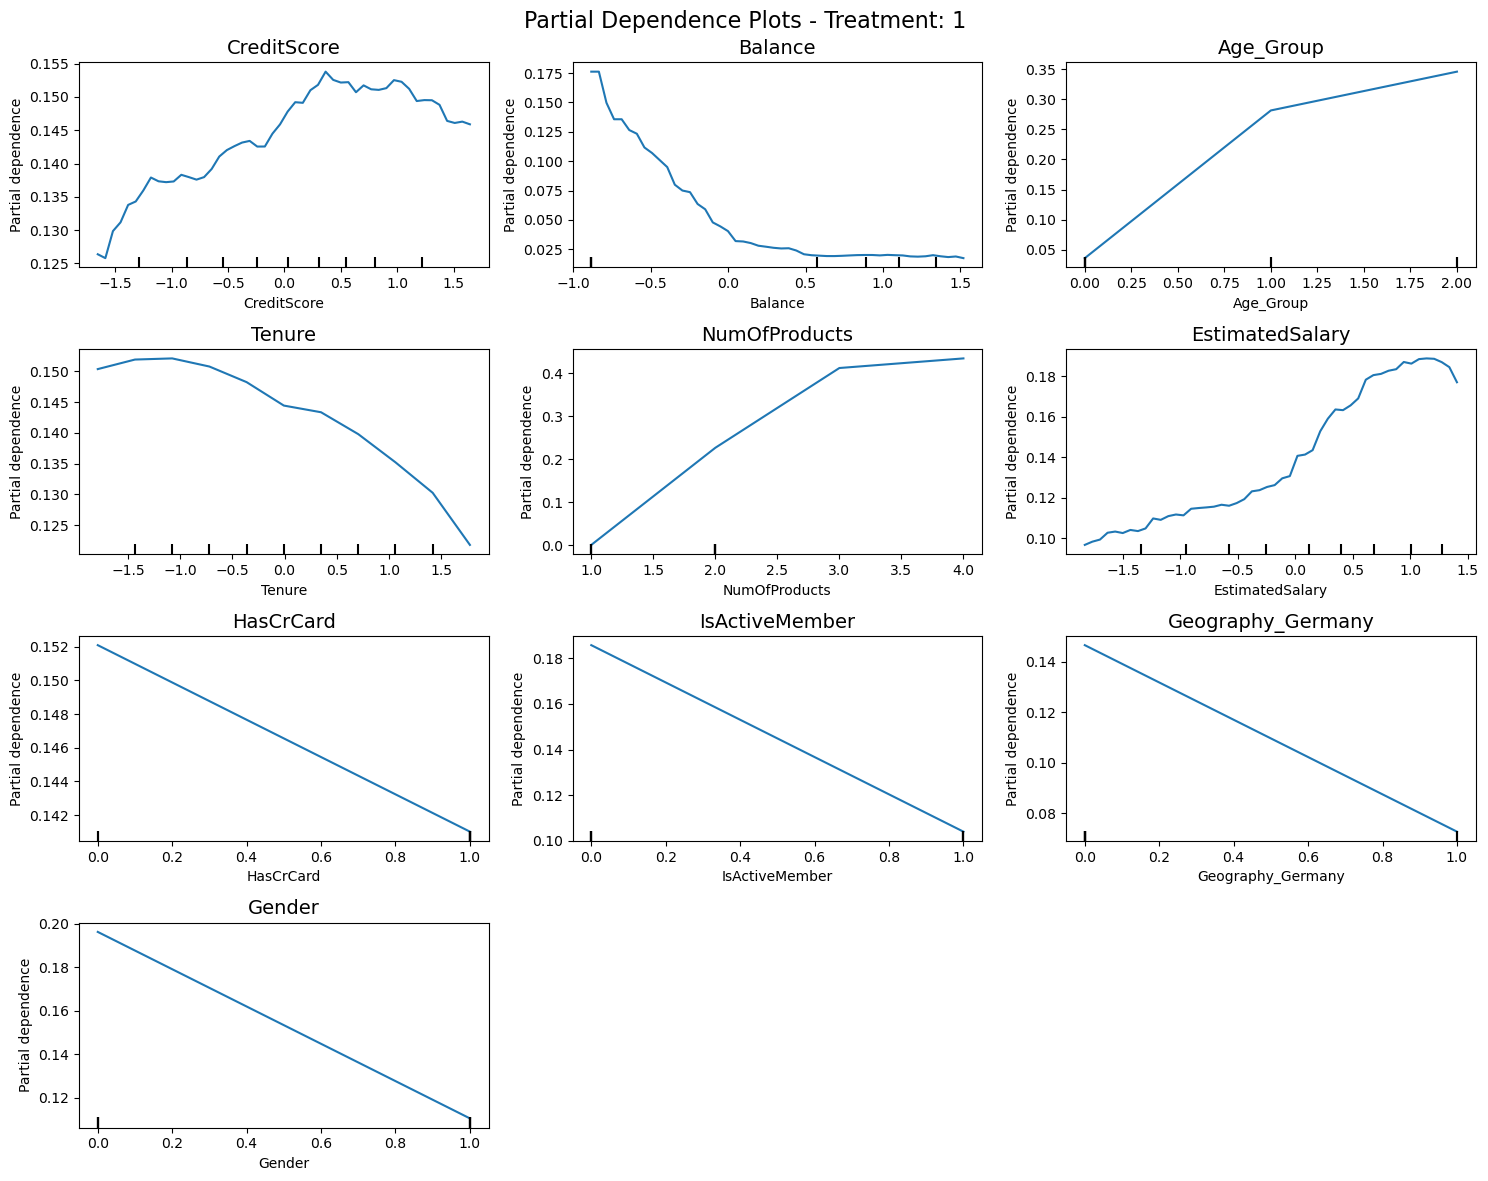

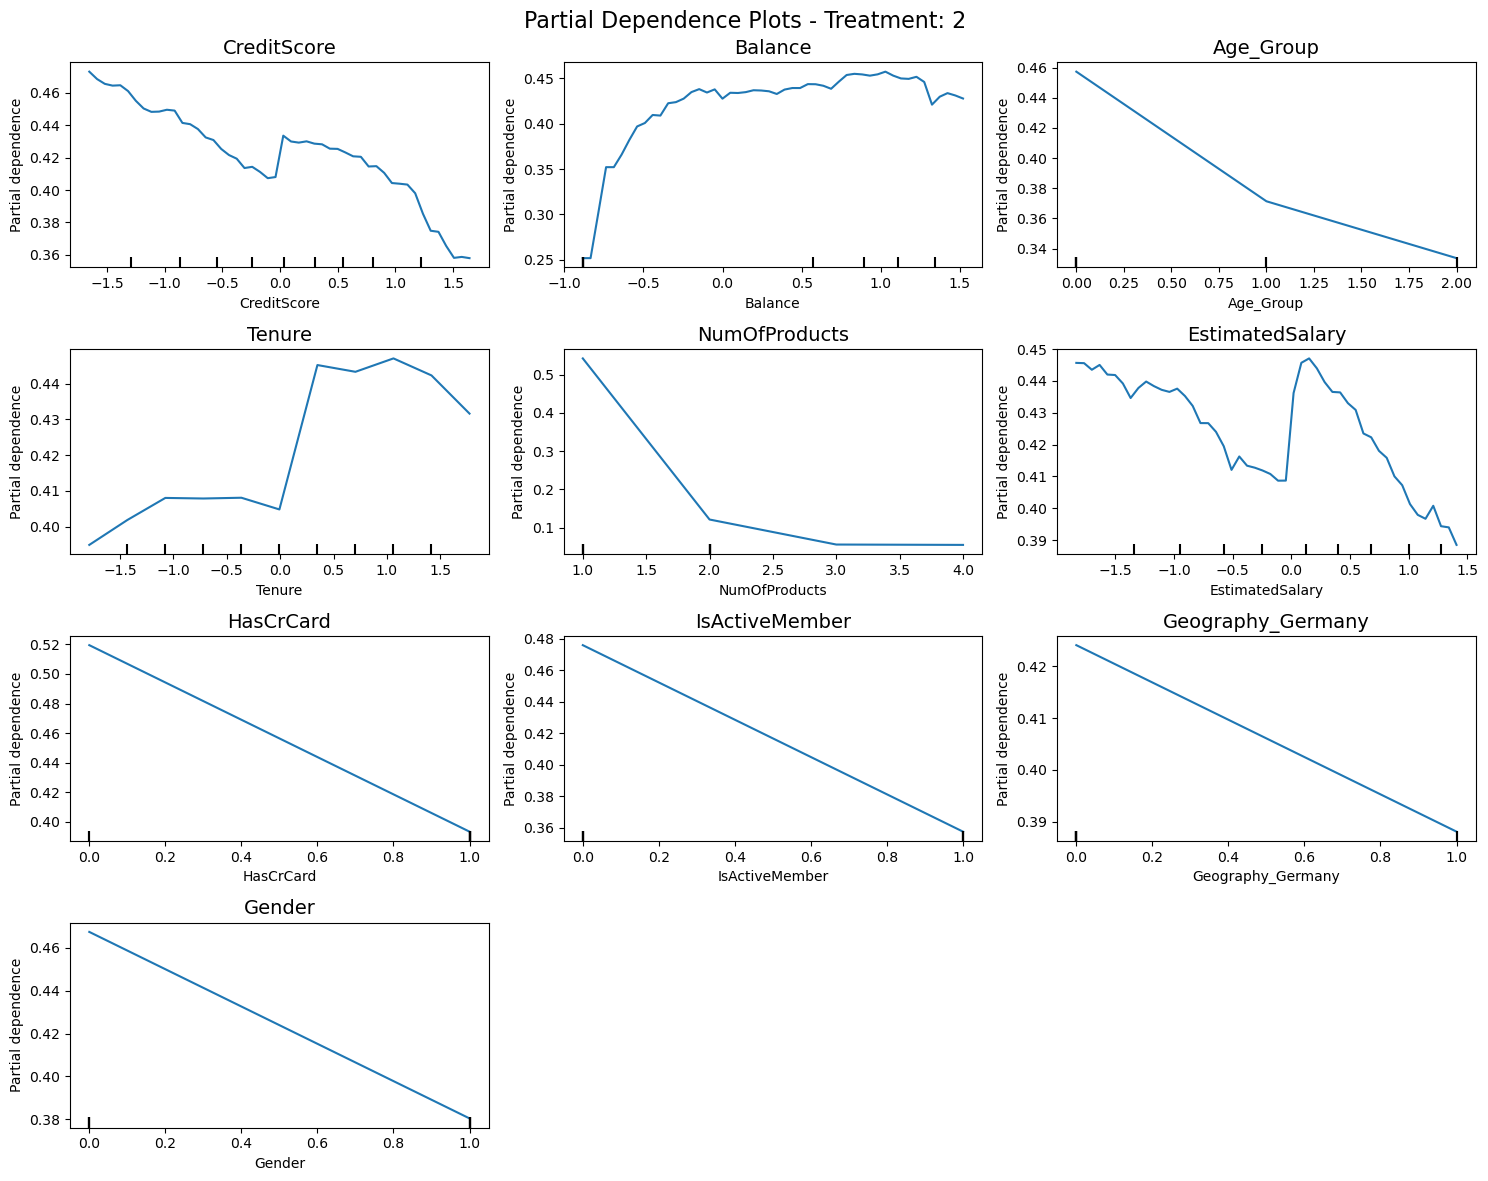

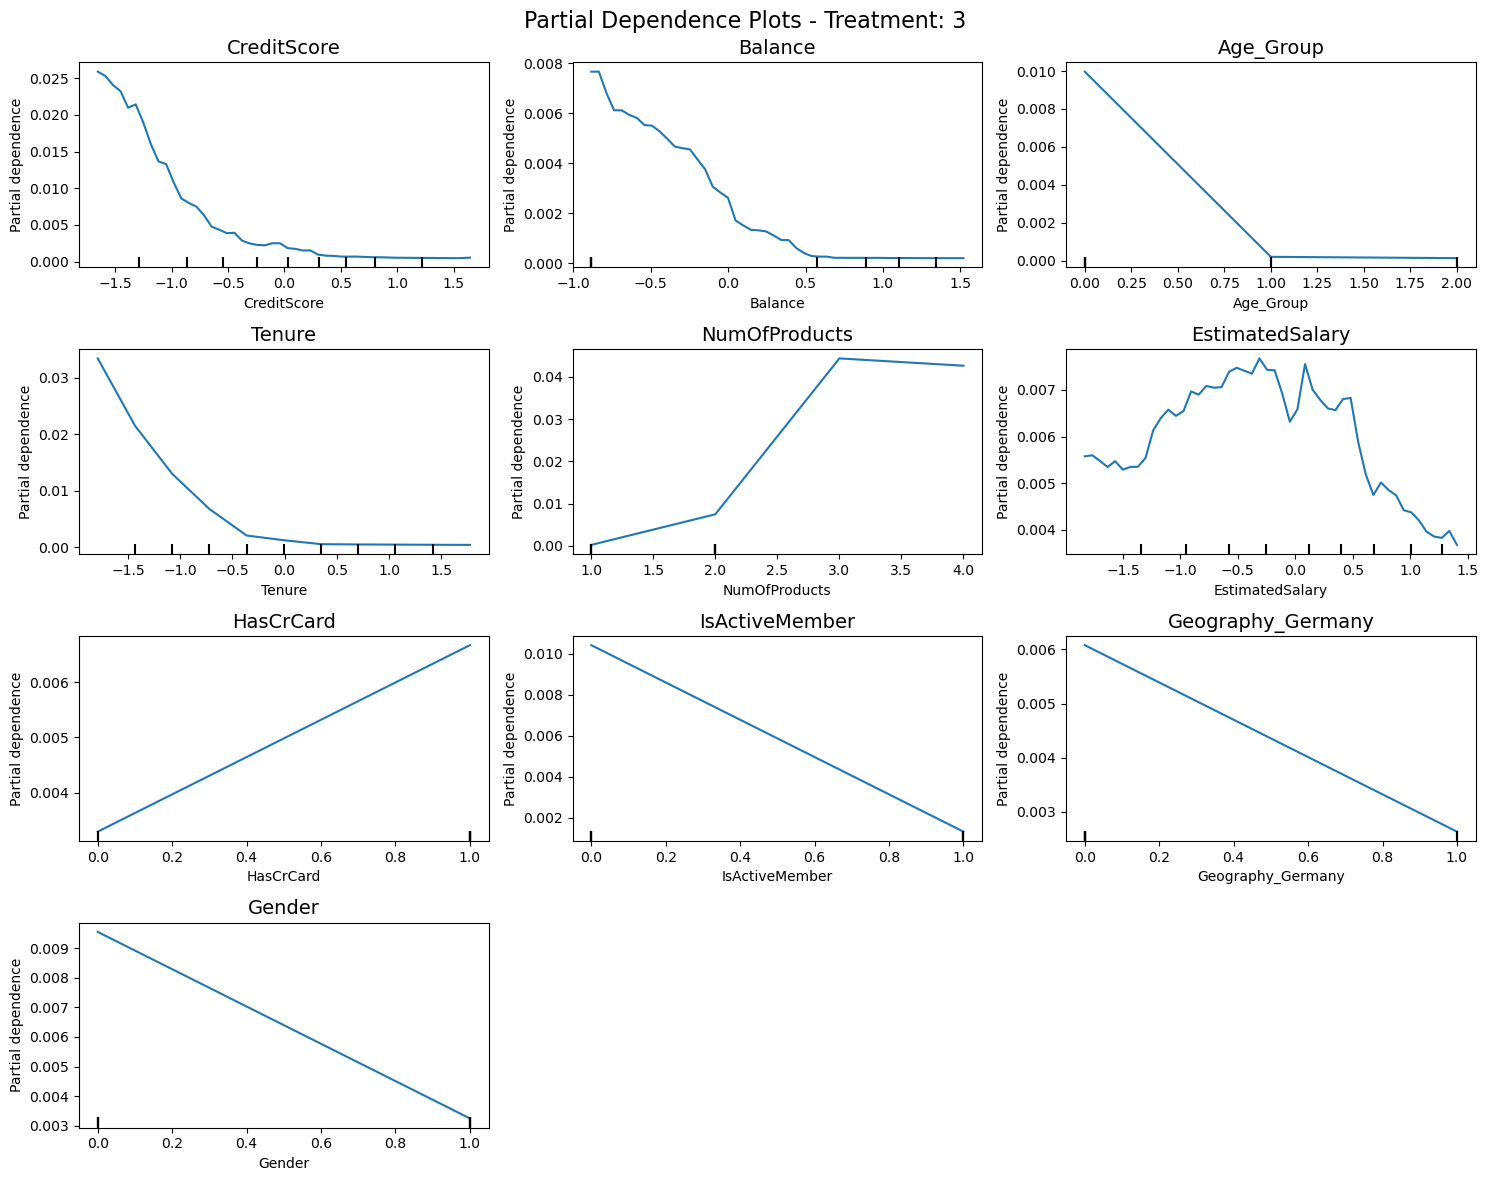

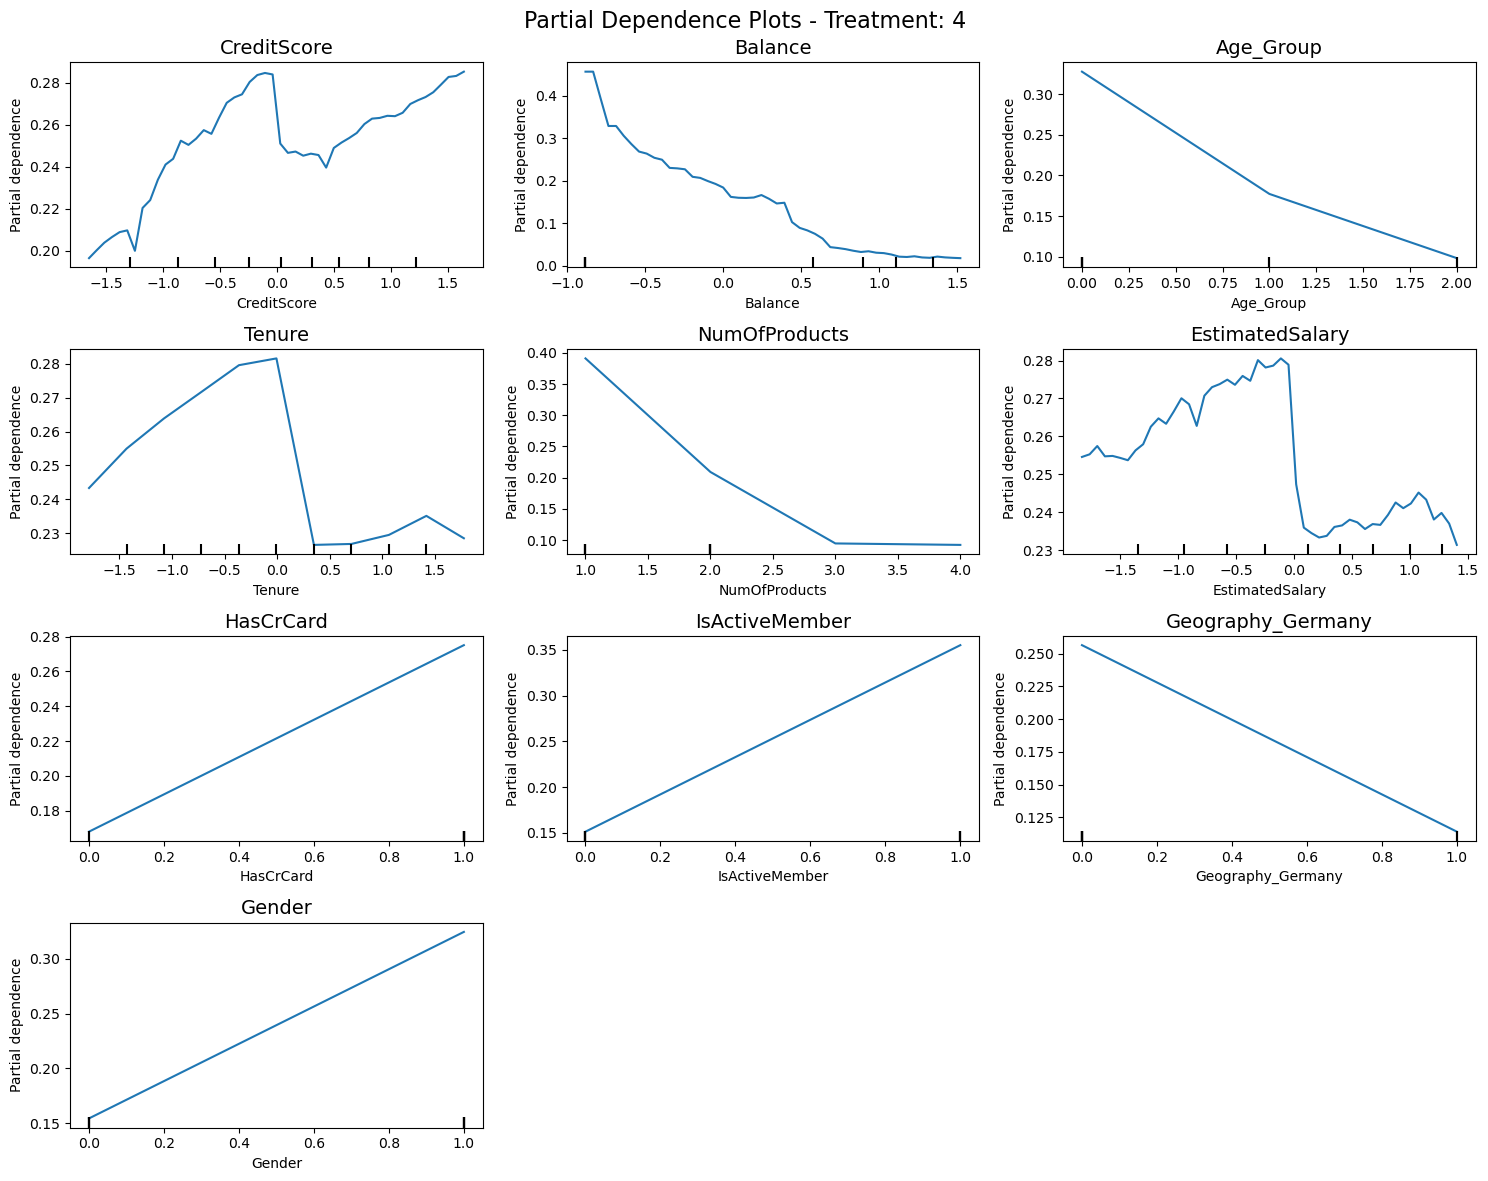

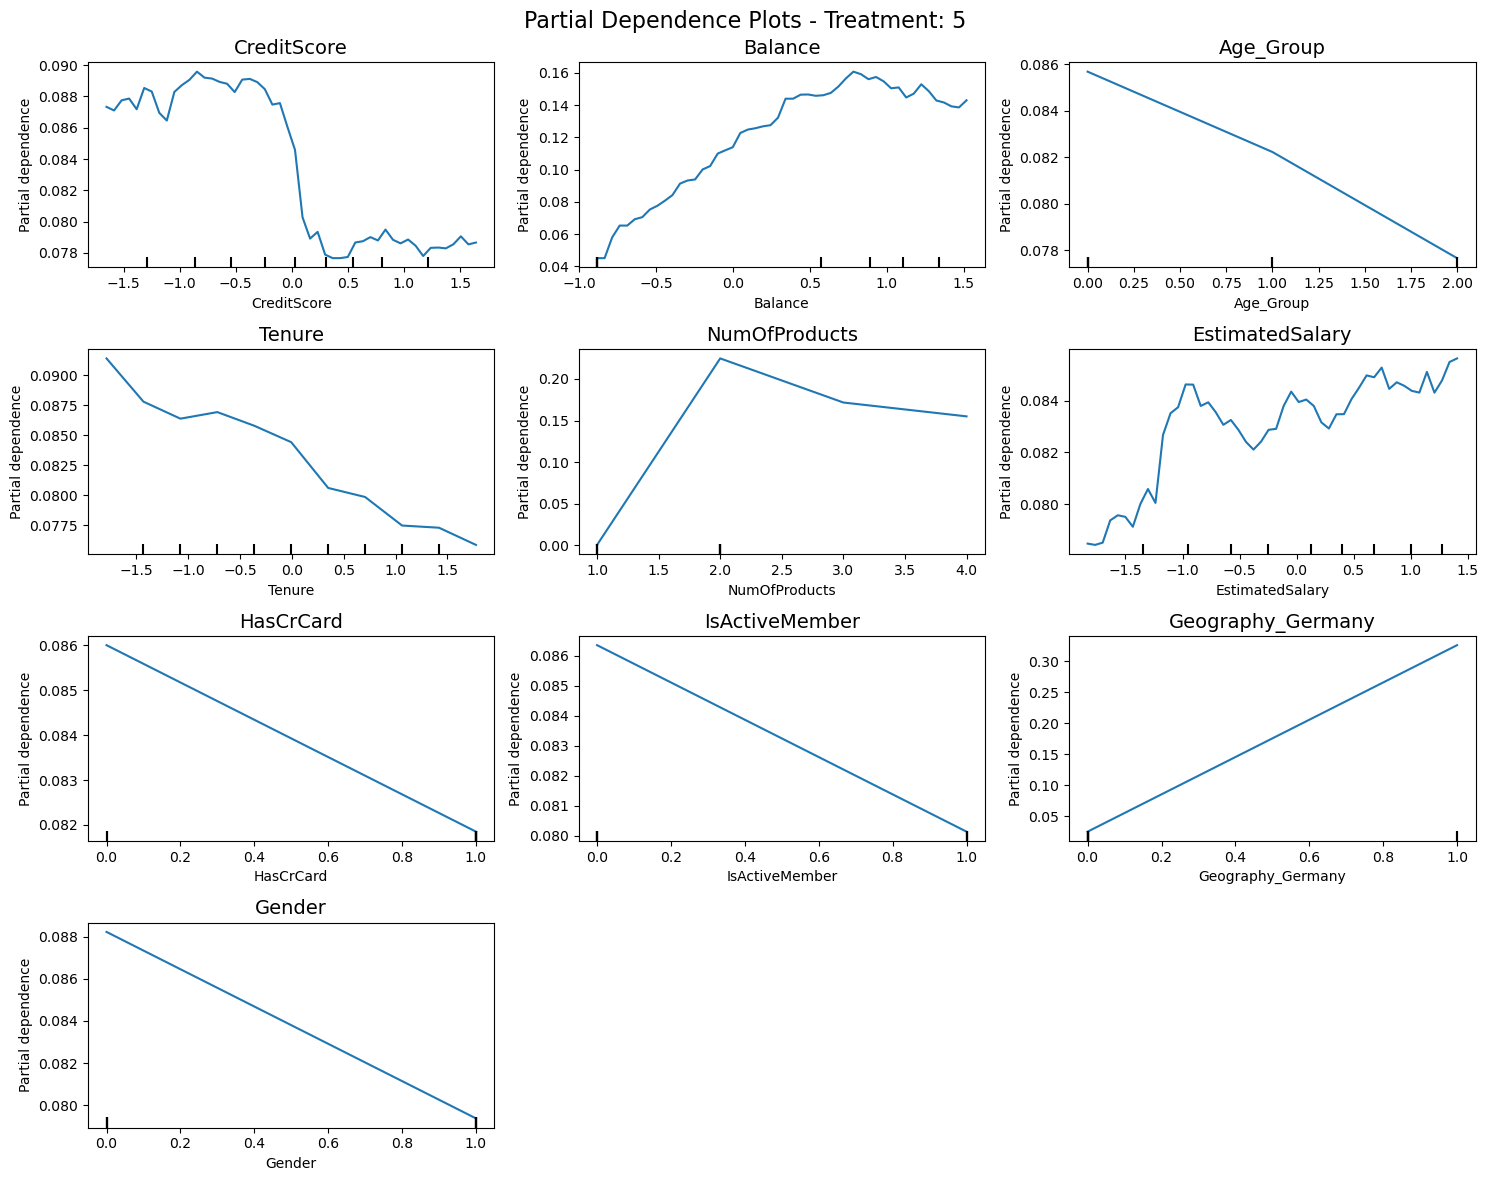

In [64]:
from sklearn.inspection import PartialDependenceDisplay

# Danh sách các nhóm feature
feature_groups = [
    ['CreditScore', 'Balance', 'Age_Group'],
    ['Tenure', 'NumOfProducts', 'EstimatedSalary'],
    ['HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender']
]


# Chuyển danh sách feature_groups thành danh sách các feature đơn lẻ
all_features = [feature for group in feature_groups for feature in group]

treatment_classes = rf_model.classes_

# Lặp qua từng Treatment để vẽ một figure riêng biệt
for treatment in treatment_classes:
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))  # Grid 4x3
    axes = axes.flatten()  # Chuyển thành danh sách để dễ truy cập
    
    # Vẽ Partial Dependence Plot cho từng feature
    for i, feature in enumerate(all_features):
        PartialDependenceDisplay.from_estimator(
            rf_model, X_features,
            features=[feature],  # Đưa vào danh sách đơn để vẽ đúng feature
            target=treatment_classes.tolist().index(treatment),
            grid_resolution=50,
            ax=axes[i]
        )
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_title(f"{feature}", fontsize=14)
    
    # Xóa subplot thừa nếu có ít hơn 12 feature
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Tiêu đề cho cả Figure
    fig.suptitle(f'Partial Dependence Plots - Treatment: {treatment}', fontsize=16)

    plt.tight_layout()
    plt.show()


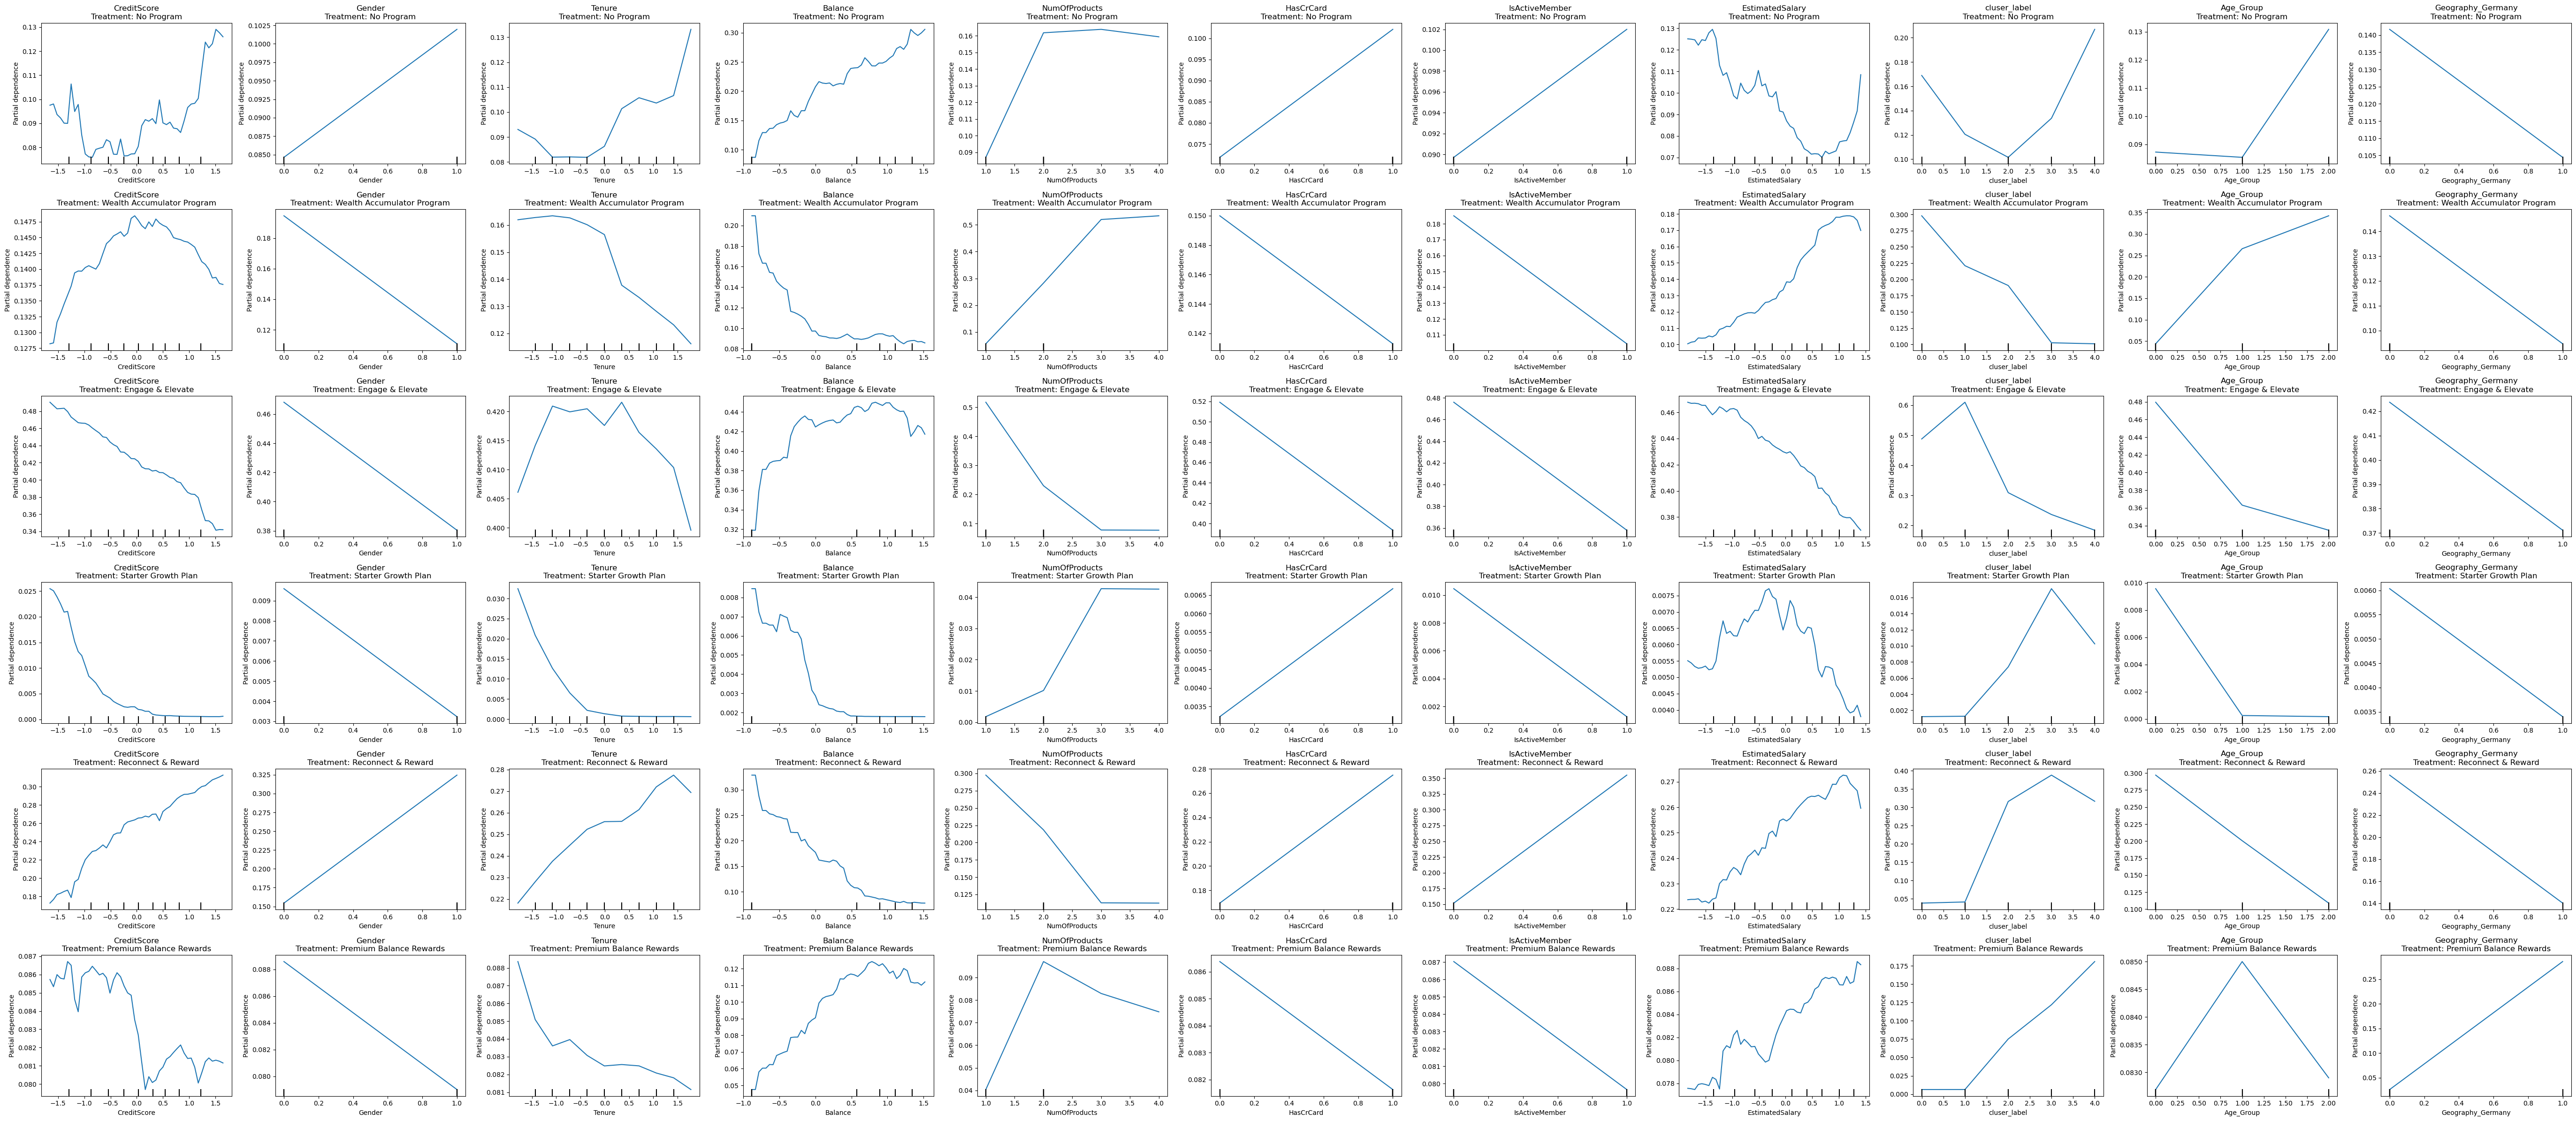

In [ ]:
# # Ví dụ 1: Xem PDP cho một treatment cụ thể, ví dụ "Engage & Elevate" (mapping value = 2)
# target_treatment = 2  # Tương ứng với "Engage & Elevate"
# fig, ax = plt.subplots(figsize=(12,8))
# PartialDependenceDisplay.from_estimator(
#     model_treatment, 
#     X_features, 
#     features,
#     target=target_treatment,  # chỉ xem PDP cho treatment "Engage & Elevate"
#     grid_resolution=50,
#     ax=ax
# )
# plt.suptitle('Partial Dependence Plots for Treatment "Engage & Elevate"')
# plt.show() 